In [1]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers

In [2]:
# Variational autoencoder network
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [3]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

In [4]:
# Latent-space-sampling layer
class Sampler(layers.Layer):
     def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon 

In [5]:
# VAE decoder network, mapping latent space points to images
latent_inputs = keras.Input(shape=(latent_dim,)) 
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs) 
x = layers.Reshape((7, 7, 64))(x) 
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [6]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

In [7]:
# VAE model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss") # Kullback-Leibler divergence 

    @property
    def metrics(self): 
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction),
            axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            print(tf.reduce_mean(kl_loss))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
        "total_loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result(),
        }

In [8]:
import numpy as np
 
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0) 
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
 
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True) 
vae.fit(mnist_digits, epochs=30, batch_size=128) 

Epoch 1/30
tf.Tensor(0.00067803275, shape=(), dtype=float32)
  1/547 [..............................] - ETA: 2:40:46 - total_loss: 543.8604 - reconstruction_loss: 543.8597 - kl_loss: 6.7803e-04tf.Tensor(0.0020587454, shape=(), dtype=float32)
tf.Tensor(0.0009719032, shape=(), dtype=float32)
 11/547 [..............................] - ETA: 43s - total_loss: 524.8975 - reconstruction_loss: 524.8826 - kl_loss: 0.0149tf.Tensor(0.14867635, shape=(), dtype=float32)
tf.Tensor(0.23886374, shape=(), dtype=float32)
 13/547 [..............................] - ETA: 39s - total_loss: 516.8090 - reconstruction_loss: 516.7666 - kl_loss: 0.0425tf.Tensor(0.4440386, shape=(), dtype=float32)
tf.Tensor(0.69467425, shape=(), dtype=float32)
 22/547 [>.............................] - ETA: 42s - total_loss: 463.5485 - reconstruction_loss: 462.3447 - kl_loss: 1.2038tf.Tensor(1.5482285, shape=(), dtype=float32)
tf.Tensor(1.1313242, shape=(), dtype=float32)
 24/547 [>.............................] - ETA: 40s - tota

 58/547 [==>...........................] - ETA: 33s - total_loss: 335.5824 - reconstruction_loss: 334.5844 - kl_loss: 0.9982tf.Tensor(2.0791583, shape=(), dtype=float32)
tf.Tensor(2.0133898, shape=(), dtype=float32)
 60/547 [==>...........................] - ETA: 32s - total_loss: 331.7534 - reconstruction_loss: 330.7204 - kl_loss: 1.0331tf.Tensor(2.019182, shape=(), dtype=float32)
tf.Tensor(1.9485312, shape=(), dtype=float32)
 62/547 [==>...........................] - ETA: 32s - total_loss: 328.0230 - reconstruction_loss: 326.9593 - kl_loss: 1.0638tf.Tensor(1.9880463, shape=(), dtype=float32)
tf.Tensor(1.9917098, shape=(), dtype=float32)
 78/547 [===>..........................] - ETA: 33s - total_loss: 304.7051 - reconstruction_loss: 303.3895 - kl_loss: 1.3157tf.Tensor(2.045742, shape=(), dtype=float32)
tf.Tensor(1.8639799, shape=(), dtype=float32)
 81/547 [===>..........................] - ETA: 32s - total_loss: 301.2555 - reconstruction_loss: 299.9159 - kl_loss: 1.3398tf.Tensor(1.86

129/547 [======>.......................] - ETA: 28s - total_loss: 266.7369 - reconstruction_loss: 265.0729 - kl_loss: 1.6641tf.Tensor(1.7994841, shape=(), dtype=float32)
tf.Tensor(1.961653, shape=(), dtype=float32)
136/547 [======>.......................] - ETA: 28s - total_loss: 263.4770 - reconstruction_loss: 261.7918 - kl_loss: 1.6853tf.Tensor(2.8658571, shape=(), dtype=float32)
tf.Tensor(2.5174692, shape=(), dtype=float32)
151/547 [=======>......................] - ETA: 27s - total_loss: 257.2933 - reconstruction_loss: 255.5268 - kl_loss: 1.7666tf.Tensor(2.353886, shape=(), dtype=float32)
tf.Tensor(2.324985, shape=(), dtype=float32)
156/547 [=======>......................] - ETA: 27s - total_loss: 255.4762 - reconstruction_loss: 253.6880 - kl_loss: 1.7883tf.Tensor(2.5889578, shape=(), dtype=float32)
tf.Tensor(2.8576753, shape=(), dtype=float32)
159/547 [=======>......................] - ETA: 27s - total_loss: 254.3792 - reconstruction_loss: 252.5735 - kl_loss: 1.8058tf.Tensor(2.930

174/547 [========>.....................] - ETA: 26s - total_loss: 249.7978 - reconstruction_loss: 247.9584 - kl_loss: 1.8395tf.Tensor(2.1712122, shape=(), dtype=float32)
tf.Tensor(2.5404122, shape=(), dtype=float32)
178/547 [========>.....................] - ETA: 25s - total_loss: 248.5967 - reconstruction_loss: 246.7443 - kl_loss: 1.8525tf.Tensor(2.5698123, shape=(), dtype=float32)
tf.Tensor(3.0249114, shape=(), dtype=float32)
180/547 [========>.....................] - ETA: 25s - total_loss: 247.9954 - reconstruction_loss: 246.1325 - kl_loss: 1.8630tf.Tensor(3.0770283, shape=(), dtype=float32)
tf.Tensor(2.596079, shape=(), dtype=float32)
184/547 [=========>....................] - ETA: 25s - total_loss: 246.8958 - reconstruction_loss: 245.0170 - kl_loss: 1.8788tf.Tensor(2.1274397, shape=(), dtype=float32)
tf.Tensor(2.298478, shape=(), dtype=float32)
187/547 [=========>....................] - ETA: 25s - total_loss: 246.1439 - reconstruction_loss: 244.2599 - kl_loss: 1.8841tf.Tensor(2.85

tf.Tensor(2.6295133, shape=(), dtype=float32)
237/547 [===========>..................] - ETA: 21s - total_loss: 235.8677 - reconstruction_loss: 233.8476 - kl_loss: 2.0202tf.Tensor(2.5809565, shape=(), dtype=float32)
tf.Tensor(2.6304238, shape=(), dtype=float32)
248/547 [============>.................] - ETA: 20s - total_loss: 234.0887 - reconstruction_loss: 232.0483 - kl_loss: 2.0405tf.Tensor(2.3997774, shape=(), dtype=float32)
tf.Tensor(1.9629536, shape=(), dtype=float32)
251/547 [============>.................] - ETA: 20s - total_loss: 233.6469 - reconstruction_loss: 231.6045 - kl_loss: 2.0424tf.Tensor(1.9756305, shape=(), dtype=float32)
tf.Tensor(2.4736247, shape=(), dtype=float32)
253/547 [============>.................] - ETA: 20s - total_loss: 233.3666 - reconstruction_loss: 231.3229 - kl_loss: 2.0438tf.Tensor(2.3852432, shape=(), dtype=float32)
tf.Tensor(2.745137, shape=(), dtype=float32)
255/547 [============>.................] - ETA: 19s - total_loss: 233.0739 - reconstruction

297/547 [===============>..............] - ETA: 17s - total_loss: 227.6654 - reconstruction_loss: 225.5497 - kl_loss: 2.1159tf.Tensor(2.182879, shape=(), dtype=float32)
tf.Tensor(2.406489, shape=(), dtype=float32)
299/547 [===============>..............] - ETA: 16s - total_loss: 227.4673 - reconstruction_loss: 225.3504 - kl_loss: 2.1171tf.Tensor(2.1315293, shape=(), dtype=float32)
tf.Tensor(2.055006, shape=(), dtype=float32)
301/547 [===============>..............] - ETA: 16s - total_loss: 227.2662 - reconstruction_loss: 225.1494 - kl_loss: 2.1169tf.Tensor(2.5882497, shape=(), dtype=float32)
tf.Tensor(2.2371716, shape=(), dtype=float32)
305/547 [===============>..............] - ETA: 16s - total_loss: 226.8079 - reconstruction_loss: 224.6861 - kl_loss: 2.1219tf.Tensor(2.399135, shape=(), dtype=float32)
tf.Tensor(2.2401273, shape=(), dtype=float32)
309/547 [===============>..............] - ETA: 16s - total_loss: 226.3869 - reconstruction_loss: 224.2635 - kl_loss: 2.1235tf.Tensor(2.3249

361/547 [==================>...........] - ETA: 12s - total_loss: 221.4462 - reconstruction_loss: 219.2799 - kl_loss: 2.1664tf.Tensor(2.374945, shape=(), dtype=float32)
tf.Tensor(2.452438, shape=(), dtype=float32)
363/547 [==================>...........] - ETA: 12s - total_loss: 221.2867 - reconstruction_loss: 219.1191 - kl_loss: 2.1678tf.Tensor(2.2943788, shape=(), dtype=float32)
tf.Tensor(3.0791159, shape=(), dtype=float32)
366/547 [===================>..........] - ETA: 11s - total_loss: 221.0195 - reconstruction_loss: 218.8484 - kl_loss: 2.1713tf.Tensor(2.3099623, shape=(), dtype=float32)
tf.Tensor(2.3458457, shape=(), dtype=float32)
368/547 [===================>..........] - ETA: 11s - total_loss: 220.8873 - reconstruction_loss: 218.7153 - kl_loss: 2.1721tf.Tensor(2.6523514, shape=(), dtype=float32)
tf.Tensor(2.5213342, shape=(), dtype=float32)
370/547 [===================>..........] - ETA: 11s - total_loss: 220.7170 - reconstruction_loss: 218.5428 - kl_loss: 2.1744tf.Tensor(2.35

426/547 [======================>.......] - ETA: 7s - total_loss: 216.7770 - reconstruction_loss: 214.5737 - kl_loss: 2.2035tf.Tensor(1.9573302, shape=(), dtype=float32)
tf.Tensor(2.236881, shape=(), dtype=float32)
431/547 [======================>.......] - ETA: 7s - total_loss: 216.4697 - reconstruction_loss: 214.2660 - kl_loss: 2.2039tf.Tensor(2.2807302, shape=(), dtype=float32)
tf.Tensor(2.1459594, shape=(), dtype=float32)
438/547 [=======================>......] - ETA: 7s - total_loss: 216.0865 - reconstruction_loss: 213.8820 - kl_loss: 2.2047tf.Tensor(2.6636286, shape=(), dtype=float32)
tf.Tensor(2.4178348, shape=(), dtype=float32)
448/547 [=======================>......] - ETA: 6s - total_loss: 215.5581 - reconstruction_loss: 213.3498 - kl_loss: 2.2085tf.Tensor(2.664694, shape=(), dtype=float32)
tf.Tensor(2.4721737, shape=(), dtype=float32)
452/547 [=======================>......] - ETA: 6s - total_loss: 215.3102 - reconstruction_loss: 213.0993 - kl_loss: 2.2111tf.Tensor(2.2976508

483/547 [=========================>....] - ETA: 4s - total_loss: 213.6192 - reconstruction_loss: 211.3948 - kl_loss: 2.2246tf.Tensor(2.5626132, shape=(), dtype=float32)
tf.Tensor(2.644055, shape=(), dtype=float32)
485/547 [=========================>....] - ETA: 3s - total_loss: 213.5009 - reconstruction_loss: 211.2750 - kl_loss: 2.2261tf.Tensor(2.5659149, shape=(), dtype=float32)
tf.Tensor(2.517084, shape=(), dtype=float32)
487/547 [=========================>....] - ETA: 3s - total_loss: 213.4044 - reconstruction_loss: 211.1772 - kl_loss: 2.2274tf.Tensor(2.7364666, shape=(), dtype=float32)
tf.Tensor(2.44313, shape=(), dtype=float32)
494/547 [==========================>...] - ETA: 3s - total_loss: 213.0280 - reconstruction_loss: 210.7959 - kl_loss: 2.2323tf.Tensor(2.50467, shape=(), dtype=float32)
tf.Tensor(2.2056947, shape=(), dtype=float32)
496/547 [==========================>...] - ETA: 3s - total_loss: 212.9365 - reconstruction_loss: 210.7039 - kl_loss: 2.2328tf.Tensor(2.4075613, sh

543/547 [============================>.] - ETA: 0s - total_loss: 210.7837 - reconstruction_loss: 208.5265 - kl_loss: 2.2574tf.Tensor(2.3947644, shape=(), dtype=float32)
tf.Tensor(2.577183, shape=(), dtype=float32)
547/547 [==============================] - 53s 65ms/step - total_loss: 210.6635 - reconstruction_loss: 208.4047 - kl_loss: 2.2589
Epoch 2/30
tf.Tensor(2.9114132, shape=(), dtype=float32)
  2/547 [..............................] - ETA: 43s - total_loss: 189.3434 - reconstruction_loss: 186.6985 - kl_loss: 2.6448tf.Tensor(2.7086606, shape=(), dtype=float32)
tf.Tensor(2.3993843, shape=(), dtype=float32)
  6/547 [..............................] - ETA: 42s - total_loss: 189.5285 - reconstruction_loss: 186.9121 - kl_loss: 2.6164tf.Tensor(2.3629208, shape=(), dtype=float32)
tf.Tensor(2.5862665, shape=(), dtype=float32)
  8/547 [..............................] - ETA: 42s - total_loss: 188.7213 - reconstruction_loss: 186.1404 - kl_loss: 2.5810tf.Tensor(2.7447252, shape=(), dtype=float3

 57/547 [==>...........................] - ETA: 29s - total_loss: 184.3936 - reconstruction_loss: 181.5273 - kl_loss: 2.8663tf.Tensor(3.3104782, shape=(), dtype=float32)
tf.Tensor(3.4375193, shape=(), dtype=float32)
 59/547 [==>...........................] - ETA: 28s - total_loss: 184.2367 - reconstruction_loss: 181.3532 - kl_loss: 2.8835tf.Tensor(3.5529625, shape=(), dtype=float32)
tf.Tensor(3.1395879, shape=(), dtype=float32)
 68/547 [==>...........................] - ETA: 28s - total_loss: 183.3860 - reconstruction_loss: 180.4184 - kl_loss: 2.9677tf.Tensor(3.5332437, shape=(), dtype=float32)
tf.Tensor(3.852671, shape=(), dtype=float32)
 72/547 [==>...........................] - ETA: 28s - total_loss: 183.2089 - reconstruction_loss: 180.1920 - kl_loss: 3.0169tf.Tensor(3.6538558, shape=(), dtype=float32)
tf.Tensor(3.834961, shape=(), dtype=float32)
 84/547 [===>..........................] - ETA: 28s - total_loss: 182.7114 - reconstruction_loss: 179.5866 - kl_loss: 3.1248tf.Tensor(3.74

114/547 [=====>........................] - ETA: 27s - total_loss: 181.4404 - reconstruction_loss: 178.1353 - kl_loss: 3.3051tf.Tensor(4.660117, shape=(), dtype=float32)
tf.Tensor(3.8496375, shape=(), dtype=float32)
116/547 [=====>........................] - ETA: 27s - total_loss: 181.2656 - reconstruction_loss: 177.9441 - kl_loss: 3.3214tf.Tensor(3.9559202, shape=(), dtype=float32)
tf.Tensor(3.725082, shape=(), dtype=float32)
120/547 [=====>........................] - ETA: 27s - total_loss: 181.1671 - reconstruction_loss: 177.8247 - kl_loss: 3.3424tf.Tensor(3.9277668, shape=(), dtype=float32)
tf.Tensor(4.0446997, shape=(), dtype=float32)
134/547 [======>.......................] - ETA: 28s - total_loss: 180.6353 - reconstruction_loss: 177.2206 - kl_loss: 3.4147tf.Tensor(3.9666293, shape=(), dtype=float32)
tf.Tensor(3.6436567, shape=(), dtype=float32)
147/547 [=======>......................] - ETA: 28s - total_loss: 180.1985 - reconstruction_loss: 176.7414 - kl_loss: 3.4572tf.Tensor(3.96

169/547 [========>.....................] - ETA: 26s - total_loss: 179.4732 - reconstruction_loss: 175.9544 - kl_loss: 3.5188tf.Tensor(3.5912523, shape=(), dtype=float32)
tf.Tensor(3.7754629, shape=(), dtype=float32)
181/547 [========>.....................] - ETA: 26s - total_loss: 179.1326 - reconstruction_loss: 175.5925 - kl_loss: 3.5402tf.Tensor(3.8480635, shape=(), dtype=float32)
tf.Tensor(3.6641765, shape=(), dtype=float32)
189/547 [=========>....................] - ETA: 25s - total_loss: 178.8761 - reconstruction_loss: 175.3174 - kl_loss: 3.5587tf.Tensor(3.7618551, shape=(), dtype=float32)
tf.Tensor(4.161134, shape=(), dtype=float32)
195/547 [=========>....................] - ETA: 25s - total_loss: 178.6737 - reconstruction_loss: 175.1051 - kl_loss: 3.5685tf.Tensor(3.9154398, shape=(), dtype=float32)
tf.Tensor(4.108794, shape=(), dtype=float32)
199/547 [=========>....................] - ETA: 25s - total_loss: 178.5625 - reconstruction_loss: 174.9867 - kl_loss: 3.5758tf.Tensor(4.09

228/547 [===========>..................] - ETA: 23s - total_loss: 177.7021 - reconstruction_loss: 174.0838 - kl_loss: 3.6183tf.Tensor(3.7910776, shape=(), dtype=float32)
tf.Tensor(4.0352554, shape=(), dtype=float32)
231/547 [===========>..................] - ETA: 22s - total_loss: 177.6049 - reconstruction_loss: 173.9823 - kl_loss: 3.6225tf.Tensor(3.8161163, shape=(), dtype=float32)
tf.Tensor(3.9154882, shape=(), dtype=float32)
244/547 [============>.................] - ETA: 22s - total_loss: 177.2774 - reconstruction_loss: 173.6412 - kl_loss: 3.6362tf.Tensor(3.736598, shape=(), dtype=float32)
tf.Tensor(3.90439, shape=(), dtype=float32)
247/547 [============>.................] - ETA: 21s - total_loss: 177.2388 - reconstruction_loss: 173.5998 - kl_loss: 3.6390tf.Tensor(3.8606174, shape=(), dtype=float32)
tf.Tensor(3.831948, shape=(), dtype=float32)
259/547 [=============>................] - ETA: 21s - total_loss: 177.0176 - reconstruction_loss: 173.3678 - kl_loss: 3.6498tf.Tensor(4.1068

281/547 [==============>...............] - ETA: 19s - total_loss: 176.6615 - reconstruction_loss: 172.9951 - kl_loss: 3.6664tf.Tensor(3.9190989, shape=(), dtype=float32)
tf.Tensor(4.0100203, shape=(), dtype=float32)
284/547 [==============>...............] - ETA: 19s - total_loss: 176.5708 - reconstruction_loss: 172.9025 - kl_loss: 3.6684tf.Tensor(3.776446, shape=(), dtype=float32)
tf.Tensor(3.554813, shape=(), dtype=float32)
290/547 [==============>...............] - ETA: 18s - total_loss: 176.4901 - reconstruction_loss: 172.8191 - kl_loss: 3.6709tf.Tensor(3.7842672, shape=(), dtype=float32)
tf.Tensor(3.9251118, shape=(), dtype=float32)
292/547 [===============>..............] - ETA: 18s - total_loss: 176.4362 - reconstruction_loss: 172.7641 - kl_loss: 3.6722tf.Tensor(3.5998151, shape=(), dtype=float32)
tf.Tensor(3.5818624, shape=(), dtype=float32)
295/547 [===============>..............] - ETA: 18s - total_loss: 176.4190 - reconstruction_loss: 172.7475 - kl_loss: 3.6715tf.Tensor(4.29

356/547 [==================>...........] - ETA: 13s - total_loss: 175.2666 - reconstruction_loss: 171.5520 - kl_loss: 3.7145tf.Tensor(3.6963897, shape=(), dtype=float32)
tf.Tensor(3.80234, shape=(), dtype=float32)
359/547 [==================>...........] - ETA: 13s - total_loss: 175.1923 - reconstruction_loss: 171.4768 - kl_loss: 3.7155tf.Tensor(4.024634, shape=(), dtype=float32)
tf.Tensor(3.9933467, shape=(), dtype=float32)
371/547 [===================>..........] - ETA: 12s - total_loss: 174.9917 - reconstruction_loss: 171.2683 - kl_loss: 3.7233tf.Tensor(3.8040748, shape=(), dtype=float32)
tf.Tensor(3.9538796, shape=(), dtype=float32)
374/547 [===================>..........] - ETA: 12s - total_loss: 174.9348 - reconstruction_loss: 171.2104 - kl_loss: 3.7244tf.Tensor(3.8851705, shape=(), dtype=float32)
tf.Tensor(3.8971856, shape=(), dtype=float32)
379/547 [===================>..........] - ETA: 11s - total_loss: 174.8678 - reconstruction_loss: 171.1395 - kl_loss: 3.7282tf.Tensor(3.830

401/547 [====================>.........] - ETA: 10s - total_loss: 174.5496 - reconstruction_loss: 170.8111 - kl_loss: 3.7383tf.Tensor(3.3096874, shape=(), dtype=float32)
tf.Tensor(3.7480874, shape=(), dtype=float32)
403/547 [=====================>........] - ETA: 10s - total_loss: 174.5506 - reconstruction_loss: 170.8133 - kl_loss: 3.7373tf.Tensor(3.8357239, shape=(), dtype=float32)
tf.Tensor(4.1238027, shape=(), dtype=float32)
405/547 [=====================>........] - ETA: 9s - total_loss: 174.5096 - reconstruction_loss: 170.7710 - kl_loss: 3.7385 tf.Tensor(4.1609707, shape=(), dtype=float32)
tf.Tensor(3.9051874, shape=(), dtype=float32)
412/547 [=====================>........] - ETA: 9s - total_loss: 174.3965 - reconstruction_loss: 170.6545 - kl_loss: 3.7420tf.Tensor(4.139048, shape=(), dtype=float32)
tf.Tensor(3.8789585, shape=(), dtype=float32)
417/547 [=====================>........] - ETA: 9s - total_loss: 174.3101 - reconstruction_loss: 170.5660 - kl_loss: 3.7439tf.Tensor(3.960

461/547 [========================>.....] - ETA: 6s - total_loss: 173.7923 - reconstruction_loss: 170.0361 - kl_loss: 3.7560tf.Tensor(3.6086042, shape=(), dtype=float32)
tf.Tensor(3.8415403, shape=(), dtype=float32)
465/547 [========================>.....] - ETA: 5s - total_loss: 173.7681 - reconstruction_loss: 170.0111 - kl_loss: 3.7568tf.Tensor(4.0137916, shape=(), dtype=float32)
tf.Tensor(3.8391082, shape=(), dtype=float32)
467/547 [========================>.....] - ETA: 5s - total_loss: 173.7450 - reconstruction_loss: 169.9873 - kl_loss: 3.7576tf.Tensor(3.7907536, shape=(), dtype=float32)
tf.Tensor(3.9017026, shape=(), dtype=float32)
475/547 [=========================>....] - ETA: 5s - total_loss: 173.6239 - reconstruction_loss: 169.8634 - kl_loss: 3.7604tf.Tensor(4.0101986, shape=(), dtype=float32)
tf.Tensor(4.021677, shape=(), dtype=float32)
481/547 [=========================>....] - ETA: 4s - total_loss: 173.5335 - reconstruction_loss: 169.7704 - kl_loss: 3.7629tf.Tensor(4.198208

534/547 [============================>.] - ETA: 0s - total_loss: 172.9028 - reconstruction_loss: 169.1288 - kl_loss: 3.7738tf.Tensor(3.8918116, shape=(), dtype=float32)
tf.Tensor(3.7833593, shape=(), dtype=float32)
547/547 [==============================] - 41s 74ms/step - total_loss: 172.7064 - reconstruction_loss: 168.9296 - kl_loss: 3.7765
Epoch 3/30
tf.Tensor(3.9535494, shape=(), dtype=float32)
  4/547 [..............................] - ETA: 37s - total_loss: 169.4728 - reconstruction_loss: 165.5884 - kl_loss: 3.8844tf.Tensor(3.987, shape=(), dtype=float32)
tf.Tensor(3.9833903, shape=(), dtype=float32)
  7/547 [..............................] - ETA: 38s - total_loss: 167.7109 - reconstruction_loss: 163.8014 - kl_loss: 3.9095tf.Tensor(3.6978288, shape=(), dtype=float32)
tf.Tensor(3.9094563, shape=(), dtype=float32)
 10/547 [..............................] - ETA: 35s - total_loss: 168.3140 - reconstruction_loss: 164.4482 - kl_loss: 3.8659tf.Tensor(4.057343, shape=(), dtype=float32)
t

 23/547 [>.............................] - ETA: 37s - total_loss: 167.7097 - reconstruction_loss: 163.8965 - kl_loss: 3.8131tf.Tensor(3.8649385, shape=(), dtype=float32)
tf.Tensor(3.6903527, shape=(), dtype=float32)
 25/547 [>.............................] - ETA: 37s - total_loss: 167.6761 - reconstruction_loss: 163.8658 - kl_loss: 3.8103tf.Tensor(3.8233402, shape=(), dtype=float32)
tf.Tensor(3.9040537, shape=(), dtype=float32)
 27/547 [>.............................] - ETA: 36s - total_loss: 167.4359 - reconstruction_loss: 163.6216 - kl_loss: 3.8143tf.Tensor(3.5868416, shape=(), dtype=float32)
tf.Tensor(3.9101946, shape=(), dtype=float32)
 29/547 [>.............................] - ETA: 35s - total_loss: 167.5429 - reconstruction_loss: 163.7331 - kl_loss: 3.8097tf.Tensor(3.7583764, shape=(), dtype=float32)
tf.Tensor(3.7226617, shape=(), dtype=float32)
 35/547 [>.............................] - ETA: 35s - total_loss: 167.3281 - reconstruction_loss: 163.5217 - kl_loss: 3.8065tf.Tensor(3.

 85/547 [===>..........................] - ETA: 30s - total_loss: 165.9523 - reconstruction_loss: 162.1062 - kl_loss: 3.8462tf.Tensor(3.8089385, shape=(), dtype=float32)
tf.Tensor(3.6372242, shape=(), dtype=float32)
 87/547 [===>..........................] - ETA: 30s - total_loss: 166.0162 - reconstruction_loss: 162.1728 - kl_loss: 3.8434tf.Tensor(3.7182388, shape=(), dtype=float32)
tf.Tensor(3.8698072, shape=(), dtype=float32)
 89/547 [===>..........................] - ETA: 29s - total_loss: 166.0973 - reconstruction_loss: 162.2551 - kl_loss: 3.8423tf.Tensor(3.902399, shape=(), dtype=float32)
tf.Tensor(3.726442, shape=(), dtype=float32)
 92/547 [====>.........................] - ETA: 29s - total_loss: 166.0902 - reconstruction_loss: 162.2481 - kl_loss: 3.8421tf.Tensor(3.8954246, shape=(), dtype=float32)
tf.Tensor(3.6965995, shape=(), dtype=float32)
 97/547 [====>.........................] - ETA: 29s - total_loss: 166.0766 - reconstruction_loss: 162.2358 - kl_loss: 3.8409tf.Tensor(3.72

146/547 [=======>......................] - ETA: 27s - total_loss: 166.1479 - reconstruction_loss: 162.2929 - kl_loss: 3.8551tf.Tensor(4.037641, shape=(), dtype=float32)
tf.Tensor(3.9574652, shape=(), dtype=float32)
148/547 [=======>......................] - ETA: 26s - total_loss: 166.1854 - reconstruction_loss: 162.3284 - kl_loss: 3.8570tf.Tensor(3.7942212, shape=(), dtype=float32)
tf.Tensor(3.707179, shape=(), dtype=float32)
153/547 [=======>......................] - ETA: 26s - total_loss: 166.2776 - reconstruction_loss: 162.4236 - kl_loss: 3.8541tf.Tensor(3.9487712, shape=(), dtype=float32)
tf.Tensor(3.7150717, shape=(), dtype=float32)
157/547 [=======>......................] - ETA: 25s - total_loss: 166.3067 - reconstruction_loss: 162.4517 - kl_loss: 3.8551tf.Tensor(4.078063, shape=(), dtype=float32)
tf.Tensor(4.341634, shape=(), dtype=float32)
163/547 [=======>......................] - ETA: 25s - total_loss: 166.1878 - reconstruction_loss: 162.3309 - kl_loss: 3.8570tf.Tensor(4.0295

207/547 [==========>...................] - ETA: 22s - total_loss: 165.7492 - reconstruction_loss: 161.8853 - kl_loss: 3.8640tf.Tensor(3.7976627, shape=(), dtype=float32)
tf.Tensor(3.6044402, shape=(), dtype=float32)
219/547 [===========>..................] - ETA: 21s - total_loss: 165.7931 - reconstruction_loss: 161.9304 - kl_loss: 3.8628tf.Tensor(3.793845, shape=(), dtype=float32)
tf.Tensor(3.697987, shape=(), dtype=float32)
221/547 [===========>..................] - ETA: 21s - total_loss: 165.7885 - reconstruction_loss: 161.9269 - kl_loss: 3.8617tf.Tensor(3.779154, shape=(), dtype=float32)
tf.Tensor(3.7392492, shape=(), dtype=float32)
223/547 [===========>..................] - ETA: 21s - total_loss: 165.7886 - reconstruction_loss: 161.9279 - kl_loss: 3.8608tf.Tensor(4.1098385, shape=(), dtype=float32)
tf.Tensor(3.9406915, shape=(), dtype=float32)
225/547 [===========>..................] - ETA: 20s - total_loss: 165.7482 - reconstruction_loss: 161.8860 - kl_loss: 3.8623tf.Tensor(3.875

267/547 [=============>................] - ETA: 18s - total_loss: 165.7041 - reconstruction_loss: 161.8413 - kl_loss: 3.8628tf.Tensor(3.972412, shape=(), dtype=float32)
tf.Tensor(3.815847, shape=(), dtype=float32)
269/547 [=============>................] - ETA: 18s - total_loss: 165.6997 - reconstruction_loss: 161.8367 - kl_loss: 3.8630tf.Tensor(3.8596652, shape=(), dtype=float32)
tf.Tensor(3.996619, shape=(), dtype=float32)
271/547 [=============>................] - ETA: 18s - total_loss: 165.6921 - reconstruction_loss: 161.8286 - kl_loss: 3.8635tf.Tensor(3.8383543, shape=(), dtype=float32)
tf.Tensor(4.0367165, shape=(), dtype=float32)
280/547 [==============>...............] - ETA: 17s - total_loss: 165.6389 - reconstruction_loss: 161.7740 - kl_loss: 3.8649tf.Tensor(3.7083836, shape=(), dtype=float32)
tf.Tensor(3.8188589, shape=(), dtype=float32)
282/547 [==============>...............] - ETA: 17s - total_loss: 165.6510 - reconstruction_loss: 161.7868 - kl_loss: 3.8642tf.Tensor(3.977

326/547 [================>.............] - ETA: 14s - total_loss: 165.5998 - reconstruction_loss: 161.7328 - kl_loss: 3.8670tf.Tensor(3.8889112, shape=(), dtype=float32)
tf.Tensor(3.9076421, shape=(), dtype=float32)
330/547 [=================>............] - ETA: 13s - total_loss: 165.5844 - reconstruction_loss: 161.7168 - kl_loss: 3.8676tf.Tensor(3.882145, shape=(), dtype=float32)
tf.Tensor(4.14848, shape=(), dtype=float32)
332/547 [=================>............] - ETA: 13s - total_loss: 165.5589 - reconstruction_loss: 161.6904 - kl_loss: 3.8685tf.Tensor(3.9015698, shape=(), dtype=float32)
tf.Tensor(3.847484, shape=(), dtype=float32)
334/547 [=================>............] - ETA: 13s - total_loss: 165.5635 - reconstruction_loss: 161.6950 - kl_loss: 3.8685tf.Tensor(3.8281503, shape=(), dtype=float32)
tf.Tensor(3.7469172, shape=(), dtype=float32)
345/547 [=================>............] - ETA: 12s - total_loss: 165.5336 - reconstruction_loss: 161.6633 - kl_loss: 3.8703tf.Tensor(3.9257

385/547 [====================>.........] - ETA: 10s - total_loss: 165.3745 - reconstruction_loss: 161.5010 - kl_loss: 3.8735tf.Tensor(3.869137, shape=(), dtype=float32)
tf.Tensor(3.7964227, shape=(), dtype=float32)
387/547 [====================>.........] - ETA: 10s - total_loss: 165.3875 - reconstruction_loss: 161.5143 - kl_loss: 3.8732tf.Tensor(4.125799, shape=(), dtype=float32)
tf.Tensor(3.7711155, shape=(), dtype=float32)
389/547 [====================>.........] - ETA: 9s - total_loss: 165.3849 - reconstruction_loss: 161.5113 - kl_loss: 3.8736 tf.Tensor(3.9474168, shape=(), dtype=float32)
tf.Tensor(3.87976, shape=(), dtype=float32)
391/547 [====================>.........] - ETA: 9s - total_loss: 165.3472 - reconstruction_loss: 161.4733 - kl_loss: 3.8738tf.Tensor(3.6522543, shape=(), dtype=float32)
tf.Tensor(3.8413482, shape=(), dtype=float32)
394/547 [====================>.........] - ETA: 9s - total_loss: 165.3264 - reconstruction_loss: 161.4528 - kl_loss: 3.8736tf.Tensor(3.929067

448/547 [=======================>......] - ETA: 6s - total_loss: 165.1549 - reconstruction_loss: 161.2795 - kl_loss: 3.8755tf.Tensor(3.687979, shape=(), dtype=float32)
tf.Tensor(3.7177873, shape=(), dtype=float32)
451/547 [=======================>......] - ETA: 6s - total_loss: 165.1746 - reconstruction_loss: 161.2997 - kl_loss: 3.8749tf.Tensor(3.885411, shape=(), dtype=float32)
tf.Tensor(3.9397871, shape=(), dtype=float32)
453/547 [=======================>......] - ETA: 5s - total_loss: 165.1686 - reconstruction_loss: 161.2936 - kl_loss: 3.8750tf.Tensor(3.8786874, shape=(), dtype=float32)
tf.Tensor(4.1140738, shape=(), dtype=float32)
455/547 [=======================>......] - ETA: 5s - total_loss: 165.1676 - reconstruction_loss: 161.2920 - kl_loss: 3.8756tf.Tensor(3.90442, shape=(), dtype=float32)
tf.Tensor(3.736723, shape=(), dtype=float32)
458/547 [========================>.....] - ETA: 5s - total_loss: 165.1509 - reconstruction_loss: 161.2757 - kl_loss: 3.8752tf.Tensor(4.0049715, s

511/547 [===========================>..] - ETA: 2s - total_loss: 164.9159 - reconstruction_loss: 161.0366 - kl_loss: 3.8793tf.Tensor(3.873047, shape=(), dtype=float32)
tf.Tensor(3.823569, shape=(), dtype=float32)
515/547 [===========================>..] - ETA: 1s - total_loss: 164.8877 - reconstruction_loss: 161.0081 - kl_loss: 3.8796tf.Tensor(3.7580202, shape=(), dtype=float32)
tf.Tensor(3.8759947, shape=(), dtype=float32)
525/547 [===========================>..] - ETA: 1s - total_loss: 164.8635 - reconstruction_loss: 160.9840 - kl_loss: 3.8795tf.Tensor(3.9404976, shape=(), dtype=float32)
tf.Tensor(3.925287, shape=(), dtype=float32)
527/547 [===========================>..] - ETA: 1s - total_loss: 164.8449 - reconstruction_loss: 160.9653 - kl_loss: 3.8797tf.Tensor(3.9492831, shape=(), dtype=float32)
tf.Tensor(3.861632, shape=(), dtype=float32)
537/547 [============================>.] - ETA: 0s - total_loss: 164.8294 - reconstruction_loss: 160.9490 - kl_loss: 3.8804tf.Tensor(3.925358, s

 22/547 [>.............................] - ETA: 26s - total_loss: 163.9647 - reconstruction_loss: 160.0603 - kl_loss: 3.9044tf.Tensor(4.072561, shape=(), dtype=float32)
tf.Tensor(4.0496817, shape=(), dtype=float32)
 27/547 [>.............................] - ETA: 27s - total_loss: 163.5143 - reconstruction_loss: 159.5939 - kl_loss: 3.9204tf.Tensor(3.832436, shape=(), dtype=float32)
tf.Tensor(3.8907852, shape=(), dtype=float32)
 31/547 [>.............................] - ETA: 27s - total_loss: 163.3192 - reconstruction_loss: 159.3922 - kl_loss: 3.9270tf.Tensor(4.0390415, shape=(), dtype=float32)
tf.Tensor(3.9490879, shape=(), dtype=float32)
 33/547 [>.............................] - ETA: 27s - total_loss: 163.2904 - reconstruction_loss: 159.3593 - kl_loss: 3.9311tf.Tensor(3.7898555, shape=(), dtype=float32)
tf.Tensor(3.903119, shape=(), dtype=float32)
 35/547 [>.............................] - ETA: 27s - total_loss: 163.4668 - reconstruction_loss: 159.5406 - kl_loss: 3.9263tf.Tensor(3.892

 86/547 [===>..........................] - ETA: 23s - total_loss: 162.9343 - reconstruction_loss: 159.0039 - kl_loss: 3.9303tf.Tensor(3.7902067, shape=(), dtype=float32)
tf.Tensor(3.8483734, shape=(), dtype=float32)
 88/547 [===>..........................] - ETA: 23s - total_loss: 162.9749 - reconstruction_loss: 159.0471 - kl_loss: 3.9278tf.Tensor(3.942685, shape=(), dtype=float32)
tf.Tensor(4.0088425, shape=(), dtype=float32)
 92/547 [====>.........................] - ETA: 22s - total_loss: 162.8879 - reconstruction_loss: 158.9568 - kl_loss: 3.9311tf.Tensor(3.8576334, shape=(), dtype=float32)
tf.Tensor(3.7579703, shape=(), dtype=float32)
 94/547 [====>.........................] - ETA: 22s - total_loss: 162.9659 - reconstruction_loss: 159.0374 - kl_loss: 3.9285tf.Tensor(3.8666759, shape=(), dtype=float32)
tf.Tensor(3.8815901, shape=(), dtype=float32)
 96/547 [====>.........................] - ETA: 22s - total_loss: 162.9960 - reconstruction_loss: 159.0686 - kl_loss: 3.9274tf.Tensor(3.9

151/547 [=======>......................] - ETA: 21s - total_loss: 162.6102 - reconstruction_loss: 158.6587 - kl_loss: 3.9515tf.Tensor(4.0442214, shape=(), dtype=float32)
tf.Tensor(3.935104, shape=(), dtype=float32)
154/547 [=======>......................] - ETA: 21s - total_loss: 162.6593 - reconstruction_loss: 158.7082 - kl_loss: 3.9511tf.Tensor(4.0226173, shape=(), dtype=float32)
tf.Tensor(4.036315, shape=(), dtype=float32)
158/547 [=======>......................] - ETA: 21s - total_loss: 162.5904 - reconstruction_loss: 158.6364 - kl_loss: 3.9540tf.Tensor(4.117743, shape=(), dtype=float32)
tf.Tensor(4.207455, shape=(), dtype=float32)
160/547 [=======>......................] - ETA: 21s - total_loss: 162.5135 - reconstruction_loss: 158.5569 - kl_loss: 3.9566tf.Tensor(3.9143152, shape=(), dtype=float32)
tf.Tensor(4.0346885, shape=(), dtype=float32)
164/547 [=======>......................] - ETA: 20s - total_loss: 162.5542 - reconstruction_loss: 158.5973 - kl_loss: 3.9568tf.Tensor(4.0636

205/547 [==========>...................] - ETA: 18s - total_loss: 162.4165 - reconstruction_loss: 158.4528 - kl_loss: 3.9637tf.Tensor(3.888465, shape=(), dtype=float32)
tf.Tensor(3.6913784, shape=(), dtype=float32)
209/547 [==========>...................] - ETA: 18s - total_loss: 162.4605 - reconstruction_loss: 158.4999 - kl_loss: 3.9605tf.Tensor(4.0881257, shape=(), dtype=float32)
tf.Tensor(3.9822161, shape=(), dtype=float32)
219/547 [===========>..................] - ETA: 17s - total_loss: 162.3522 - reconstruction_loss: 158.3891 - kl_loss: 3.9631tf.Tensor(3.9184742, shape=(), dtype=float32)
tf.Tensor(4.094883, shape=(), dtype=float32)
221/547 [===========>..................] - ETA: 17s - total_loss: 162.3416 - reconstruction_loss: 158.3781 - kl_loss: 3.9635tf.Tensor(3.8686986, shape=(), dtype=float32)
tf.Tensor(4.070855, shape=(), dtype=float32)
223/547 [===========>..................] - ETA: 17s - total_loss: 162.3481 - reconstruction_loss: 158.3845 - kl_loss: 3.9636tf.Tensor(3.939

269/547 [=============>................] - ETA: 15s - total_loss: 162.0915 - reconstruction_loss: 158.1202 - kl_loss: 3.9714tf.Tensor(3.9106357, shape=(), dtype=float32)
tf.Tensor(4.0378838, shape=(), dtype=float32)
271/547 [=============>................] - ETA: 14s - total_loss: 162.0736 - reconstruction_loss: 158.1023 - kl_loss: 3.9714tf.Tensor(4.0882993, shape=(), dtype=float32)
tf.Tensor(4.0859694, shape=(), dtype=float32)
273/547 [=============>................] - ETA: 14s - total_loss: 162.0944 - reconstruction_loss: 158.1223 - kl_loss: 3.9723tf.Tensor(3.9219027, shape=(), dtype=float32)
tf.Tensor(3.8204806, shape=(), dtype=float32)
275/547 [==============>...............] - ETA: 14s - total_loss: 162.0695 - reconstruction_loss: 158.0981 - kl_loss: 3.9715tf.Tensor(3.9120574, shape=(), dtype=float32)
tf.Tensor(4.081325, shape=(), dtype=float32)
277/547 [==============>...............] - ETA: 14s - total_loss: 162.0479 - reconstruction_loss: 158.0763 - kl_loss: 3.9717tf.Tensor(4.1

335/547 [=================>............] - ETA: 11s - total_loss: 161.8319 - reconstruction_loss: 157.8513 - kl_loss: 3.9807tf.Tensor(4.3130255, shape=(), dtype=float32)
tf.Tensor(4.1474075, shape=(), dtype=float32)
337/547 [=================>............] - ETA: 11s - total_loss: 161.7582 - reconstruction_loss: 157.7761 - kl_loss: 3.9822tf.Tensor(3.973419, shape=(), dtype=float32)
tf.Tensor(4.1354876, shape=(), dtype=float32)
339/547 [=================>............] - ETA: 10s - total_loss: 161.7487 - reconstruction_loss: 157.7662 - kl_loss: 3.9826tf.Tensor(4.0081377, shape=(), dtype=float32)
tf.Tensor(4.061934, shape=(), dtype=float32)
341/547 [=================>............] - ETA: 10s - total_loss: 161.7194 - reconstruction_loss: 157.7366 - kl_loss: 3.9829tf.Tensor(3.7037997, shape=(), dtype=float32)
tf.Tensor(3.957694, shape=(), dtype=float32)
345/547 [=================>............] - ETA: 10s - total_loss: 161.7320 - reconstruction_loss: 157.7494 - kl_loss: 3.9827tf.Tensor(4.206

408/547 [=====================>........] - ETA: 7s - total_loss: 161.5865 - reconstruction_loss: 157.6015 - kl_loss: 3.9851tf.Tensor(4.069799, shape=(), dtype=float32)
tf.Tensor(4.0841107, shape=(), dtype=float32)
410/547 [=====================>........] - ETA: 7s - total_loss: 161.5880 - reconstruction_loss: 157.6025 - kl_loss: 3.9856tf.Tensor(3.8776455, shape=(), dtype=float32)
tf.Tensor(4.057388, shape=(), dtype=float32)
413/547 [=====================>........] - ETA: 7s - total_loss: 161.5749 - reconstruction_loss: 157.5892 - kl_loss: 3.9858tf.Tensor(4.049618, shape=(), dtype=float32)
tf.Tensor(4.079547, shape=(), dtype=float32)
420/547 [======================>.......] - ETA: 6s - total_loss: 161.5390 - reconstruction_loss: 157.5520 - kl_loss: 3.9871tf.Tensor(3.9703736, shape=(), dtype=float32)
tf.Tensor(4.1822233, shape=(), dtype=float32)
422/547 [======================>.......] - ETA: 6s - total_loss: 161.5373 - reconstruction_loss: 157.5498 - kl_loss: 3.9876tf.Tensor(4.1098623, 

461/547 [========================>.....] - ETA: 4s - total_loss: 161.3580 - reconstruction_loss: 157.3631 - kl_loss: 3.9949tf.Tensor(4.121736, shape=(), dtype=float32)
tf.Tensor(4.0176053, shape=(), dtype=float32)
464/547 [========================>.....] - ETA: 4s - total_loss: 161.3284 - reconstruction_loss: 157.3331 - kl_loss: 3.9954tf.Tensor(4.0795736, shape=(), dtype=float32)
tf.Tensor(3.9629345, shape=(), dtype=float32)
466/547 [========================>.....] - ETA: 4s - total_loss: 161.3395 - reconstruction_loss: 157.3440 - kl_loss: 3.9955tf.Tensor(3.7893953, shape=(), dtype=float32)
tf.Tensor(4.224258, shape=(), dtype=float32)
468/547 [========================>.....] - ETA: 4s - total_loss: 161.3275 - reconstruction_loss: 157.3320 - kl_loss: 3.9956tf.Tensor(4.195065, shape=(), dtype=float32)
tf.Tensor(4.3512464, shape=(), dtype=float32)
471/547 [========================>.....] - ETA: 4s - total_loss: 161.2968 - reconstruction_loss: 157.2995 - kl_loss: 3.9974tf.Tensor(3.8926404,

526/547 [===========================>..] - ETA: 1s - total_loss: 161.2402 - reconstruction_loss: 157.2376 - kl_loss: 4.0026tf.Tensor(3.9497547, shape=(), dtype=float32)
tf.Tensor(4.189617, shape=(), dtype=float32)
528/547 [===========================>..] - ETA: 1s - total_loss: 161.2376 - reconstruction_loss: 157.2348 - kl_loss: 4.0029tf.Tensor(4.195111, shape=(), dtype=float32)
tf.Tensor(4.10668, shape=(), dtype=float32)
530/547 [============================>.] - ETA: 0s - total_loss: 161.2363 - reconstruction_loss: 157.2329 - kl_loss: 4.0034tf.Tensor(3.934382, shape=(), dtype=float32)
tf.Tensor(4.0942388, shape=(), dtype=float32)
532/547 [============================>.] - ETA: 0s - total_loss: 161.2271 - reconstruction_loss: 157.2237 - kl_loss: 4.0035tf.Tensor(4.0090847, shape=(), dtype=float32)
tf.Tensor(4.066882, shape=(), dtype=float32)
534/547 [============================>.] - ETA: 0s - total_loss: 161.2236 - reconstruction_loss: 157.2200 - kl_loss: 4.0036tf.Tensor(3.9204311, sh

 44/547 [=>............................] - ETA: 25s - total_loss: 159.5876 - reconstruction_loss: 155.5338 - kl_loss: 4.0538tf.Tensor(4.244108, shape=(), dtype=float32)
tf.Tensor(3.98569, shape=(), dtype=float32)
 47/547 [=>............................] - ETA: 25s - total_loss: 159.5863 - reconstruction_loss: 155.5257 - kl_loss: 4.0606tf.Tensor(4.0439677, shape=(), dtype=float32)
tf.Tensor(3.8546557, shape=(), dtype=float32)
 53/547 [=>............................] - ETA: 26s - total_loss: 159.8555 - reconstruction_loss: 155.8034 - kl_loss: 4.0521tf.Tensor(3.9938586, shape=(), dtype=float32)
tf.Tensor(3.7170136, shape=(), dtype=float32)
 56/547 [==>...........................] - ETA: 26s - total_loss: 159.9330 - reconstruction_loss: 155.8875 - kl_loss: 4.0455tf.Tensor(3.9288392, shape=(), dtype=float32)
tf.Tensor(4.021105, shape=(), dtype=float32)
 58/547 [==>...........................] - ETA: 26s - total_loss: 159.8963 - reconstruction_loss: 155.8532 - kl_loss: 4.0430tf.Tensor(3.9889

109/547 [====>.........................] - ETA: 26s - total_loss: 159.7901 - reconstruction_loss: 155.7499 - kl_loss: 4.0401tf.Tensor(3.86617, shape=(), dtype=float32)
tf.Tensor(3.6773024, shape=(), dtype=float32)
111/547 [=====>........................] - ETA: 26s - total_loss: 159.9092 - reconstruction_loss: 155.8738 - kl_loss: 4.0353tf.Tensor(4.109481, shape=(), dtype=float32)
tf.Tensor(4.0353956, shape=(), dtype=float32)
113/547 [=====>........................] - ETA: 26s - total_loss: 159.9229 - reconstruction_loss: 155.8869 - kl_loss: 4.0360tf.Tensor(4.170809, shape=(), dtype=float32)
tf.Tensor(4.0782866, shape=(), dtype=float32)
116/547 [=====>........................] - ETA: 26s - total_loss: 159.8472 - reconstruction_loss: 155.8112 - kl_loss: 4.0360tf.Tensor(3.7113295, shape=(), dtype=float32)
tf.Tensor(3.8953435, shape=(), dtype=float32)
118/547 [=====>........................] - ETA: 26s - total_loss: 159.9482 - reconstruction_loss: 155.9161 - kl_loss: 4.0321tf.Tensor(3.9847

173/547 [========>.....................] - ETA: 24s - total_loss: 159.7204 - reconstruction_loss: 155.6823 - kl_loss: 4.0381tf.Tensor(4.1885843, shape=(), dtype=float32)
tf.Tensor(3.973167, shape=(), dtype=float32)
176/547 [========>.....................] - ETA: 24s - total_loss: 159.6740 - reconstruction_loss: 155.6356 - kl_loss: 4.0384tf.Tensor(4.141748, shape=(), dtype=float32)
tf.Tensor(4.2394733, shape=(), dtype=float32)
179/547 [========>.....................] - ETA: 24s - total_loss: 159.5940 - reconstruction_loss: 155.5542 - kl_loss: 4.0398tf.Tensor(4.0343266, shape=(), dtype=float32)
tf.Tensor(4.010911, shape=(), dtype=float32)
182/547 [========>.....................] - ETA: 23s - total_loss: 159.5549 - reconstruction_loss: 155.5157 - kl_loss: 4.0392tf.Tensor(3.9997883, shape=(), dtype=float32)
tf.Tensor(4.184539, shape=(), dtype=float32)
185/547 [=========>....................] - ETA: 23s - total_loss: 159.5090 - reconstruction_loss: 155.4689 - kl_loss: 4.0401tf.Tensor(4.0752

225/547 [===========>..................] - ETA: 20s - total_loss: 159.4522 - reconstruction_loss: 155.4102 - kl_loss: 4.0420tf.Tensor(3.7324827, shape=(), dtype=float32)
tf.Tensor(4.208949, shape=(), dtype=float32)
227/547 [===========>..................] - ETA: 20s - total_loss: 159.4783 - reconstruction_loss: 155.4370 - kl_loss: 4.0413tf.Tensor(4.2095795, shape=(), dtype=float32)
tf.Tensor(4.078336, shape=(), dtype=float32)
230/547 [===========>..................] - ETA: 20s - total_loss: 159.4823 - reconstruction_loss: 155.4408 - kl_loss: 4.0415tf.Tensor(4.0447326, shape=(), dtype=float32)
tf.Tensor(3.9782343, shape=(), dtype=float32)
232/547 [===========>..................] - ETA: 19s - total_loss: 159.4629 - reconstruction_loss: 155.4217 - kl_loss: 4.0413tf.Tensor(4.031318, shape=(), dtype=float32)
tf.Tensor(4.024689, shape=(), dtype=float32)
235/547 [===========>..................] - ETA: 19s - total_loss: 159.5344 - reconstruction_loss: 155.4930 - kl_loss: 4.0414tf.Tensor(4.1069

291/547 [==============>...............] - ETA: 15s - total_loss: 159.4124 - reconstruction_loss: 155.3705 - kl_loss: 4.0420tf.Tensor(4.2041206, shape=(), dtype=float32)
tf.Tensor(4.100439, shape=(), dtype=float32)
293/547 [===============>..............] - ETA: 15s - total_loss: 159.3926 - reconstruction_loss: 155.3498 - kl_loss: 4.0427tf.Tensor(4.1081276, shape=(), dtype=float32)
tf.Tensor(4.244375, shape=(), dtype=float32)
296/547 [===============>..............] - ETA: 15s - total_loss: 159.4005 - reconstruction_loss: 155.3564 - kl_loss: 4.0440tf.Tensor(4.1588817, shape=(), dtype=float32)
tf.Tensor(4.0090456, shape=(), dtype=float32)
298/547 [===============>..............] - ETA: 15s - total_loss: 159.3668 - reconstruction_loss: 155.3225 - kl_loss: 4.0442tf.Tensor(4.0533786, shape=(), dtype=float32)
tf.Tensor(4.130517, shape=(), dtype=float32)
301/547 [===============>..............] - ETA: 15s - total_loss: 159.3599 - reconstruction_loss: 155.3145 - kl_loss: 4.0453tf.Tensor(4.132

357/547 [==================>...........] - ETA: 12s - total_loss: 159.2040 - reconstruction_loss: 155.1540 - kl_loss: 4.0499tf.Tensor(4.03508, shape=(), dtype=float32)
tf.Tensor(4.122477, shape=(), dtype=float32)
359/547 [==================>...........] - ETA: 11s - total_loss: 159.1928 - reconstruction_loss: 155.1426 - kl_loss: 4.0501tf.Tensor(4.092568, shape=(), dtype=float32)
tf.Tensor(4.048276, shape=(), dtype=float32)
361/547 [==================>...........] - ETA: 11s - total_loss: 159.1874 - reconstruction_loss: 155.1371 - kl_loss: 4.0502tf.Tensor(3.9041622, shape=(), dtype=float32)
tf.Tensor(3.9042478, shape=(), dtype=float32)
364/547 [==================>...........] - ETA: 11s - total_loss: 159.2043 - reconstruction_loss: 155.1548 - kl_loss: 4.0493tf.Tensor(4.0130134, shape=(), dtype=float32)
tf.Tensor(3.9063458, shape=(), dtype=float32)
369/547 [===================>..........] - ETA: 11s - total_loss: 159.2100 - reconstruction_loss: 155.1610 - kl_loss: 4.0489tf.Tensor(4.00645

412/547 [=====================>........] - ETA: 8s - total_loss: 159.2000 - reconstruction_loss: 155.1488 - kl_loss: 4.0511tf.Tensor(3.870516, shape=(), dtype=float32)
tf.Tensor(4.1423516, shape=(), dtype=float32)
415/547 [=====================>........] - ETA: 8s - total_loss: 159.1898 - reconstruction_loss: 155.1386 - kl_loss: 4.0511tf.Tensor(3.977235, shape=(), dtype=float32)
tf.Tensor(3.9445724, shape=(), dtype=float32)
417/547 [=====================>........] - ETA: 8s - total_loss: 159.2089 - reconstruction_loss: 155.1581 - kl_loss: 4.0507tf.Tensor(3.9292405, shape=(), dtype=float32)
tf.Tensor(4.1841516, shape=(), dtype=float32)
419/547 [=====================>........] - ETA: 8s - total_loss: 159.1893 - reconstruction_loss: 155.1385 - kl_loss: 4.0507tf.Tensor(4.01356, shape=(), dtype=float32)
tf.Tensor(4.0029607, shape=(), dtype=float32)
422/547 [======================>.......] - ETA: 7s - total_loss: 159.1958 - reconstruction_loss: 155.1451 - kl_loss: 4.0506tf.Tensor(4.02681, sh

477/547 [=========================>....] - ETA: 4s - total_loss: 159.0198 - reconstruction_loss: 154.9694 - kl_loss: 4.0503tf.Tensor(4.1696644, shape=(), dtype=float32)
tf.Tensor(4.2136164, shape=(), dtype=float32)
479/547 [=========================>....] - ETA: 4s - total_loss: 158.9839 - reconstruction_loss: 154.9330 - kl_loss: 4.0509tf.Tensor(4.1313124, shape=(), dtype=float32)
tf.Tensor(3.8827698, shape=(), dtype=float32)
483/547 [=========================>....] - ETA: 4s - total_loss: 158.9971 - reconstruction_loss: 154.9467 - kl_loss: 4.0504tf.Tensor(3.9603667, shape=(), dtype=float32)
tf.Tensor(3.9183004, shape=(), dtype=float32)
485/547 [=========================>....] - ETA: 3s - total_loss: 159.0072 - reconstruction_loss: 154.9572 - kl_loss: 4.0499tf.Tensor(4.033208, shape=(), dtype=float32)
tf.Tensor(3.9653437, shape=(), dtype=float32)
489/547 [=========================>....] - ETA: 3s - total_loss: 159.0168 - reconstruction_loss: 154.9667 - kl_loss: 4.0500tf.Tensor(4.038861

536/547 [============================>.] - ETA: 0s - total_loss: 158.8008 - reconstruction_loss: 154.7499 - kl_loss: 4.0508tf.Tensor(4.0287094, shape=(), dtype=float32)
tf.Tensor(4.0905056, shape=(), dtype=float32)
541/547 [============================>.] - ETA: 0s - total_loss: 158.8004 - reconstruction_loss: 154.7494 - kl_loss: 4.0509tf.Tensor(3.8549435, shape=(), dtype=float32)
tf.Tensor(3.896656, shape=(), dtype=float32)
543/547 [============================>.] - ETA: 0s - total_loss: 158.8181 - reconstruction_loss: 154.7678 - kl_loss: 4.0503tf.Tensor(4.1433997, shape=(), dtype=float32)
tf.Tensor(3.7803516, shape=(), dtype=float32)
545/547 [============================>.] - ETA: 0s - total_loss: 158.8188 - reconstruction_loss: 154.7687 - kl_loss: 4.0499tf.Tensor(4.202553, shape=(), dtype=float32)
tf.Tensor(4.262291, shape=(), dtype=float32)
547/547 [==============================] - 34s 63ms/step - total_loss: 158.8121 - reconstruction_loss: 154.7615 - kl_loss: 4.0506
Epoch 6/30
tf

 55/547 [==>...........................] - ETA: 31s - total_loss: 158.3809 - reconstruction_loss: 154.3261 - kl_loss: 4.0548tf.Tensor(4.1264586, shape=(), dtype=float32)
tf.Tensor(3.8993716, shape=(), dtype=float32)
 57/547 [==>...........................] - ETA: 31s - total_loss: 158.3032 - reconstruction_loss: 154.2499 - kl_loss: 4.0533tf.Tensor(4.0000253, shape=(), dtype=float32)
tf.Tensor(3.910491, shape=(), dtype=float32)
 60/547 [==>...........................] - ETA: 30s - total_loss: 158.4713 - reconstruction_loss: 154.4225 - kl_loss: 4.0488tf.Tensor(3.925463, shape=(), dtype=float32)
tf.Tensor(4.038189, shape=(), dtype=float32)
 62/547 [==>...........................] - ETA: 30s - total_loss: 158.4769 - reconstruction_loss: 154.4302 - kl_loss: 4.0467tf.Tensor(3.9603486, shape=(), dtype=float32)
tf.Tensor(3.9394162, shape=(), dtype=float32)
 64/547 [==>...........................] - ETA: 29s - total_loss: 158.5512 - reconstruction_loss: 154.5076 - kl_loss: 4.0436tf.Tensor(4.135

113/547 [=====>........................] - ETA: 24s - total_loss: 158.6325 - reconstruction_loss: 154.5984 - kl_loss: 4.0341tf.Tensor(4.2021523, shape=(), dtype=float32)
tf.Tensor(3.9668055, shape=(), dtype=float32)
117/547 [=====>........................] - ETA: 24s - total_loss: 158.4997 - reconstruction_loss: 154.4625 - kl_loss: 4.0372tf.Tensor(4.029002, shape=(), dtype=float32)
tf.Tensor(4.22684, shape=(), dtype=float32)
119/547 [=====>........................] - ETA: 24s - total_loss: 158.4327 - reconstruction_loss: 154.3940 - kl_loss: 4.0387tf.Tensor(4.3687077, shape=(), dtype=float32)
tf.Tensor(4.141354, shape=(), dtype=float32)
121/547 [=====>........................] - ETA: 24s - total_loss: 158.3672 - reconstruction_loss: 154.3250 - kl_loss: 4.0423tf.Tensor(4.036882, shape=(), dtype=float32)
tf.Tensor(3.9174902, shape=(), dtype=float32)
130/547 [======>.......................] - ETA: 23s - total_loss: 158.0445 - reconstruction_loss: 153.9956 - kl_loss: 4.0489tf.Tensor(4.00350

175/547 [========>.....................] - ETA: 21s - total_loss: 158.1321 - reconstruction_loss: 154.0682 - kl_loss: 4.0640tf.Tensor(4.1149507, shape=(), dtype=float32)
tf.Tensor(4.1466093, shape=(), dtype=float32)
178/547 [========>.....................] - ETA: 21s - total_loss: 158.0733 - reconstruction_loss: 154.0079 - kl_loss: 4.0655tf.Tensor(3.9352539, shape=(), dtype=float32)
tf.Tensor(3.8891163, shape=(), dtype=float32)
180/547 [========>.....................] - ETA: 20s - total_loss: 158.0719 - reconstruction_loss: 154.0081 - kl_loss: 4.0638tf.Tensor(4.1603947, shape=(), dtype=float32)
tf.Tensor(4.43433, shape=(), dtype=float32)
182/547 [========>.....................] - ETA: 20s - total_loss: 157.9783 - reconstruction_loss: 153.9120 - kl_loss: 4.0663tf.Tensor(4.0326185, shape=(), dtype=float32)
tf.Tensor(3.8921542, shape=(), dtype=float32)
190/547 [=========>....................] - ETA: 20s - total_loss: 157.9721 - reconstruction_loss: 153.9041 - kl_loss: 4.0681tf.Tensor(3.91

232/547 [===========>..................] - ETA: 18s - total_loss: 157.8387 - reconstruction_loss: 153.7663 - kl_loss: 4.0724tf.Tensor(4.090024, shape=(), dtype=float32)
tf.Tensor(3.9699922, shape=(), dtype=float32)
238/547 [============>.................] - ETA: 18s - total_loss: 157.8202 - reconstruction_loss: 153.7480 - kl_loss: 4.0722tf.Tensor(4.0719233, shape=(), dtype=float32)
tf.Tensor(3.8986654, shape=(), dtype=float32)
244/547 [============>.................] - ETA: 17s - total_loss: 157.8572 - reconstruction_loss: 153.7856 - kl_loss: 4.0716tf.Tensor(4.2467403, shape=(), dtype=float32)
tf.Tensor(3.8840015, shape=(), dtype=float32)
246/547 [============>.................] - ETA: 17s - total_loss: 157.8686 - reconstruction_loss: 153.7971 - kl_loss: 4.0716tf.Tensor(4.246087, shape=(), dtype=float32)
tf.Tensor(4.09962, shape=(), dtype=float32)
248/547 [============>.................] - ETA: 17s - total_loss: 157.8578 - reconstruction_loss: 153.7854 - kl_loss: 4.0724tf.Tensor(4.0114

305/547 [===============>..............] - ETA: 13s - total_loss: 157.5889 - reconstruction_loss: 153.5191 - kl_loss: 4.0698tf.Tensor(4.14967, shape=(), dtype=float32)
tf.Tensor(4.155244, shape=(), dtype=float32)
308/547 [===============>..............] - ETA: 13s - total_loss: 157.5689 - reconstruction_loss: 153.4980 - kl_loss: 4.0710tf.Tensor(4.003114, shape=(), dtype=float32)
tf.Tensor(4.0912604, shape=(), dtype=float32)
317/547 [================>.............] - ETA: 12s - total_loss: 157.5201 - reconstruction_loss: 153.4495 - kl_loss: 4.0707tf.Tensor(3.8817725, shape=(), dtype=float32)
tf.Tensor(4.0068054, shape=(), dtype=float32)
322/547 [================>.............] - ETA: 12s - total_loss: 157.5440 - reconstruction_loss: 153.4744 - kl_loss: 4.0696tf.Tensor(4.015729, shape=(), dtype=float32)
tf.Tensor(4.0184107, shape=(), dtype=float32)
327/547 [================>.............] - ETA: 12s - total_loss: 157.5504 - reconstruction_loss: 153.4814 - kl_loss: 4.0690tf.Tensor(4.08879

354/547 [==================>...........] - ETA: 10s - total_loss: 157.3907 - reconstruction_loss: 153.3210 - kl_loss: 4.0697tf.Tensor(4.1753683, shape=(), dtype=float32)
tf.Tensor(3.961528, shape=(), dtype=float32)
357/547 [==================>...........] - ETA: 10s - total_loss: 157.4050 - reconstruction_loss: 153.3356 - kl_loss: 4.0694tf.Tensor(3.8753552, shape=(), dtype=float32)
tf.Tensor(3.889306, shape=(), dtype=float32)
359/547 [==================>...........] - ETA: 10s - total_loss: 157.4454 - reconstruction_loss: 153.3771 - kl_loss: 4.0684tf.Tensor(3.9891496, shape=(), dtype=float32)
tf.Tensor(3.998127, shape=(), dtype=float32)
361/547 [==================>...........] - ETA: 10s - total_loss: 157.4435 - reconstruction_loss: 153.3755 - kl_loss: 4.0680tf.Tensor(3.8961556, shape=(), dtype=float32)
tf.Tensor(3.9161298, shape=(), dtype=float32)
364/547 [==================>...........] - ETA: 10s - total_loss: 157.4772 - reconstruction_loss: 153.4103 - kl_loss: 4.0670tf.Tensor(3.975

416/547 [=====================>........] - ETA: 7s - total_loss: 157.2851 - reconstruction_loss: 153.2190 - kl_loss: 4.0662tf.Tensor(4.1683817, shape=(), dtype=float32)
tf.Tensor(3.9286504, shape=(), dtype=float32)
425/547 [======================>.......] - ETA: 6s - total_loss: 157.2519 - reconstruction_loss: 153.1866 - kl_loss: 4.0654tf.Tensor(4.044302, shape=(), dtype=float32)
tf.Tensor(3.705701, shape=(), dtype=float32)
427/547 [======================>.......] - ETA: 6s - total_loss: 157.2805 - reconstruction_loss: 153.2161 - kl_loss: 4.0645tf.Tensor(4.0186987, shape=(), dtype=float32)
tf.Tensor(4.1767383, shape=(), dtype=float32)
430/547 [======================>.......] - ETA: 6s - total_loss: 157.2596 - reconstruction_loss: 153.1949 - kl_loss: 4.0647tf.Tensor(4.07136, shape=(), dtype=float32)
tf.Tensor(4.044505, shape=(), dtype=float32)
432/547 [======================>.......] - ETA: 6s - total_loss: 157.2440 - reconstruction_loss: 153.1793 - kl_loss: 4.0647tf.Tensor(4.1066933, s

493/547 [==========================>...] - ETA: 2s - total_loss: 157.1567 - reconstruction_loss: 153.0947 - kl_loss: 4.0620tf.Tensor(4.015422, shape=(), dtype=float32)
tf.Tensor(4.263693, shape=(), dtype=float32)
495/547 [==========================>...] - ETA: 2s - total_loss: 157.1348 - reconstruction_loss: 153.0725 - kl_loss: 4.0623tf.Tensor(4.316218, shape=(), dtype=float32)
tf.Tensor(3.9467003, shape=(), dtype=float32)
498/547 [==========================>...] - ETA: 2s - total_loss: 157.1138 - reconstruction_loss: 153.0512 - kl_loss: 4.0626tf.Tensor(4.0717373, shape=(), dtype=float32)
tf.Tensor(3.9834588, shape=(), dtype=float32)
501/547 [==========================>...] - ETA: 2s - total_loss: 157.1165 - reconstruction_loss: 153.0542 - kl_loss: 4.0623tf.Tensor(3.9399588, shape=(), dtype=float32)
tf.Tensor(4.2103634, shape=(), dtype=float32)
503/547 [==========================>...] - ETA: 2s - total_loss: 157.1252 - reconstruction_loss: 153.0628 - kl_loss: 4.0624tf.Tensor(4.0506697,

538/547 [============================>.] - ETA: 0s - total_loss: 157.0876 - reconstruction_loss: 153.0249 - kl_loss: 4.0627tf.Tensor(4.0543633, shape=(), dtype=float32)
tf.Tensor(4.015232, shape=(), dtype=float32)
547/547 [==============================] - 30s 54ms/step - total_loss: 157.0493 - reconstruction_loss: 152.9866 - kl_loss: 4.0627
Epoch 7/30
tf.Tensor(4.233337, shape=(), dtype=float32)
 12/547 [..............................] - ETA: 31s - total_loss: 157.0541 - reconstruction_loss: 152.9900 - kl_loss: 4.0641tf.Tensor(4.2502456, shape=(), dtype=float32)
tf.Tensor(4.1290655, shape=(), dtype=float32)
 14/547 [..............................] - ETA: 30s - total_loss: 156.9730 - reconstruction_loss: 152.8910 - kl_loss: 4.0820tf.Tensor(4.11939, shape=(), dtype=float32)
tf.Tensor(3.9127545, shape=(), dtype=float32)
 20/547 [>.............................] - ETA: 30s - total_loss: 157.5080 - reconstruction_loss: 153.4351 - kl_loss: 4.0729tf.Tensor(3.8594885, shape=(), dtype=float32)


 50/547 [=>............................] - ETA: 26s - total_loss: 156.8501 - reconstruction_loss: 152.7625 - kl_loss: 4.0876tf.Tensor(4.099077, shape=(), dtype=float32)
tf.Tensor(4.072433, shape=(), dtype=float32)
 52/547 [=>............................] - ETA: 26s - total_loss: 156.8842 - reconstruction_loss: 152.7966 - kl_loss: 4.0875tf.Tensor(4.297803, shape=(), dtype=float32)
tf.Tensor(3.9515123, shape=(), dtype=float32)
 54/547 [=>............................] - ETA: 26s - total_loss: 156.7585 - reconstruction_loss: 152.6695 - kl_loss: 4.0889tf.Tensor(4.0334587, shape=(), dtype=float32)
tf.Tensor(4.130333, shape=(), dtype=float32)
 56/547 [==>...........................] - ETA: 26s - total_loss: 156.6913 - reconstruction_loss: 152.6026 - kl_loss: 4.0886tf.Tensor(4.375538, shape=(), dtype=float32)
tf.Tensor(4.3303947, shape=(), dtype=float32)
 58/547 [==>...........................] - ETA: 25s - total_loss: 156.4739 - reconstruction_loss: 152.3761 - kl_loss: 4.0978tf.Tensor(4.02860

115/547 [=====>........................] - ETA: 21s - total_loss: 156.7280 - reconstruction_loss: 152.6530 - kl_loss: 4.0750tf.Tensor(4.012463, shape=(), dtype=float32)
tf.Tensor(4.1242223, shape=(), dtype=float32)
119/547 [=====>........................] - ETA: 21s - total_loss: 156.7655 - reconstruction_loss: 152.6909 - kl_loss: 4.0746tf.Tensor(4.1173644, shape=(), dtype=float32)
tf.Tensor(4.170974, shape=(), dtype=float32)
121/547 [=====>........................] - ETA: 21s - total_loss: 156.7204 - reconstruction_loss: 152.6447 - kl_loss: 4.0758tf.Tensor(4.0043864, shape=(), dtype=float32)
tf.Tensor(4.144829, shape=(), dtype=float32)
130/547 [======>.......................] - ETA: 21s - total_loss: 156.4445 - reconstruction_loss: 152.3653 - kl_loss: 4.0793tf.Tensor(4.0008383, shape=(), dtype=float32)
tf.Tensor(3.8233566, shape=(), dtype=float32)
133/547 [======>.......................] - ETA: 21s - total_loss: 156.4653 - reconstruction_loss: 152.3882 - kl_loss: 4.0772tf.Tensor(4.049

188/547 [=========>....................] - ETA: 18s - total_loss: 156.2106 - reconstruction_loss: 152.1391 - kl_loss: 4.0716tf.Tensor(4.285651, shape=(), dtype=float32)
tf.Tensor(4.0994153, shape=(), dtype=float32)
190/547 [=========>....................] - ETA: 18s - total_loss: 156.2202 - reconstruction_loss: 152.1474 - kl_loss: 4.0729tf.Tensor(3.7682414, shape=(), dtype=float32)
tf.Tensor(4.1685443, shape=(), dtype=float32)
197/547 [=========>....................] - ETA: 18s - total_loss: 156.1739 - reconstruction_loss: 152.1021 - kl_loss: 4.0718tf.Tensor(4.0826173, shape=(), dtype=float32)
tf.Tensor(4.0162306, shape=(), dtype=float32)
199/547 [=========>....................] - ETA: 18s - total_loss: 156.1532 - reconstruction_loss: 152.0817 - kl_loss: 4.0716tf.Tensor(4.050448, shape=(), dtype=float32)
tf.Tensor(4.0158463, shape=(), dtype=float32)
202/547 [==========>...................] - ETA: 17s - total_loss: 156.2133 - reconstruction_loss: 152.1422 - kl_loss: 4.0711tf.Tensor(3.89

227/547 [===========>..................] - ETA: 16s - total_loss: 156.0849 - reconstruction_loss: 152.0135 - kl_loss: 4.0715tf.Tensor(4.0612006, shape=(), dtype=float32)
tf.Tensor(4.114322, shape=(), dtype=float32)
229/547 [===========>..................] - ETA: 16s - total_loss: 156.1036 - reconstruction_loss: 152.0320 - kl_loss: 4.0716tf.Tensor(4.1797967, shape=(), dtype=float32)
tf.Tensor(4.105202, shape=(), dtype=float32)
231/547 [===========>..................] - ETA: 16s - total_loss: 156.1281 - reconstruction_loss: 152.0560 - kl_loss: 4.0722tf.Tensor(4.1261044, shape=(), dtype=float32)
tf.Tensor(4.208201, shape=(), dtype=float32)
236/547 [===========>..................] - ETA: 16s - total_loss: 156.0897 - reconstruction_loss: 152.0169 - kl_loss: 4.0728tf.Tensor(4.039105, shape=(), dtype=float32)
tf.Tensor(4.0398507, shape=(), dtype=float32)
238/547 [============>.................] - ETA: 16s - total_loss: 156.1253 - reconstruction_loss: 152.0529 - kl_loss: 4.0725tf.Tensor(4.1793

287/547 [==============>...............] - ETA: 13s - total_loss: 156.0409 - reconstruction_loss: 151.9695 - kl_loss: 4.0714tf.Tensor(4.094388, shape=(), dtype=float32)
tf.Tensor(4.210757, shape=(), dtype=float32)
291/547 [==============>...............] - ETA: 13s - total_loss: 156.0391 - reconstruction_loss: 151.9675 - kl_loss: 4.0717tf.Tensor(4.074753, shape=(), dtype=float32)
tf.Tensor(4.1609583, shape=(), dtype=float32)
293/547 [===============>..............] - ETA: 13s - total_loss: 156.0349 - reconstruction_loss: 151.9629 - kl_loss: 4.0720tf.Tensor(4.1809225, shape=(), dtype=float32)
tf.Tensor(4.0751452, shape=(), dtype=float32)
295/547 [===============>..............] - ETA: 13s - total_loss: 156.0274 - reconstruction_loss: 151.9551 - kl_loss: 4.0724tf.Tensor(3.9680457, shape=(), dtype=float32)
tf.Tensor(4.095639, shape=(), dtype=float32)
297/547 [===============>..............] - ETA: 12s - total_loss: 156.0231 - reconstruction_loss: 151.9510 - kl_loss: 4.0721tf.Tensor(3.9104

350/547 [==================>...........] - ETA: 10s - total_loss: 155.8836 - reconstruction_loss: 151.8112 - kl_loss: 4.0725tf.Tensor(4.00415, shape=(), dtype=float32)
tf.Tensor(4.106171, shape=(), dtype=float32)
352/547 [==================>...........] - ETA: 9s - total_loss: 155.8857 - reconstruction_loss: 151.8134 - kl_loss: 4.0724 tf.Tensor(4.0813346, shape=(), dtype=float32)
tf.Tensor(4.092212, shape=(), dtype=float32)
354/547 [==================>...........] - ETA: 9s - total_loss: 155.8838 - reconstruction_loss: 151.8114 - kl_loss: 4.0725tf.Tensor(4.1533184, shape=(), dtype=float32)
tf.Tensor(3.975501, shape=(), dtype=float32)
356/547 [==================>...........] - ETA: 9s - total_loss: 155.8866 - reconstruction_loss: 151.8142 - kl_loss: 4.0725tf.Tensor(4.081196, shape=(), dtype=float32)
tf.Tensor(3.95571, shape=(), dtype=float32)
358/547 [==================>...........] - ETA: 9s - total_loss: 155.8915 - reconstruction_loss: 151.8194 - kl_loss: 4.0722tf.Tensor(4.0337744, sh

tf.Tensor(4.2767067, shape=(), dtype=float32)
415/547 [=====================>........] - ETA: 6s - total_loss: 156.0229 - reconstruction_loss: 151.9541 - kl_loss: 4.0689tf.Tensor(4.267414, shape=(), dtype=float32)
tf.Tensor(4.1178474, shape=(), dtype=float32)
417/547 [=====================>........] - ETA: 6s - total_loss: 155.9985 - reconstruction_loss: 151.9291 - kl_loss: 4.0695tf.Tensor(4.17618, shape=(), dtype=float32)
tf.Tensor(3.9630098, shape=(), dtype=float32)
419/547 [=====================>........] - ETA: 6s - total_loss: 156.0021 - reconstruction_loss: 151.9327 - kl_loss: 4.0695tf.Tensor(4.0600953, shape=(), dtype=float32)
tf.Tensor(3.9395065, shape=(), dtype=float32)
422/547 [======================>.......] - ETA: 6s - total_loss: 155.9935 - reconstruction_loss: 151.9244 - kl_loss: 4.0691tf.Tensor(3.9924817, shape=(), dtype=float32)
tf.Tensor(4.027608, shape=(), dtype=float32)
424/547 [======================>.......] - ETA: 6s - total_loss: 156.0213 - reconstruction_loss: 1

488/547 [=========================>....] - ETA: 3s - total_loss: 155.8445 - reconstruction_loss: 151.7778 - kl_loss: 4.0669tf.Tensor(4.1454673, shape=(), dtype=float32)
tf.Tensor(3.9313293, shape=(), dtype=float32)
495/547 [==========================>...] - ETA: 2s - total_loss: 155.7902 - reconstruction_loss: 151.7240 - kl_loss: 4.0664tf.Tensor(4.0547495, shape=(), dtype=float32)
tf.Tensor(4.1564946, shape=(), dtype=float32)
497/547 [==========================>...] - ETA: 2s - total_loss: 155.7884 - reconstruction_loss: 151.7220 - kl_loss: 4.0665tf.Tensor(4.0510583, shape=(), dtype=float32)
tf.Tensor(3.9288898, shape=(), dtype=float32)
499/547 [==========================>...] - ETA: 2s - total_loss: 155.7677 - reconstruction_loss: 151.7017 - kl_loss: 4.0662tf.Tensor(4.1677485, shape=(), dtype=float32)
tf.Tensor(3.961824, shape=(), dtype=float32)
501/547 [==========================>...] - ETA: 2s - total_loss: 155.7780 - reconstruction_loss: 151.7119 - kl_loss: 4.0662tf.Tensor(4.064800

tf.Tensor(4.0176783, shape=(), dtype=float32)
547/547 [==============================] - 28s 51ms/step - total_loss: 155.8443 - reconstruction_loss: 151.7845 - kl_loss: 4.0598
Epoch 8/30
tf.Tensor(4.026589, shape=(), dtype=float32)
  1/547 [..............................] - ETA: 28s - total_loss: 150.0032 - reconstruction_loss: 145.9766 - kl_loss: 4.0266tf.Tensor(4.174961, shape=(), dtype=float32)
tf.Tensor(3.7929242, shape=(), dtype=float32)
  4/547 [..............................] - ETA: 27s - total_loss: 152.9037 - reconstruction_loss: 148.8711 - kl_loss: 4.0326tf.Tensor(4.210124, shape=(), dtype=float32)
tf.Tensor(4.204177, shape=(), dtype=float32)
  7/547 [..............................] - ETA: 27s - total_loss: 152.6361 - reconstruction_loss: 148.5430 - kl_loss: 4.0931tf.Tensor(4.1430755, shape=(), dtype=float32)
tf.Tensor(4.02258, shape=(), dtype=float32)
 10/547 [..............................] - ETA: 26s - total_loss: 152.6504 - reconstruction_loss: 148.5647 - kl_loss: 4.0857t

 64/547 [==>...........................] - ETA: 23s - total_loss: 155.6560 - reconstruction_loss: 151.6022 - kl_loss: 4.0538tf.Tensor(4.1831517, shape=(), dtype=float32)
tf.Tensor(4.166541, shape=(), dtype=float32)
 66/547 [==>...........................] - ETA: 23s - total_loss: 155.7672 - reconstruction_loss: 151.7098 - kl_loss: 4.0574tf.Tensor(4.025713, shape=(), dtype=float32)
tf.Tensor(3.9514472, shape=(), dtype=float32)
 68/547 [==>...........................] - ETA: 23s - total_loss: 155.8502 - reconstruction_loss: 151.7948 - kl_loss: 4.0554tf.Tensor(3.9155142, shape=(), dtype=float32)
tf.Tensor(4.143959, shape=(), dtype=float32)
 70/547 [==>...........................] - ETA: 23s - total_loss: 155.7695 - reconstruction_loss: 151.7148 - kl_loss: 4.0547tf.Tensor(3.9092538, shape=(), dtype=float32)
tf.Tensor(3.975943, shape=(), dtype=float32)
 74/547 [===>..........................] - ETA: 23s - total_loss: 155.8582 - reconstruction_loss: 151.8068 - kl_loss: 4.0515tf.Tensor(3.8168

131/547 [======>.......................] - ETA: 19s - total_loss: 155.5133 - reconstruction_loss: 151.4750 - kl_loss: 4.0383tf.Tensor(4.0730925, shape=(), dtype=float32)
tf.Tensor(4.0533686, shape=(), dtype=float32)
134/547 [======>.......................] - ETA: 19s - total_loss: 155.4781 - reconstruction_loss: 151.4391 - kl_loss: 4.0390tf.Tensor(4.0566006, shape=(), dtype=float32)
tf.Tensor(4.1995716, shape=(), dtype=float32)
136/547 [======>.......................] - ETA: 19s - total_loss: 155.4114 - reconstruction_loss: 151.3711 - kl_loss: 4.0403tf.Tensor(4.096185, shape=(), dtype=float32)
tf.Tensor(3.893884, shape=(), dtype=float32)
138/547 [======>.......................] - ETA: 19s - total_loss: 155.4615 - reconstruction_loss: 151.4218 - kl_loss: 4.0397tf.Tensor(4.0640445, shape=(), dtype=float32)
tf.Tensor(4.0922894, shape=(), dtype=float32)
141/547 [======>.......................] - ETA: 19s - total_loss: 155.5063 - reconstruction_loss: 151.4671 - kl_loss: 4.0393tf.Tensor(4.13

204/547 [==========>...................] - ETA: 16s - total_loss: 154.8934 - reconstruction_loss: 150.8535 - kl_loss: 4.0400tf.Tensor(4.0326204, shape=(), dtype=float32)
tf.Tensor(4.092953, shape=(), dtype=float32)
206/547 [==========>...................] - ETA: 16s - total_loss: 154.9129 - reconstruction_loss: 150.8728 - kl_loss: 4.0402tf.Tensor(4.214981, shape=(), dtype=float32)
tf.Tensor(3.9669938, shape=(), dtype=float32)
208/547 [==========>...................] - ETA: 16s - total_loss: 154.8461 - reconstruction_loss: 150.8054 - kl_loss: 4.0407tf.Tensor(3.8048353, shape=(), dtype=float32)
tf.Tensor(3.926978, shape=(), dtype=float32)
210/547 [==========>...................] - ETA: 16s - total_loss: 154.9285 - reconstruction_loss: 150.8896 - kl_loss: 4.0391tf.Tensor(4.032144, shape=(), dtype=float32)
tf.Tensor(4.183718, shape=(), dtype=float32)
212/547 [==========>...................] - ETA: 16s - total_loss: 154.9248 - reconstruction_loss: 150.8852 - kl_loss: 4.0397tf.Tensor(4.02779

273/547 [=============>................] - ETA: 13s - total_loss: 154.7318 - reconstruction_loss: 150.6848 - kl_loss: 4.0470tf.Tensor(4.137856, shape=(), dtype=float32)
tf.Tensor(4.1082244, shape=(), dtype=float32)
275/547 [==============>...............] - ETA: 12s - total_loss: 154.7569 - reconstruction_loss: 150.7093 - kl_loss: 4.0476tf.Tensor(3.993988, shape=(), dtype=float32)
tf.Tensor(3.8998528, shape=(), dtype=float32)
277/547 [==============>...............] - ETA: 12s - total_loss: 154.7997 - reconstruction_loss: 150.7529 - kl_loss: 4.0469tf.Tensor(3.9407241, shape=(), dtype=float32)
tf.Tensor(4.011488, shape=(), dtype=float32)
280/547 [==============>...............] - ETA: 12s - total_loss: 154.8329 - reconstruction_loss: 150.7865 - kl_loss: 4.0465tf.Tensor(4.092792, shape=(), dtype=float32)
tf.Tensor(4.027438, shape=(), dtype=float32)
286/547 [==============>...............] - ETA: 12s - total_loss: 154.8468 - reconstruction_loss: 150.7998 - kl_loss: 4.0470tf.Tensor(4.27172

338/547 [=================>............] - ETA: 10s - total_loss: 154.9617 - reconstruction_loss: 150.9132 - kl_loss: 4.0485tf.Tensor(4.125993, shape=(), dtype=float32)
tf.Tensor(4.1801205, shape=(), dtype=float32)
341/547 [=================>............] - ETA: 10s - total_loss: 154.9400 - reconstruction_loss: 150.8909 - kl_loss: 4.0491tf.Tensor(4.1419854, shape=(), dtype=float32)
tf.Tensor(4.1902018, shape=(), dtype=float32)
343/547 [=================>............] - ETA: 9s - total_loss: 154.9181 - reconstruction_loss: 150.8683 - kl_loss: 4.0498 tf.Tensor(4.108123, shape=(), dtype=float32)
tf.Tensor(3.9840183, shape=(), dtype=float32)
345/547 [=================>............] - ETA: 9s - total_loss: 154.8948 - reconstruction_loss: 150.8449 - kl_loss: 4.0498tf.Tensor(4.0699224, shape=(), dtype=float32)
tf.Tensor(4.154705, shape=(), dtype=float32)
347/547 [==================>...........] - ETA: 9s - total_loss: 154.8950 - reconstruction_loss: 150.8448 - kl_loss: 4.0502tf.Tensor(4.11700

399/547 [====================>.........] - ETA: 7s - total_loss: 154.7603 - reconstruction_loss: 150.7102 - kl_loss: 4.0501tf.Tensor(3.919082, shape=(), dtype=float32)
tf.Tensor(4.1223187, shape=(), dtype=float32)
tf.Tensor(4.0293007, shape=(), dtype=float32)
402/547 [=====================>........] - ETA: 6s - total_loss: 154.7440 - reconstruction_loss: 150.6941 - kl_loss: 4.0499tf.Tensor(3.959604, shape=(), dtype=float32)
tf.Tensor(4.0204053, shape=(), dtype=float32)
404/547 [=====================>........] - ETA: 6s - total_loss: 154.7678 - reconstruction_loss: 150.7181 - kl_loss: 4.0496tf.Tensor(3.8803723, shape=(), dtype=float32)
tf.Tensor(4.1262813, shape=(), dtype=float32)
406/547 [=====================>........] - ETA: 6s - total_loss: 154.7693 - reconstruction_loss: 150.7199 - kl_loss: 4.0494tf.Tensor(4.125984, shape=(), dtype=float32)
tf.Tensor(4.0743628, shape=(), dtype=float32)
408/547 [=====================>........] - ETA: 6s - total_loss: 154.7695 - reconstruction_loss: 

470/547 [========================>.....] - ETA: 3s - total_loss: 154.7701 - reconstruction_loss: 150.7262 - kl_loss: 4.0438tf.Tensor(4.0394096, shape=(), dtype=float32)
tf.Tensor(3.9463153, shape=(), dtype=float32)
472/547 [========================>.....] - ETA: 3s - total_loss: 154.7761 - reconstruction_loss: 150.7325 - kl_loss: 4.0436tf.Tensor(3.7381182, shape=(), dtype=float32)
tf.Tensor(3.8869963, shape=(), dtype=float32)
474/547 [========================>.....] - ETA: 3s - total_loss: 154.8117 - reconstruction_loss: 150.7690 - kl_loss: 4.0426tf.Tensor(4.000588, shape=(), dtype=float32)
tf.Tensor(4.1005282, shape=(), dtype=float32)
476/547 [=========================>....] - ETA: 3s - total_loss: 154.7972 - reconstruction_loss: 150.7545 - kl_loss: 4.0427tf.Tensor(3.8612008, shape=(), dtype=float32)
tf.Tensor(3.962814, shape=(), dtype=float32)
479/547 [=========================>....] - ETA: 3s - total_loss: 154.8085 - reconstruction_loss: 150.7666 - kl_loss: 4.0419tf.Tensor(3.9800267

537/547 [============================>.] - ETA: 0s - total_loss: 154.7475 - reconstruction_loss: 150.7063 - kl_loss: 4.0412tf.Tensor(4.1817074, shape=(), dtype=float32)
tf.Tensor(4.1322637, shape=(), dtype=float32)
539/547 [============================>.] - ETA: 0s - total_loss: 154.7366 - reconstruction_loss: 150.6950 - kl_loss: 4.0416tf.Tensor(3.8914533, shape=(), dtype=float32)
tf.Tensor(3.8943298, shape=(), dtype=float32)
542/547 [============================>.] - ETA: 0s - total_loss: 154.7447 - reconstruction_loss: 150.7034 - kl_loss: 4.0413tf.Tensor(4.0933933, shape=(), dtype=float32)
tf.Tensor(4.0322566, shape=(), dtype=float32)
544/547 [============================>.] - ETA: 0s - total_loss: 154.7509 - reconstruction_loss: 150.7095 - kl_loss: 4.0414tf.Tensor(4.0177274, shape=(), dtype=float32)
tf.Tensor(3.9911244, shape=(), dtype=float32)
547/547 [==============================] - 26s 47ms/step - total_loss: 154.7265 - reconstruction_loss: 150.6852 - kl_loss: 4.0413
Epoch 9/30

 57/547 [==>...........................] - ETA: 24s - total_loss: 154.3400 - reconstruction_loss: 150.3062 - kl_loss: 4.0337tf.Tensor(4.003502, shape=(), dtype=float32)
tf.Tensor(4.146326, shape=(), dtype=float32)
 59/547 [==>...........................] - ETA: 24s - total_loss: 154.1815 - reconstruction_loss: 150.1464 - kl_loss: 4.0351tf.Tensor(4.107207, shape=(), dtype=float32)
tf.Tensor(4.101747, shape=(), dtype=float32)
 61/547 [==>...........................] - ETA: 24s - total_loss: 154.2831 - reconstruction_loss: 150.2457 - kl_loss: 4.0374tf.Tensor(4.077036, shape=(), dtype=float32)
tf.Tensor(4.0241876, shape=(), dtype=float32)
 63/547 [==>...........................] - ETA: 23s - total_loss: 154.1941 - reconstruction_loss: 150.1562 - kl_loss: 4.0378tf.Tensor(4.0853343, shape=(), dtype=float32)
tf.Tensor(4.062312, shape=(), dtype=float32)
 65/547 [==>...........................] - ETA: 23s - total_loss: 154.1142 - reconstruction_loss: 150.0753 - kl_loss: 4.0389tf.Tensor(4.025692

122/547 [=====>........................] - ETA: 20s - total_loss: 153.8860 - reconstruction_loss: 149.8406 - kl_loss: 4.0455tf.Tensor(4.155148, shape=(), dtype=float32)
tf.Tensor(4.0524573, shape=(), dtype=float32)
126/547 [=====>........................] - ETA: 20s - total_loss: 154.0033 - reconstruction_loss: 149.9572 - kl_loss: 4.0461tf.Tensor(4.122159, shape=(), dtype=float32)
tf.Tensor(4.0938845, shape=(), dtype=float32)
128/547 [======>.......................] - ETA: 20s - total_loss: 154.0073 - reconstruction_loss: 149.9603 - kl_loss: 4.0471tf.Tensor(3.9817605, shape=(), dtype=float32)
tf.Tensor(4.026238, shape=(), dtype=float32)
130/547 [======>.......................] - ETA: 20s - total_loss: 154.0831 - reconstruction_loss: 150.0367 - kl_loss: 4.0464tf.Tensor(3.8818252, shape=(), dtype=float32)
tf.Tensor(4.126829, shape=(), dtype=float32)
132/547 [======>.......................] - ETA: 20s - total_loss: 154.1032 - reconstruction_loss: 150.0574 - kl_loss: 4.0458tf.Tensor(4.0299

193/547 [=========>....................] - ETA: 16s - total_loss: 153.9756 - reconstruction_loss: 149.9255 - kl_loss: 4.0502tf.Tensor(4.1237984, shape=(), dtype=float32)
tf.Tensor(3.9483132, shape=(), dtype=float32)
195/547 [=========>....................] - ETA: 16s - total_loss: 153.9754 - reconstruction_loss: 149.9254 - kl_loss: 4.0500tf.Tensor(3.9636965, shape=(), dtype=float32)
tf.Tensor(3.9879837, shape=(), dtype=float32)
197/547 [=========>....................] - ETA: 16s - total_loss: 153.9780 - reconstruction_loss: 149.9288 - kl_loss: 4.0493tf.Tensor(3.9389684, shape=(), dtype=float32)
tf.Tensor(3.9388952, shape=(), dtype=float32)
199/547 [=========>....................] - ETA: 16s - total_loss: 153.9814 - reconstruction_loss: 149.9332 - kl_loss: 4.0481tf.Tensor(4.074549, shape=(), dtype=float32)
tf.Tensor(3.9770503, shape=(), dtype=float32)
201/547 [==========>...................] - ETA: 16s - total_loss: 154.0049 - reconstruction_loss: 149.9570 - kl_loss: 4.0479tf.Tensor(3.9

258/547 [=============>................] - ETA: 14s - total_loss: 154.0205 - reconstruction_loss: 149.9803 - kl_loss: 4.0402tf.Tensor(4.1002836, shape=(), dtype=float32)
tf.Tensor(4.059727, shape=(), dtype=float32)
260/547 [=============>................] - ETA: 14s - total_loss: 153.9800 - reconstruction_loss: 149.9395 - kl_loss: 4.0405tf.Tensor(4.0621004, shape=(), dtype=float32)
tf.Tensor(4.0265636, shape=(), dtype=float32)
266/547 [=============>................] - ETA: 14s - total_loss: 153.9564 - reconstruction_loss: 149.9150 - kl_loss: 4.0414tf.Tensor(4.136568, shape=(), dtype=float32)
tf.Tensor(3.9285898, shape=(), dtype=float32)
269/547 [=============>................] - ETA: 13s - total_loss: 153.9889 - reconstruction_loss: 149.9479 - kl_loss: 4.0410tf.Tensor(3.8878536, shape=(), dtype=float32)
tf.Tensor(3.920764, shape=(), dtype=float32)
271/547 [=============>................] - ETA: 13s - total_loss: 154.0033 - reconstruction_loss: 149.9633 - kl_loss: 4.0400tf.Tensor(3.999

331/547 [=================>............] - ETA: 12s - total_loss: 154.0353 - reconstruction_loss: 149.9971 - kl_loss: 4.0382tf.Tensor(4.0659523, shape=(), dtype=float32)
tf.Tensor(4.0477057, shape=(), dtype=float32)
333/547 [=================>............] - ETA: 11s - total_loss: 154.0201 - reconstruction_loss: 149.9818 - kl_loss: 4.0383tf.Tensor(4.089465, shape=(), dtype=float32)
tf.Tensor(4.105622, shape=(), dtype=float32)
335/547 [=================>............] - ETA: 11s - total_loss: 154.0278 - reconstruction_loss: 149.9891 - kl_loss: 4.0386tf.Tensor(3.9859707, shape=(), dtype=float32)
tf.Tensor(4.070381, shape=(), dtype=float32)
337/547 [=================>............] - ETA: 11s - total_loss: 154.0024 - reconstruction_loss: 149.9639 - kl_loss: 4.0386tf.Tensor(4.024264, shape=(), dtype=float32)
tf.Tensor(4.0322247, shape=(), dtype=float32)
339/547 [=================>............] - ETA: 11s - total_loss: 154.0210 - reconstruction_loss: 149.9825 - kl_loss: 4.0385tf.Tensor(3.9638

374/547 [===================>..........] - ETA: 9s - total_loss: 154.0459 - reconstruction_loss: 150.0072 - kl_loss: 4.0387tf.Tensor(3.9271278, shape=(), dtype=float32)
tf.Tensor(4.0482693, shape=(), dtype=float32)
377/547 [===================>..........] - ETA: 9s - total_loss: 154.0477 - reconstruction_loss: 150.0096 - kl_loss: 4.0381tf.Tensor(4.005045, shape=(), dtype=float32)
tf.Tensor(4.0859923, shape=(), dtype=float32)
381/547 [===================>..........] - ETA: 9s - total_loss: 154.0663 - reconstruction_loss: 150.0283 - kl_loss: 4.0380tf.Tensor(3.9007387, shape=(), dtype=float32)
tf.Tensor(3.9657812, shape=(), dtype=float32)
384/547 [====================>.........] - ETA: 9s - total_loss: 154.0876 - reconstruction_loss: 150.0504 - kl_loss: 4.0371tf.Tensor(3.966879, shape=(), dtype=float32)
tf.Tensor(4.1611986, shape=(), dtype=float32)
387/547 [====================>.........] - ETA: 9s - total_loss: 154.0939 - reconstruction_loss: 150.0565 - kl_loss: 4.0373tf.Tensor(4.1046076

435/547 [======================>.......] - ETA: 6s - total_loss: 154.0722 - reconstruction_loss: 150.0366 - kl_loss: 4.0355tf.Tensor(4.173007, shape=(), dtype=float32)
tf.Tensor(4.051842, shape=(), dtype=float32)
441/547 [=======================>......] - ETA: 6s - total_loss: 154.0570 - reconstruction_loss: 150.0213 - kl_loss: 4.0357tf.Tensor(3.9819796, shape=(), dtype=float32)
tf.Tensor(4.111535, shape=(), dtype=float32)
443/547 [=======================>......] - ETA: 6s - total_loss: 154.0511 - reconstruction_loss: 150.0154 - kl_loss: 4.0357tf.Tensor(3.9744, shape=(), dtype=float32)
tf.Tensor(4.014434, shape=(), dtype=float32)
445/547 [=======================>......] - ETA: 5s - total_loss: 154.0475 - reconstruction_loss: 150.0119 - kl_loss: 4.0355tf.Tensor(3.990983, shape=(), dtype=float32)
tf.Tensor(3.8361409, shape=(), dtype=float32)
449/547 [=======================>......] - ETA: 5s - total_loss: 154.0479 - reconstruction_loss: 150.0127 - kl_loss: 4.0352tf.Tensor(4.1567693, shap

494/547 [==========================>...] - ETA: 3s - total_loss: 153.9646 - reconstruction_loss: 149.9293 - kl_loss: 4.0352tf.Tensor(4.0802817, shape=(), dtype=float32)
tf.Tensor(4.023327, shape=(), dtype=float32)
498/547 [==========================>...] - ETA: 2s - total_loss: 153.9569 - reconstruction_loss: 149.9220 - kl_loss: 4.0348tf.Tensor(4.021921, shape=(), dtype=float32)
tf.Tensor(4.237085, shape=(), dtype=float32)
500/547 [==========================>...] - ETA: 2s - total_loss: 153.9575 - reconstruction_loss: 149.9222 - kl_loss: 4.0352tf.Tensor(4.2743406, shape=(), dtype=float32)
tf.Tensor(4.109977, shape=(), dtype=float32)
505/547 [==========================>...] - ETA: 2s - total_loss: 153.9292 - reconstruction_loss: 149.8932 - kl_loss: 4.0359tf.Tensor(4.1325655, shape=(), dtype=float32)
tf.Tensor(4.107567, shape=(), dtype=float32)
507/547 [==========================>...] - ETA: 2s - total_loss: 153.9241 - reconstruction_loss: 149.8877 - kl_loss: 4.0362tf.Tensor(4.050436, sh

 11/547 [..............................] - ETA: 34s - total_loss: 153.5557 - reconstruction_loss: 149.5058 - kl_loss: 4.0499tf.Tensor(4.058911, shape=(), dtype=float32)
tf.Tensor(3.9811876, shape=(), dtype=float32)
 13/547 [..............................] - ETA: 31s - total_loss: 153.5921 - reconstruction_loss: 149.5468 - kl_loss: 4.0453tf.Tensor(4.070441, shape=(), dtype=float32)
tf.Tensor(4.0252156, shape=(), dtype=float32)
 19/547 [>.............................] - ETA: 33s - total_loss: 153.2614 - reconstruction_loss: 149.2185 - kl_loss: 4.0428tf.Tensor(4.044306, shape=(), dtype=float32)
tf.Tensor(3.7111568, shape=(), dtype=float32)
 21/547 [>.............................] - ETA: 32s - total_loss: 153.7662 - reconstruction_loss: 149.7391 - kl_loss: 4.0271tf.Tensor(4.032329, shape=(), dtype=float32)
tf.Tensor(4.1212606, shape=(), dtype=float32)
 23/547 [>.............................] - ETA: 30s - total_loss: 153.4287 - reconstruction_loss: 149.3973 - kl_loss: 4.0314tf.Tensor(4.2161

tf.Tensor(4.027807, shape=(), dtype=float32)
 92/547 [====>.........................] - ETA: 33s - total_loss: 153.1944 - reconstruction_loss: 149.1583 - kl_loss: 4.0361tf.Tensor(3.847158, shape=(), dtype=float32)
tf.Tensor(4.054281, shape=(), dtype=float32)
103/547 [====>.........................] - ETA: 32s - total_loss: 152.9934 - reconstruction_loss: 148.9581 - kl_loss: 4.0353tf.Tensor(4.1492643, shape=(), dtype=float32)
tf.Tensor(4.004172, shape=(), dtype=float32)
109/547 [====>.........................] - ETA: 32s - total_loss: 152.8130 - reconstruction_loss: 148.7760 - kl_loss: 4.0370tf.Tensor(3.9776473, shape=(), dtype=float32)
tf.Tensor(3.9902372, shape=(), dtype=float32)
120/547 [=====>........................] - ETA: 32s - total_loss: 152.8477 - reconstruction_loss: 148.8139 - kl_loss: 4.0339tf.Tensor(4.0201626, shape=(), dtype=float32)
tf.Tensor(4.1138163, shape=(), dtype=float32)
123/547 [=====>........................] - ETA: 32s - total_loss: 152.8344 - reconstruction_lo

136/547 [======>.......................] - ETA: 31s - total_loss: 152.8194 - reconstruction_loss: 148.7870 - kl_loss: 4.0325tf.Tensor(3.8697212, shape=(), dtype=float32)
tf.Tensor(3.9356027, shape=(), dtype=float32)
138/547 [======>.......................] - ETA: 31s - total_loss: 152.8684 - reconstruction_loss: 148.8378 - kl_loss: 4.0306tf.Tensor(3.8338814, shape=(), dtype=float32)
tf.Tensor(3.7649949, shape=(), dtype=float32)
142/547 [======>.......................] - ETA: 31s - total_loss: 152.9801 - reconstruction_loss: 148.9547 - kl_loss: 4.0254tf.Tensor(3.981533, shape=(), dtype=float32)
tf.Tensor(3.933721, shape=(), dtype=float32)
144/547 [======>.......................] - ETA: 31s - total_loss: 152.9845 - reconstruction_loss: 148.9601 - kl_loss: 4.0245tf.Tensor(3.960175, shape=(), dtype=float32)
tf.Tensor(4.148962, shape=(), dtype=float32)
158/547 [=======>......................] - ETA: 30s - total_loss: 153.1244 - reconstruction_loss: 149.1021 - kl_loss: 4.0224tf.Tensor(3.8402

181/547 [========>.....................] - ETA: 28s - total_loss: 153.2041 - reconstruction_loss: 149.1885 - kl_loss: 4.0156tf.Tensor(4.0065327, shape=(), dtype=float32)
tf.Tensor(3.8762765, shape=(), dtype=float32)
184/547 [=========>....................] - ETA: 28s - total_loss: 153.2025 - reconstruction_loss: 149.1873 - kl_loss: 4.0152tf.Tensor(4.123853, shape=(), dtype=float32)
tf.Tensor(3.9529643, shape=(), dtype=float32)
187/547 [=========>....................] - ETA: 27s - total_loss: 153.2231 - reconstruction_loss: 149.2075 - kl_loss: 4.0156tf.Tensor(3.929975, shape=(), dtype=float32)
tf.Tensor(3.8715408, shape=(), dtype=float32)
189/547 [=========>....................] - ETA: 27s - total_loss: 153.2535 - reconstruction_loss: 149.2392 - kl_loss: 4.0144tf.Tensor(4.053958, shape=(), dtype=float32)
tf.Tensor(3.986177, shape=(), dtype=float32)
197/547 [=========>....................] - ETA: 27s - total_loss: 153.2961 - reconstruction_loss: 149.2808 - kl_loss: 4.0154tf.Tensor(4.0865

241/547 [============>.................] - ETA: 24s - total_loss: 153.2955 - reconstruction_loss: 149.2739 - kl_loss: 4.0217tf.Tensor(4.015316, shape=(), dtype=float32)
tf.Tensor(4.2047515, shape=(), dtype=float32)
245/547 [============>.................] - ETA: 24s - total_loss: 153.2437 - reconstruction_loss: 149.2207 - kl_loss: 4.0231tf.Tensor(3.992185, shape=(), dtype=float32)
tf.Tensor(3.9296548, shape=(), dtype=float32)
247/547 [============>.................] - ETA: 23s - total_loss: 153.2603 - reconstruction_loss: 149.2377 - kl_loss: 4.0226tf.Tensor(4.019273, shape=(), dtype=float32)
tf.Tensor(3.9128034, shape=(), dtype=float32)
260/547 [=============>................] - ETA: 22s - total_loss: 153.1513 - reconstruction_loss: 149.1270 - kl_loss: 4.0244tf.Tensor(3.9573874, shape=(), dtype=float32)
tf.Tensor(4.1497645, shape=(), dtype=float32)
266/547 [=============>................] - ETA: 22s - total_loss: 153.1471 - reconstruction_loss: 149.1242 - kl_loss: 4.0230tf.Tensor(3.870

294/547 [===============>..............] - ETA: 19s - total_loss: 153.1859 - reconstruction_loss: 149.1656 - kl_loss: 4.0203tf.Tensor(3.989589, shape=(), dtype=float32)
tf.Tensor(3.9327335, shape=(), dtype=float32)
298/547 [===============>..............] - ETA: 19s - total_loss: 153.1847 - reconstruction_loss: 149.1639 - kl_loss: 4.0207tf.Tensor(4.111625, shape=(), dtype=float32)
tf.Tensor(3.974385, shape=(), dtype=float32)
301/547 [===============>..............] - ETA: 19s - total_loss: 153.1923 - reconstruction_loss: 149.1710 - kl_loss: 4.0213tf.Tensor(4.155133, shape=(), dtype=float32)
tf.Tensor(4.0097055, shape=(), dtype=float32)
318/547 [================>.............] - ETA: 18s - total_loss: 153.1078 - reconstruction_loss: 149.0853 - kl_loss: 4.0225tf.Tensor(4.0856814, shape=(), dtype=float32)
tf.Tensor(3.7222383, shape=(), dtype=float32)
320/547 [================>.............] - ETA: 18s - total_loss: 153.1402 - reconstruction_loss: 149.1184 - kl_loss: 4.0218tf.Tensor(4.1152

354/547 [==================>...........] - ETA: 15s - total_loss: 153.0857 - reconstruction_loss: 149.0660 - kl_loss: 4.0198tf.Tensor(4.0840554, shape=(), dtype=float32)
tf.Tensor(4.002638, shape=(), dtype=float32)
356/547 [==================>...........] - ETA: 14s - total_loss: 153.1054 - reconstruction_loss: 149.0855 - kl_loss: 4.0199tf.Tensor(4.0123005, shape=(), dtype=float32)
tf.Tensor(3.9604888, shape=(), dtype=float32)
360/547 [==================>...........] - ETA: 14s - total_loss: 153.1381 - reconstruction_loss: 149.1185 - kl_loss: 4.0196tf.Tensor(3.901112, shape=(), dtype=float32)
tf.Tensor(4.066818, shape=(), dtype=float32)
363/547 [==================>...........] - ETA: 14s - total_loss: 153.1576 - reconstruction_loss: 149.1382 - kl_loss: 4.0194tf.Tensor(3.9255335, shape=(), dtype=float32)
tf.Tensor(3.9954724, shape=(), dtype=float32)
365/547 [===================>..........] - ETA: 14s - total_loss: 153.1478 - reconstruction_loss: 149.1287 - kl_loss: 4.0191tf.Tensor(3.860

410/547 [=====================>........] - ETA: 10s - total_loss: 153.1009 - reconstruction_loss: 149.0873 - kl_loss: 4.0136tf.Tensor(4.091052, shape=(), dtype=float32)
tf.Tensor(4.0414143, shape=(), dtype=float32)
429/547 [======================>.......] - ETA: 9s - total_loss: 153.1297 - reconstruction_loss: 149.1177 - kl_loss: 4.0120tf.Tensor(4.190444, shape=(), dtype=float32)
tf.Tensor(4.106415, shape=(), dtype=float32)
432/547 [======================>.......] - ETA: 9s - total_loss: 153.1252 - reconstruction_loss: 149.1126 - kl_loss: 4.0126tf.Tensor(4.034104, shape=(), dtype=float32)
tf.Tensor(4.1223273, shape=(), dtype=float32)
434/547 [======================>.......] - ETA: 8s - total_loss: 153.1031 - reconstruction_loss: 149.0902 - kl_loss: 4.0129tf.Tensor(4.123044, shape=(), dtype=float32)
tf.Tensor(3.9207416, shape=(), dtype=float32)
436/547 [======================>.......] - ETA: 8s - total_loss: 153.1025 - reconstruction_loss: 149.0896 - kl_loss: 4.0130tf.Tensor(4.1054726, 

464/547 [========================>.....] - ETA: 6s - total_loss: 153.1327 - reconstruction_loss: 149.1202 - kl_loss: 4.0125tf.Tensor(3.832761, shape=(), dtype=float32)
tf.Tensor(4.096384, shape=(), dtype=float32)
469/547 [========================>.....] - ETA: 6s - total_loss: 153.1336 - reconstruction_loss: 149.1210 - kl_loss: 4.0125tf.Tensor(3.8892817, shape=(), dtype=float32)
tf.Tensor(3.9257877, shape=(), dtype=float32)
480/547 [=========================>....] - ETA: 5s - total_loss: 153.1725 - reconstruction_loss: 149.1616 - kl_loss: 4.0110tf.Tensor(3.9838398, shape=(), dtype=float32)
tf.Tensor(4.033477, shape=(), dtype=float32)
484/547 [=========================>....] - ETA: 4s - total_loss: 153.1835 - reconstruction_loss: 149.1723 - kl_loss: 4.0112tf.Tensor(3.9601789, shape=(), dtype=float32)
tf.Tensor(3.9429948, shape=(), dtype=float32)
487/547 [=========================>....] - ETA: 4s - total_loss: 153.1873 - reconstruction_loss: 149.1765 - kl_loss: 4.0107tf.Tensor(3.976658, 

523/547 [===========================>..] - ETA: 1s - total_loss: 153.1156 - reconstruction_loss: 149.1041 - kl_loss: 4.0114tf.Tensor(4.0026283, shape=(), dtype=float32)
tf.Tensor(4.00254, shape=(), dtype=float32)
525/547 [===========================>..] - ETA: 1s - total_loss: 153.1263 - reconstruction_loss: 149.1149 - kl_loss: 4.0114tf.Tensor(3.919728, shape=(), dtype=float32)
tf.Tensor(4.023467, shape=(), dtype=float32)
529/547 [============================>.] - ETA: 1s - total_loss: 153.1545 - reconstruction_loss: 149.1431 - kl_loss: 4.0114tf.Tensor(4.043544, shape=(), dtype=float32)
tf.Tensor(4.030971, shape=(), dtype=float32)
531/547 [============================>.] - ETA: 1s - total_loss: 153.1742 - reconstruction_loss: 149.1626 - kl_loss: 4.0115tf.Tensor(4.1146574, shape=(), dtype=float32)
tf.Tensor(4.048566, shape=(), dtype=float32)
534/547 [============================>.] - ETA: 1s - total_loss: 153.1625 - reconstruction_loss: 149.1507 - kl_loss: 4.0117tf.Tensor(4.2104883, sha

 35/547 [>.............................] - ETA: 32s - total_loss: 152.2625 - reconstruction_loss: 148.2511 - kl_loss: 4.0115tf.Tensor(4.0769625, shape=(), dtype=float32)
tf.Tensor(3.956469, shape=(), dtype=float32)
 37/547 [=>............................] - ETA: 32s - total_loss: 152.1940 - reconstruction_loss: 148.1823 - kl_loss: 4.0118tf.Tensor(4.052772, shape=(), dtype=float32)
tf.Tensor(3.7803636, shape=(), dtype=float32)
 40/547 [=>............................] - ETA: 31s - total_loss: 152.6592 - reconstruction_loss: 148.6537 - kl_loss: 4.0055tf.Tensor(4.0277443, shape=(), dtype=float32)
tf.Tensor(4.0637035, shape=(), dtype=float32)
 43/547 [=>............................] - ETA: 31s - total_loss: 152.3316 - reconstruction_loss: 148.3233 - kl_loss: 4.0083tf.Tensor(4.1042023, shape=(), dtype=float32)
tf.Tensor(4.033846, shape=(), dtype=float32)
 51/547 [=>............................] - ETA: 33s - total_loss: 152.3605 - reconstruction_loss: 148.3464 - kl_loss: 4.0141tf.Tensor(3.856

 97/547 [====>.........................] - ETA: 30s - total_loss: 152.9814 - reconstruction_loss: 148.9830 - kl_loss: 3.9985tf.Tensor(4.082469, shape=(), dtype=float32)
tf.Tensor(4.0696516, shape=(), dtype=float32)
101/547 [====>.........................] - ETA: 30s - total_loss: 152.8397 - reconstruction_loss: 148.8389 - kl_loss: 4.0008tf.Tensor(3.8572025, shape=(), dtype=float32)
tf.Tensor(3.9881923, shape=(), dtype=float32)
104/547 [====>.........................] - ETA: 30s - total_loss: 153.0101 - reconstruction_loss: 149.0115 - kl_loss: 3.9986tf.Tensor(4.0331383, shape=(), dtype=float32)
tf.Tensor(4.1787033, shape=(), dtype=float32)
106/547 [====>.........................] - ETA: 30s - total_loss: 152.8274 - reconstruction_loss: 148.8268 - kl_loss: 4.0006tf.Tensor(4.086499, shape=(), dtype=float32)
tf.Tensor(3.960952, shape=(), dtype=float32)
112/547 [=====>........................] - ETA: 29s - total_loss: 152.8367 - reconstruction_loss: 148.8356 - kl_loss: 4.0011tf.Tensor(3.995

157/547 [=======>......................] - ETA: 26s - total_loss: 152.9013 - reconstruction_loss: 148.9027 - kl_loss: 3.9985tf.Tensor(3.8875318, shape=(), dtype=float32)
tf.Tensor(4.110521, shape=(), dtype=float32)
159/547 [=======>......................] - ETA: 26s - total_loss: 152.9077 - reconstruction_loss: 148.9092 - kl_loss: 3.9985tf.Tensor(4.0992737, shape=(), dtype=float32)
tf.Tensor(4.067522, shape=(), dtype=float32)
161/547 [=======>......................] - ETA: 26s - total_loss: 152.8835 - reconstruction_loss: 148.8839 - kl_loss: 3.9996tf.Tensor(4.1079807, shape=(), dtype=float32)
tf.Tensor(3.9329693, shape=(), dtype=float32)
163/547 [=======>......................] - ETA: 25s - total_loss: 152.8891 - reconstruction_loss: 148.8892 - kl_loss: 3.9998tf.Tensor(3.9174876, shape=(), dtype=float32)
tf.Tensor(3.8774996, shape=(), dtype=float32)
165/547 [========>.....................] - ETA: 25s - total_loss: 152.9558 - reconstruction_loss: 148.9572 - kl_loss: 3.9986tf.Tensor(4.00

218/547 [==========>...................] - ETA: 22s - total_loss: 152.7045 - reconstruction_loss: 148.7042 - kl_loss: 4.0003tf.Tensor(4.1090603, shape=(), dtype=float32)
tf.Tensor(3.9133844, shape=(), dtype=float32)
228/547 [===========>..................] - ETA: 21s - total_loss: 152.7406 - reconstruction_loss: 148.7422 - kl_loss: 3.9984tf.Tensor(3.836869, shape=(), dtype=float32)
tf.Tensor(4.0220737, shape=(), dtype=float32)
232/547 [===========>..................] - ETA: 21s - total_loss: 152.7200 - reconstruction_loss: 148.7224 - kl_loss: 3.9977tf.Tensor(4.002778, shape=(), dtype=float32)
tf.Tensor(3.8767726, shape=(), dtype=float32)
235/547 [===========>..................] - ETA: 21s - total_loss: 152.6939 - reconstruction_loss: 148.6970 - kl_loss: 3.9970tf.Tensor(4.110514, shape=(), dtype=float32)
tf.Tensor(4.0109, shape=(), dtype=float32)
237/547 [===========>..................] - ETA: 21s - total_loss: 152.6480 - reconstruction_loss: 148.6505 - kl_loss: 3.9975tf.Tensor(3.810057

278/547 [==============>...............] - ETA: 17s - total_loss: 152.5751 - reconstruction_loss: 148.5767 - kl_loss: 3.9985tf.Tensor(3.8965733, shape=(), dtype=float32)
tf.Tensor(4.187495, shape=(), dtype=float32)
281/547 [==============>...............] - ETA: 17s - total_loss: 152.4966 - reconstruction_loss: 148.4975 - kl_loss: 3.9992tf.Tensor(3.8741424, shape=(), dtype=float32)
tf.Tensor(4.0390677, shape=(), dtype=float32)
283/547 [==============>...............] - ETA: 17s - total_loss: 152.4891 - reconstruction_loss: 148.4902 - kl_loss: 3.9989tf.Tensor(4.013279, shape=(), dtype=float32)
tf.Tensor(4.0739827, shape=(), dtype=float32)
289/547 [==============>...............] - ETA: 17s - total_loss: 152.4139 - reconstruction_loss: 148.4133 - kl_loss: 4.0007tf.Tensor(3.9583523, shape=(), dtype=float32)
tf.Tensor(3.9556656, shape=(), dtype=float32)
292/547 [===============>..............] - ETA: 16s - total_loss: 152.4317 - reconstruction_loss: 148.4316 - kl_loss: 4.0002tf.Tensor(3.97

338/547 [=================>............] - ETA: 13s - total_loss: 152.4114 - reconstruction_loss: 148.4112 - kl_loss: 4.0003tf.Tensor(3.9372082, shape=(), dtype=float32)
tf.Tensor(3.9941404, shape=(), dtype=float32)
340/547 [=================>............] - ETA: 13s - total_loss: 152.4149 - reconstruction_loss: 148.4149 - kl_loss: 4.0001tf.Tensor(4.1712275, shape=(), dtype=float32)
tf.Tensor(3.9917963, shape=(), dtype=float32)
342/547 [=================>............] - ETA: 13s - total_loss: 152.4038 - reconstruction_loss: 148.4033 - kl_loss: 4.0006tf.Tensor(3.858977, shape=(), dtype=float32)
tf.Tensor(3.9343681, shape=(), dtype=float32)
344/547 [=================>............] - ETA: 13s - total_loss: 152.4469 - reconstruction_loss: 148.4470 - kl_loss: 4.0000tf.Tensor(4.0089955, shape=(), dtype=float32)
tf.Tensor(4.128214, shape=(), dtype=float32)
346/547 [=================>............] - ETA: 13s - total_loss: 152.4519 - reconstruction_loss: 148.4516 - kl_loss: 4.0004tf.Tensor(4.05

405/547 [=====================>........] - ETA: 9s - total_loss: 152.5882 - reconstruction_loss: 148.5904 - kl_loss: 3.9979tf.Tensor(4.052226, shape=(), dtype=float32)
tf.Tensor(4.0457993, shape=(), dtype=float32)
409/547 [=====================>........] - ETA: 8s - total_loss: 152.5720 - reconstruction_loss: 148.5746 - kl_loss: 3.9975tf.Tensor(3.971075, shape=(), dtype=float32)
tf.Tensor(4.091387, shape=(), dtype=float32)
411/547 [=====================>........] - ETA: 8s - total_loss: 152.5788 - reconstruction_loss: 148.5812 - kl_loss: 3.9977tf.Tensor(3.9701104, shape=(), dtype=float32)
tf.Tensor(3.9410498, shape=(), dtype=float32)
413/547 [=====================>........] - ETA: 8s - total_loss: 152.5679 - reconstruction_loss: 148.5705 - kl_loss: 3.9975tf.Tensor(4.001604, shape=(), dtype=float32)
tf.Tensor(4.047435, shape=(), dtype=float32)
417/547 [=====================>........] - ETA: 8s - total_loss: 152.5535 - reconstruction_loss: 148.5558 - kl_loss: 3.9978tf.Tensor(4.06998, sha

470/547 [========================>.....] - ETA: 4s - total_loss: 152.4695 - reconstruction_loss: 148.4718 - kl_loss: 3.9977tf.Tensor(4.1701493, shape=(), dtype=float32)
tf.Tensor(3.9708388, shape=(), dtype=float32)
472/547 [========================>.....] - ETA: 4s - total_loss: 152.4780 - reconstruction_loss: 148.4801 - kl_loss: 3.9980tf.Tensor(3.8880866, shape=(), dtype=float32)
tf.Tensor(4.030297, shape=(), dtype=float32)
474/547 [========================>.....] - ETA: 4s - total_loss: 152.5014 - reconstruction_loss: 148.5035 - kl_loss: 3.9979tf.Tensor(4.004668, shape=(), dtype=float32)
tf.Tensor(4.0776873, shape=(), dtype=float32)
476/547 [=========================>....] - ETA: 4s - total_loss: 152.5062 - reconstruction_loss: 148.5082 - kl_loss: 3.9980tf.Tensor(3.8031251, shape=(), dtype=float32)
tf.Tensor(3.819034, shape=(), dtype=float32)
478/547 [=========================>....] - ETA: 4s - total_loss: 152.5115 - reconstruction_loss: 148.5142 - kl_loss: 3.9973tf.Tensor(3.9125323,

532/547 [============================>.] - ETA: 0s - total_loss: 152.5492 - reconstruction_loss: 148.5500 - kl_loss: 3.9991tf.Tensor(4.254592, shape=(), dtype=float32)
tf.Tensor(4.1452584, shape=(), dtype=float32)
534/547 [============================>.] - ETA: 0s - total_loss: 152.5171 - reconstruction_loss: 148.5172 - kl_loss: 3.9999tf.Tensor(3.9240203, shape=(), dtype=float32)
tf.Tensor(4.0691223, shape=(), dtype=float32)
539/547 [============================>.] - ETA: 0s - total_loss: 152.5320 - reconstruction_loss: 148.5325 - kl_loss: 3.9994tf.Tensor(4.1786613, shape=(), dtype=float32)
tf.Tensor(4.176616, shape=(), dtype=float32)
541/547 [============================>.] - ETA: 0s - total_loss: 152.5059 - reconstruction_loss: 148.5058 - kl_loss: 4.0000tf.Tensor(3.9040604, shape=(), dtype=float32)
tf.Tensor(4.0402236, shape=(), dtype=float32)
544/547 [============================>.] - ETA: 0s - total_loss: 152.5190 - reconstruction_loss: 148.5190 - kl_loss: 3.9999tf.Tensor(3.9692833

 43/547 [=>............................] - ETA: 33s - total_loss: 152.7863 - reconstruction_loss: 148.7495 - kl_loss: 4.0368tf.Tensor(3.9975739, shape=(), dtype=float32)
tf.Tensor(3.9937186, shape=(), dtype=float32)
 45/547 [=>............................] - ETA: 32s - total_loss: 152.7698 - reconstruction_loss: 148.7348 - kl_loss: 4.0349tf.Tensor(3.9666271, shape=(), dtype=float32)
tf.Tensor(4.0558987, shape=(), dtype=float32)
 47/547 [=>............................] - ETA: 32s - total_loss: 152.5700 - reconstruction_loss: 148.5361 - kl_loss: 4.0339tf.Tensor(3.9792016, shape=(), dtype=float32)
tf.Tensor(3.9912996, shape=(), dtype=float32)
 51/547 [=>............................] - ETA: 31s - total_loss: 152.5086 - reconstruction_loss: 148.4787 - kl_loss: 4.0298tf.Tensor(4.1165895, shape=(), dtype=float32)
tf.Tensor(4.0254827, shape=(), dtype=float32)
 53/547 [=>............................] - ETA: 30s - total_loss: 152.3105 - reconstruction_loss: 148.2791 - kl_loss: 4.0314tf.Tensor(4.

109/547 [====>.........................] - ETA: 26s - total_loss: 152.1000 - reconstruction_loss: 148.0746 - kl_loss: 4.0253tf.Tensor(3.9068544, shape=(), dtype=float32)
tf.Tensor(4.0028644, shape=(), dtype=float32)
111/547 [=====>........................] - ETA: 26s - total_loss: 152.1331 - reconstruction_loss: 148.1090 - kl_loss: 4.0240tf.Tensor(4.041783, shape=(), dtype=float32)
tf.Tensor(4.0984535, shape=(), dtype=float32)
113/547 [=====>........................] - ETA: 25s - total_loss: 152.0975 - reconstruction_loss: 148.0726 - kl_loss: 4.0248tf.Tensor(3.9029188, shape=(), dtype=float32)
tf.Tensor(3.8749402, shape=(), dtype=float32)
115/547 [=====>........................] - ETA: 25s - total_loss: 152.0993 - reconstruction_loss: 148.0768 - kl_loss: 4.0225tf.Tensor(4.0268984, shape=(), dtype=float32)
tf.Tensor(4.016202, shape=(), dtype=float32)
117/547 [=====>........................] - ETA: 25s - total_loss: 152.0754 - reconstruction_loss: 148.0528 - kl_loss: 4.0225tf.Tensor(4.05

175/547 [========>.....................] - ETA: 22s - total_loss: 151.9405 - reconstruction_loss: 147.9234 - kl_loss: 4.0170tf.Tensor(3.997696, shape=(), dtype=float32)
tf.Tensor(4.0497646, shape=(), dtype=float32)
179/547 [========>.....................] - ETA: 22s - total_loss: 151.8325 - reconstruction_loss: 147.8148 - kl_loss: 4.0177tf.Tensor(3.81331, shape=(), dtype=float32)
tf.Tensor(4.095836, shape=(), dtype=float32)
182/547 [========>.....................] - ETA: 22s - total_loss: 151.8720 - reconstruction_loss: 147.8549 - kl_loss: 4.0170tf.Tensor(3.954167, shape=(), dtype=float32)
tf.Tensor(3.8697822, shape=(), dtype=float32)
191/547 [=========>....................] - ETA: 22s - total_loss: 151.9144 - reconstruction_loss: 147.9011 - kl_loss: 4.0132tf.Tensor(3.9008095, shape=(), dtype=float32)
tf.Tensor(4.115033, shape=(), dtype=float32)
193/547 [=========>....................] - ETA: 21s - total_loss: 151.9471 - reconstruction_loss: 147.9339 - kl_loss: 4.0131tf.Tensor(4.072087

239/547 [============>.................] - ETA: 19s - total_loss: 151.9275 - reconstruction_loss: 147.9203 - kl_loss: 4.0072tf.Tensor(4.001778, shape=(), dtype=float32)
tf.Tensor(3.7903473, shape=(), dtype=float32)
241/547 [============>.................] - ETA: 18s - total_loss: 151.9182 - reconstruction_loss: 147.9118 - kl_loss: 4.0063tf.Tensor(4.076825, shape=(), dtype=float32)
tf.Tensor(3.9652452, shape=(), dtype=float32)
246/547 [============>.................] - ETA: 18s - total_loss: 151.8976 - reconstruction_loss: 147.8923 - kl_loss: 4.0052tf.Tensor(3.9794936, shape=(), dtype=float32)
tf.Tensor(4.041664, shape=(), dtype=float32)
248/547 [============>.................] - ETA: 18s - total_loss: 151.9018 - reconstruction_loss: 147.8965 - kl_loss: 4.0053tf.Tensor(4.0240006, shape=(), dtype=float32)
tf.Tensor(4.0346766, shape=(), dtype=float32)
253/547 [============>.................] - ETA: 18s - total_loss: 151.8880 - reconstruction_loss: 147.8827 - kl_loss: 4.0053tf.Tensor(3.841

299/547 [===============>..............] - ETA: 15s - total_loss: 152.0187 - reconstruction_loss: 148.0180 - kl_loss: 4.0006tf.Tensor(3.8608975, shape=(), dtype=float32)
tf.Tensor(3.9745603, shape=(), dtype=float32)
304/547 [===============>..............] - ETA: 15s - total_loss: 151.9977 - reconstruction_loss: 147.9974 - kl_loss: 4.0002tf.Tensor(4.057728, shape=(), dtype=float32)
tf.Tensor(3.9097352, shape=(), dtype=float32)
306/547 [===============>..............] - ETA: 15s - total_loss: 152.0395 - reconstruction_loss: 148.0394 - kl_loss: 4.0001tf.Tensor(4.085152, shape=(), dtype=float32)
tf.Tensor(3.9360948, shape=(), dtype=float32)
308/547 [===============>..............] - ETA: 14s - total_loss: 152.0008 - reconstruction_loss: 148.0006 - kl_loss: 4.0001tf.Tensor(3.8949342, shape=(), dtype=float32)
tf.Tensor(4.0253487, shape=(), dtype=float32)
313/547 [================>.............] - ETA: 14s - total_loss: 152.0204 - reconstruction_loss: 148.0207 - kl_loss: 3.9996tf.Tensor(3.95

357/547 [==================>...........] - ETA: 11s - total_loss: 152.2369 - reconstruction_loss: 148.2463 - kl_loss: 3.9906tf.Tensor(3.9089808, shape=(), dtype=float32)
tf.Tensor(4.0004654, shape=(), dtype=float32)
359/547 [==================>...........] - ETA: 11s - total_loss: 152.2470 - reconstruction_loss: 148.2566 - kl_loss: 3.9904tf.Tensor(4.023617, shape=(), dtype=float32)
tf.Tensor(3.9730756, shape=(), dtype=float32)
363/547 [==================>...........] - ETA: 11s - total_loss: 152.2883 - reconstruction_loss: 148.2986 - kl_loss: 3.9897tf.Tensor(3.8426952, shape=(), dtype=float32)
tf.Tensor(4.027496, shape=(), dtype=float32)
366/547 [===================>..........] - ETA: 11s - total_loss: 152.2620 - reconstruction_loss: 148.2724 - kl_loss: 3.9896tf.Tensor(3.9822197, shape=(), dtype=float32)
tf.Tensor(4.037654, shape=(), dtype=float32)
370/547 [===================>..........] - ETA: 10s - total_loss: 152.2448 - reconstruction_loss: 148.2555 - kl_loss: 3.9892tf.Tensor(3.883

414/547 [=====================>........] - ETA: 8s - total_loss: 152.2399 - reconstruction_loss: 148.2544 - kl_loss: 3.9855tf.Tensor(3.9233985, shape=(), dtype=float32)
tf.Tensor(3.9207418, shape=(), dtype=float32)
426/547 [======================>.......] - ETA: 7s - total_loss: 152.2097 - reconstruction_loss: 148.2255 - kl_loss: 3.9841tf.Tensor(3.975493, shape=(), dtype=float32)
tf.Tensor(3.8931136, shape=(), dtype=float32)
428/547 [======================>.......] - ETA: 7s - total_loss: 152.1827 - reconstruction_loss: 148.1988 - kl_loss: 3.9839tf.Tensor(3.8521802, shape=(), dtype=float32)
tf.Tensor(4.0701365, shape=(), dtype=float32)
433/547 [======================>.......] - ETA: 7s - total_loss: 152.1897 - reconstruction_loss: 148.2056 - kl_loss: 3.9841tf.Tensor(3.8223715, shape=(), dtype=float32)
tf.Tensor(3.814866, shape=(), dtype=float32)
436/547 [======================>.......] - ETA: 6s - total_loss: 152.2303 - reconstruction_loss: 148.2469 - kl_loss: 3.9834tf.Tensor(3.988937,

478/547 [=========================>....] - ETA: 4s - total_loss: 152.1592 - reconstruction_loss: 148.1783 - kl_loss: 3.9808tf.Tensor(3.9188128, shape=(), dtype=float32)
tf.Tensor(3.8242295, shape=(), dtype=float32)
480/547 [=========================>....] - ETA: 4s - total_loss: 152.1795 - reconstruction_loss: 148.1990 - kl_loss: 3.9804tf.Tensor(3.9328275, shape=(), dtype=float32)
tf.Tensor(4.074392, shape=(), dtype=float32)
482/547 [=========================>....] - ETA: 4s - total_loss: 152.1780 - reconstruction_loss: 148.1975 - kl_loss: 3.9805tf.Tensor(3.9230464, shape=(), dtype=float32)
tf.Tensor(3.9942198, shape=(), dtype=float32)
484/547 [=========================>....] - ETA: 3s - total_loss: 152.1671 - reconstruction_loss: 148.1866 - kl_loss: 3.9804tf.Tensor(3.87141, shape=(), dtype=float32)
tf.Tensor(4.0834713, shape=(), dtype=float32)
487/547 [=========================>....] - ETA: 3s - total_loss: 152.1676 - reconstruction_loss: 148.1871 - kl_loss: 3.9805tf.Tensor(3.9625583,

547/547 [==============================] - 34s 62ms/step - total_loss: 152.0077 - reconstruction_loss: 148.0276 - kl_loss: 3.9801
Epoch 13/30
tf.Tensor(3.8812513, shape=(), dtype=float32)
  1/547 [..............................] - ETA: 25s - total_loss: 152.0571 - reconstruction_loss: 148.1759 - kl_loss: 3.8813tf.Tensor(3.9795427, shape=(), dtype=float32)
tf.Tensor(3.8854136, shape=(), dtype=float32)
  3/547 [..............................] - ETA: 20s - total_loss: 151.1407 - reconstruction_loss: 147.2253 - kl_loss: 3.9154tf.Tensor(3.921619, shape=(), dtype=float32)
tf.Tensor(3.833866, shape=(), dtype=float32)
  8/547 [..............................] - ETA: 33s - total_loss: 150.0450 - reconstruction_loss: 146.1421 - kl_loss: 3.9029tf.Tensor(4.022111, shape=(), dtype=float32)
tf.Tensor(3.9731252, shape=(), dtype=float32)
 13/547 [..............................] - ETA: 35s - total_loss: 150.4979 - reconstruction_loss: 146.5668 - kl_loss: 3.9311tf.Tensor(4.027922, shape=(), dtype=float32

 53/547 [=>............................] - ETA: 29s - total_loss: 150.8749 - reconstruction_loss: 146.8958 - kl_loss: 3.9791tf.Tensor(3.9014192, shape=(), dtype=float32)
tf.Tensor(4.0522327, shape=(), dtype=float32)
 55/547 [==>...........................] - ETA: 29s - total_loss: 150.9334 - reconstruction_loss: 146.9544 - kl_loss: 3.9790tf.Tensor(4.134073, shape=(), dtype=float32)
tf.Tensor(4.0962987, shape=(), dtype=float32)
 57/547 [==>...........................] - ETA: 28s - total_loss: 150.8853 - reconstruction_loss: 146.9016 - kl_loss: 3.9838tf.Tensor(4.0181265, shape=(), dtype=float32)
tf.Tensor(4.13567, shape=(), dtype=float32)
 60/547 [==>...........................] - ETA: 29s - total_loss: 150.9063 - reconstruction_loss: 146.9196 - kl_loss: 3.9868tf.Tensor(3.8226216, shape=(), dtype=float32)
tf.Tensor(3.9462318, shape=(), dtype=float32)
 62/547 [==>...........................] - ETA: 28s - total_loss: 151.0343 - reconstruction_loss: 147.0509 - kl_loss: 3.9835tf.Tensor(4.232

tf.Tensor(4.0623527, shape=(), dtype=float32)
120/547 [=====>........................] - ETA: 25s - total_loss: 151.3466 - reconstruction_loss: 147.3773 - kl_loss: 3.9693tf.Tensor(3.985546, shape=(), dtype=float32)
tf.Tensor(4.028888, shape=(), dtype=float32)
122/547 [=====>........................] - ETA: 24s - total_loss: 151.2625 - reconstruction_loss: 147.2925 - kl_loss: 3.9699tf.Tensor(3.955902, shape=(), dtype=float32)
tf.Tensor(4.098119, shape=(), dtype=float32)
124/547 [=====>........................] - ETA: 24s - total_loss: 151.2214 - reconstruction_loss: 147.2505 - kl_loss: 3.9709tf.Tensor(4.0069256, shape=(), dtype=float32)
tf.Tensor(3.9719462, shape=(), dtype=float32)
133/547 [======>.......................] - ETA: 24s - total_loss: 151.1696 - reconstruction_loss: 147.1975 - kl_loss: 3.9721tf.Tensor(3.79693, shape=(), dtype=float32)
tf.Tensor(3.897672, shape=(), dtype=float32)
136/547 [======>.......................] - ETA: 24s - total_loss: 151.2569 - reconstruction_loss:

181/547 [========>.....................] - ETA: 21s - total_loss: 151.4084 - reconstruction_loss: 147.4357 - kl_loss: 3.9727tf.Tensor(3.8871932, shape=(), dtype=float32)
tf.Tensor(3.9810927, shape=(), dtype=float32)
185/547 [=========>....................] - ETA: 21s - total_loss: 151.4611 - reconstruction_loss: 147.4870 - kl_loss: 3.9741tf.Tensor(4.1821146, shape=(), dtype=float32)
tf.Tensor(4.062746, shape=(), dtype=float32)
189/547 [=========>....................] - ETA: 20s - total_loss: 151.4461 - reconstruction_loss: 147.4705 - kl_loss: 3.9756tf.Tensor(4.0215464, shape=(), dtype=float32)
tf.Tensor(3.9871352, shape=(), dtype=float32)
191/547 [=========>....................] - ETA: 20s - total_loss: 151.4199 - reconstruction_loss: 147.4440 - kl_loss: 3.9759tf.Tensor(3.8618166, shape=(), dtype=float32)
tf.Tensor(3.843726, shape=(), dtype=float32)
193/547 [=========>....................] - ETA: 20s - total_loss: 151.4492 - reconstruction_loss: 147.4746 - kl_loss: 3.9746tf.Tensor(4.00

240/547 [============>.................] - ETA: 18s - total_loss: 151.4344 - reconstruction_loss: 147.4611 - kl_loss: 3.9734tf.Tensor(4.0928307, shape=(), dtype=float32)
tf.Tensor(3.9599283, shape=(), dtype=float32)
244/547 [============>.................] - ETA: 17s - total_loss: 151.3319 - reconstruction_loss: 147.3572 - kl_loss: 3.9747tf.Tensor(4.134041, shape=(), dtype=float32)
tf.Tensor(4.0147514, shape=(), dtype=float32)
246/547 [============>.................] - ETA: 17s - total_loss: 151.3216 - reconstruction_loss: 147.3461 - kl_loss: 3.9755tf.Tensor(3.9743552, shape=(), dtype=float32)
tf.Tensor(4.027149, shape=(), dtype=float32)
248/547 [============>.................] - ETA: 17s - total_loss: 151.2743 - reconstruction_loss: 147.2986 - kl_loss: 3.9757tf.Tensor(3.9054916, shape=(), dtype=float32)
tf.Tensor(3.954655, shape=(), dtype=float32)
255/547 [============>.................] - ETA: 17s - total_loss: 151.2910 - reconstruction_loss: 147.3153 - kl_loss: 3.9756tf.Tensor(4.077

304/547 [===============>..............] - ETA: 14s - total_loss: 151.2894 - reconstruction_loss: 147.3123 - kl_loss: 3.9770tf.Tensor(3.9703796, shape=(), dtype=float32)
tf.Tensor(3.9948573, shape=(), dtype=float32)
307/547 [===============>..............] - ETA: 14s - total_loss: 151.2962 - reconstruction_loss: 147.3192 - kl_loss: 3.9770tf.Tensor(4.0440235, shape=(), dtype=float32)
tf.Tensor(4.2081575, shape=(), dtype=float32)
310/547 [================>.............] - ETA: 13s - total_loss: 151.2946 - reconstruction_loss: 147.3167 - kl_loss: 3.9778tf.Tensor(3.9337273, shape=(), dtype=float32)
tf.Tensor(3.940092, shape=(), dtype=float32)
312/547 [================>.............] - ETA: 13s - total_loss: 151.3153 - reconstruction_loss: 147.3377 - kl_loss: 3.9776tf.Tensor(3.89495, shape=(), dtype=float32)
tf.Tensor(3.9224377, shape=(), dtype=float32)
314/547 [================>.............] - ETA: 13s - total_loss: 151.3235 - reconstruction_loss: 147.3464 - kl_loss: 3.9771tf.Tensor(4.007

367/547 [===================>..........] - ETA: 10s - total_loss: 151.3532 - reconstruction_loss: 147.3807 - kl_loss: 3.9725tf.Tensor(3.9544134, shape=(), dtype=float32)
tf.Tensor(4.0186167, shape=(), dtype=float32)
371/547 [===================>..........] - ETA: 10s - total_loss: 151.3421 - reconstruction_loss: 147.3701 - kl_loss: 3.9719tf.Tensor(3.9023151, shape=(), dtype=float32)
tf.Tensor(3.8791108, shape=(), dtype=float32)
375/547 [===================>..........] - ETA: 9s - total_loss: 151.3433 - reconstruction_loss: 147.3723 - kl_loss: 3.9710 tf.Tensor(4.0502796, shape=(), dtype=float32)
tf.Tensor(4.0228667, shape=(), dtype=float32)
378/547 [===================>..........] - ETA: 9s - total_loss: 151.3250 - reconstruction_loss: 147.3538 - kl_loss: 3.9712tf.Tensor(3.9134247, shape=(), dtype=float32)
tf.Tensor(3.890689, shape=(), dtype=float32)
380/547 [===================>..........] - ETA: 9s - total_loss: 151.3254 - reconstruction_loss: 147.3546 - kl_loss: 3.9709tf.Tensor(3.805

431/547 [======================>.......] - ETA: 6s - total_loss: 151.3353 - reconstruction_loss: 147.3627 - kl_loss: 3.9726tf.Tensor(4.0325403, shape=(), dtype=float32)
tf.Tensor(3.8508604, shape=(), dtype=float32)
434/547 [======================>.......] - ETA: 6s - total_loss: 151.3559 - reconstruction_loss: 147.3834 - kl_loss: 3.9725tf.Tensor(4.008453, shape=(), dtype=float32)
tf.Tensor(4.026901, shape=(), dtype=float32)
443/547 [=======================>......] - ETA: 6s - total_loss: 151.3535 - reconstruction_loss: 147.3809 - kl_loss: 3.9726tf.Tensor(3.9962149, shape=(), dtype=float32)
tf.Tensor(3.9604502, shape=(), dtype=float32)
448/547 [=======================>......] - ETA: 5s - total_loss: 151.3721 - reconstruction_loss: 147.3996 - kl_loss: 3.9724tf.Tensor(4.0861335, shape=(), dtype=float32)
tf.Tensor(3.7999485, shape=(), dtype=float32)
450/547 [=======================>......] - ETA: 5s - total_loss: 151.3859 - reconstruction_loss: 147.4136 - kl_loss: 3.9723tf.Tensor(4.074174,

494/547 [==========================>...] - ETA: 3s - total_loss: 151.3910 - reconstruction_loss: 147.4188 - kl_loss: 3.9722tf.Tensor(4.0247984, shape=(), dtype=float32)
tf.Tensor(3.954495, shape=(), dtype=float32)
499/547 [==========================>...] - ETA: 2s - total_loss: 151.4028 - reconstruction_loss: 147.4307 - kl_loss: 3.9721tf.Tensor(4.057308, shape=(), dtype=float32)
tf.Tensor(4.0773764, shape=(), dtype=float32)
501/547 [==========================>...] - ETA: 2s - total_loss: 151.3680 - reconstruction_loss: 147.3955 - kl_loss: 3.9724tf.Tensor(3.9758344, shape=(), dtype=float32)
tf.Tensor(3.9752252, shape=(), dtype=float32)
503/547 [==========================>...] - ETA: 2s - total_loss: 151.3562 - reconstruction_loss: 147.3838 - kl_loss: 3.9725tf.Tensor(4.055706, shape=(), dtype=float32)
tf.Tensor(3.8879678, shape=(), dtype=float32)
509/547 [==========================>...] - ETA: 2s - total_loss: 151.3490 - reconstruction_loss: 147.3765 - kl_loss: 3.9725tf.Tensor(3.8493605,

  2/547 [..............................] - ETA: 1:30 - total_loss: 155.1906 - reconstruction_loss: 151.2456 - kl_loss: 3.9450tf.Tensor(3.9370065, shape=(), dtype=float32)
tf.Tensor(4.0694714, shape=(), dtype=float32)
  4/547 [..............................] - ETA: 40s - total_loss: 154.0902 - reconstruction_loss: 150.1160 - kl_loss: 3.9741 tf.Tensor(3.9442766, shape=(), dtype=float32)
tf.Tensor(3.95051, shape=(), dtype=float32)
 16/547 [..............................] - ETA: 47s - total_loss: 152.5756 - reconstruction_loss: 148.5770 - kl_loss: 3.9985tf.Tensor(4.0405865, shape=(), dtype=float32)
tf.Tensor(3.8876324, shape=(), dtype=float32)
 22/547 [>.............................] - ETA: 46s - total_loss: 151.6339 - reconstruction_loss: 147.6339 - kl_loss: 4.0000tf.Tensor(3.8579574, shape=(), dtype=float32)
tf.Tensor(4.0155835, shape=(), dtype=float32)
 31/547 [>.............................] - ETA: 46s - total_loss: 151.1959 - reconstruction_loss: 147.2102 - kl_loss: 3.9858tf.Tensor(4.

 62/547 [==>...........................] - ETA: 39s - total_loss: 151.4357 - reconstruction_loss: 147.4459 - kl_loss: 3.9897tf.Tensor(3.93525, shape=(), dtype=float32)
tf.Tensor(3.942543, shape=(), dtype=float32)
 64/547 [==>...........................] - ETA: 38s - total_loss: 151.4674 - reconstruction_loss: 147.4793 - kl_loss: 3.9882tf.Tensor(4.040816, shape=(), dtype=float32)
tf.Tensor(4.1454005, shape=(), dtype=float32)
 84/547 [===>..........................] - ETA: 38s - total_loss: 151.0455 - reconstruction_loss: 147.0511 - kl_loss: 3.9944tf.Tensor(3.9596913, shape=(), dtype=float32)
tf.Tensor(3.968623, shape=(), dtype=float32)
 87/547 [===>..........................] - ETA: 38s - total_loss: 151.1058 - reconstruction_loss: 147.1129 - kl_loss: 3.9928tf.Tensor(3.993022, shape=(), dtype=float32)
tf.Tensor(3.9877863, shape=(), dtype=float32)
 89/547 [===>..........................] - ETA: 38s - total_loss: 151.0777 - reconstruction_loss: 147.0849 - kl_loss: 3.9928tf.Tensor(3.929107

113/547 [=====>........................] - ETA: 35s - total_loss: 151.1711 - reconstruction_loss: 147.1780 - kl_loss: 3.9930tf.Tensor(4.0557327, shape=(), dtype=float32)
tf.Tensor(3.8672554, shape=(), dtype=float32)
124/547 [=====>........................] - ETA: 35s - total_loss: 151.2606 - reconstruction_loss: 147.2692 - kl_loss: 3.9913tf.Tensor(3.8816977, shape=(), dtype=float32)
tf.Tensor(4.0905952, shape=(), dtype=float32)
127/547 [=====>........................] - ETA: 34s - total_loss: 151.2859 - reconstruction_loss: 147.2942 - kl_loss: 3.9917tf.Tensor(3.8829641, shape=(), dtype=float32)
tf.Tensor(3.8854175, shape=(), dtype=float32)
137/547 [======>.......................] - ETA: 33s - total_loss: 151.1738 - reconstruction_loss: 147.1834 - kl_loss: 3.9904tf.Tensor(4.0577354, shape=(), dtype=float32)
tf.Tensor(3.858556, shape=(), dtype=float32)
142/547 [======>.......................] - ETA: 33s - total_loss: 151.1654 - reconstruction_loss: 147.1750 - kl_loss: 3.9903tf.Tensor(3.9

165/547 [========>.....................] - ETA: 31s - total_loss: 151.0604 - reconstruction_loss: 147.0724 - kl_loss: 3.9880tf.Tensor(3.969531, shape=(), dtype=float32)
tf.Tensor(3.825696, shape=(), dtype=float32)
178/547 [========>.....................] - ETA: 31s - total_loss: 150.9810 - reconstruction_loss: 146.9950 - kl_loss: 3.9860tf.Tensor(4.014145, shape=(), dtype=float32)
tf.Tensor(3.9088387, shape=(), dtype=float32)
184/547 [=========>....................] - ETA: 30s - total_loss: 151.0118 - reconstruction_loss: 147.0258 - kl_loss: 3.9860tf.Tensor(3.9602046, shape=(), dtype=float32)
tf.Tensor(3.8439994, shape=(), dtype=float32)
186/547 [=========>....................] - ETA: 30s - total_loss: 151.0278 - reconstruction_loss: 147.0428 - kl_loss: 3.9851tf.Tensor(4.030705, shape=(), dtype=float32)
tf.Tensor(3.9485257, shape=(), dtype=float32)
191/547 [=========>....................] - ETA: 30s - total_loss: 151.0468 - reconstruction_loss: 147.0619 - kl_loss: 3.9849tf.Tensor(3.8098

218/547 [==========>...................] - ETA: 28s - total_loss: 150.9380 - reconstruction_loss: 146.9580 - kl_loss: 3.9800tf.Tensor(3.9783452, shape=(), dtype=float32)
tf.Tensor(4.098751, shape=(), dtype=float32)
220/547 [===========>..................] - ETA: 28s - total_loss: 150.9311 - reconstruction_loss: 146.9506 - kl_loss: 3.9805tf.Tensor(4.017713, shape=(), dtype=float32)
tf.Tensor(4.0070605, shape=(), dtype=float32)
227/547 [===========>..................] - ETA: 27s - total_loss: 150.9393 - reconstruction_loss: 146.9588 - kl_loss: 3.9805tf.Tensor(3.989361, shape=(), dtype=float32)
tf.Tensor(3.839834, shape=(), dtype=float32)
232/547 [===========>..................] - ETA: 27s - total_loss: 150.9095 - reconstruction_loss: 146.9298 - kl_loss: 3.9797tf.Tensor(3.9699988, shape=(), dtype=float32)
tf.Tensor(4.009181, shape=(), dtype=float32)
238/547 [============>.................] - ETA: 26s - total_loss: 150.9970 - reconstruction_loss: 147.0190 - kl_loss: 3.9781tf.Tensor(3.96754

281/547 [==============>...............] - ETA: 23s - total_loss: 150.9468 - reconstruction_loss: 146.9691 - kl_loss: 3.9778tf.Tensor(4.1238165, shape=(), dtype=float32)
tf.Tensor(3.9734101, shape=(), dtype=float32)
287/547 [==============>...............] - ETA: 22s - total_loss: 150.9574 - reconstruction_loss: 146.9794 - kl_loss: 3.9780tf.Tensor(3.9763982, shape=(), dtype=float32)
tf.Tensor(3.9787815, shape=(), dtype=float32)
291/547 [==============>...............] - ETA: 22s - total_loss: 150.9448 - reconstruction_loss: 146.9663 - kl_loss: 3.9786tf.Tensor(3.9684021, shape=(), dtype=float32)
tf.Tensor(4.051607, shape=(), dtype=float32)
295/547 [===============>..............] - ETA: 21s - total_loss: 150.9540 - reconstruction_loss: 146.9756 - kl_loss: 3.9784tf.Tensor(3.9160767, shape=(), dtype=float32)
tf.Tensor(3.964682, shape=(), dtype=float32)
304/547 [===============>..............] - ETA: 20s - total_loss: 150.9970 - reconstruction_loss: 147.0188 - kl_loss: 3.9783tf.Tensor(3.91

328/547 [================>.............] - ETA: 18s - total_loss: 151.0299 - reconstruction_loss: 147.0524 - kl_loss: 3.9775tf.Tensor(3.9584017, shape=(), dtype=float32)
tf.Tensor(3.9458477, shape=(), dtype=float32)
330/547 [=================>............] - ETA: 18s - total_loss: 151.0410 - reconstruction_loss: 147.0637 - kl_loss: 3.9774tf.Tensor(4.083275, shape=(), dtype=float32)
tf.Tensor(4.0933776, shape=(), dtype=float32)
336/547 [=================>............] - ETA: 18s - total_loss: 151.0265 - reconstruction_loss: 147.0484 - kl_loss: 3.9781tf.Tensor(4.0542583, shape=(), dtype=float32)
tf.Tensor(3.940316, shape=(), dtype=float32)
338/547 [=================>............] - ETA: 17s - total_loss: 151.0295 - reconstruction_loss: 147.0513 - kl_loss: 3.9782tf.Tensor(3.8708754, shape=(), dtype=float32)
tf.Tensor(4.064196, shape=(), dtype=float32)
345/547 [=================>............] - ETA: 17s - total_loss: 151.0070 - reconstruction_loss: 147.0281 - kl_loss: 3.9789tf.Tensor(3.893

390/547 [====================>.........] - ETA: 13s - total_loss: 150.9017 - reconstruction_loss: 146.9241 - kl_loss: 3.9776tf.Tensor(3.9167578, shape=(), dtype=float32)
tf.Tensor(3.9094734, shape=(), dtype=float32)
394/547 [====================>.........] - ETA: 13s - total_loss: 150.9244 - reconstruction_loss: 146.9475 - kl_loss: 3.9769tf.Tensor(4.0679855, shape=(), dtype=float32)
tf.Tensor(4.1481204, shape=(), dtype=float32)
399/547 [====================>.........] - ETA: 12s - total_loss: 150.9285 - reconstruction_loss: 146.9513 - kl_loss: 3.9771tf.Tensor(4.014079, shape=(), dtype=float32)
tf.Tensor(4.1465645, shape=(), dtype=float32)
406/547 [=====================>........] - ETA: 12s - total_loss: 150.9604 - reconstruction_loss: 146.9831 - kl_loss: 3.9773tf.Tensor(4.008039, shape=(), dtype=float32)
tf.Tensor(4.1062727, shape=(), dtype=float32)
413/547 [=====================>........] - ETA: 11s - total_loss: 150.9041 - reconstruction_loss: 146.9262 - kl_loss: 3.9779tf.Tensor(3.87

441/547 [=======================>......] - ETA: 9s - total_loss: 151.0141 - reconstruction_loss: 147.0382 - kl_loss: 3.9758tf.Tensor(4.0318985, shape=(), dtype=float32)
tf.Tensor(3.9983454, shape=(), dtype=float32)
444/547 [=======================>......] - ETA: 8s - total_loss: 151.0311 - reconstruction_loss: 147.0551 - kl_loss: 3.9760tf.Tensor(3.9012043, shape=(), dtype=float32)
tf.Tensor(3.9762692, shape=(), dtype=float32)
446/547 [=======================>......] - ETA: 8s - total_loss: 151.0530 - reconstruction_loss: 147.0771 - kl_loss: 3.9758tf.Tensor(4.0042677, shape=(), dtype=float32)
tf.Tensor(3.9412684, shape=(), dtype=float32)
449/547 [=======================>......] - ETA: 8s - total_loss: 151.0421 - reconstruction_loss: 147.0663 - kl_loss: 3.9758tf.Tensor(3.9089878, shape=(), dtype=float32)
tf.Tensor(3.957226, shape=(), dtype=float32)
451/547 [=======================>......] - ETA: 8s - total_loss: 151.0501 - reconstruction_loss: 147.0744 - kl_loss: 3.9756tf.Tensor(3.959952

500/547 [==========================>...] - ETA: 3s - total_loss: 151.1132 - reconstruction_loss: 147.1394 - kl_loss: 3.9738tf.Tensor(4.017059, shape=(), dtype=float32)
tf.Tensor(4.055872, shape=(), dtype=float32)
506/547 [==========================>...] - ETA: 3s - total_loss: 151.1326 - reconstruction_loss: 147.1590 - kl_loss: 3.9737tf.Tensor(3.9244573, shape=(), dtype=float32)
tf.Tensor(3.9307675, shape=(), dtype=float32)
508/547 [==========================>...] - ETA: 3s - total_loss: 151.1519 - reconstruction_loss: 147.1784 - kl_loss: 3.9735tf.Tensor(3.986711, shape=(), dtype=float32)
tf.Tensor(3.9864664, shape=(), dtype=float32)
511/547 [===========================>..] - ETA: 2s - total_loss: 151.1433 - reconstruction_loss: 147.1697 - kl_loss: 3.9737tf.Tensor(3.8653274, shape=(), dtype=float32)
tf.Tensor(4.1083927, shape=(), dtype=float32)
513/547 [===========================>..] - ETA: 2s - total_loss: 151.1373 - reconstruction_loss: 147.1637 - kl_loss: 3.9737tf.Tensor(3.9874868,

 14/547 [..............................] - ETA: 41s - total_loss: 150.6936 - reconstruction_loss: 146.7469 - kl_loss: 3.9467tf.Tensor(3.8939323, shape=(), dtype=float32)
tf.Tensor(3.9351246, shape=(), dtype=float32)
 18/547 [..............................] - ETA: 39s - total_loss: 152.1846 - reconstruction_loss: 148.2473 - kl_loss: 3.9373tf.Tensor(3.9576755, shape=(), dtype=float32)
tf.Tensor(3.988166, shape=(), dtype=float32)
 21/547 [>.............................] - ETA: 38s - total_loss: 151.9736 - reconstruction_loss: 148.0351 - kl_loss: 3.9384tf.Tensor(3.9954581, shape=(), dtype=float32)
tf.Tensor(3.8833826, shape=(), dtype=float32)
 24/547 [>.............................] - ETA: 37s - total_loss: 151.7605 - reconstruction_loss: 147.8153 - kl_loss: 3.9451tf.Tensor(3.7810059, shape=(), dtype=float32)
tf.Tensor(3.8148673, shape=(), dtype=float32)
 27/547 [>.............................] - ETA: 36s - total_loss: 152.2103 - reconstruction_loss: 148.2753 - kl_loss: 3.9349tf.Tensor(4.0

tf.Tensor(4.091694, shape=(), dtype=float32)
 74/547 [===>..........................] - ETA: 32s - total_loss: 151.1304 - reconstruction_loss: 147.1879 - kl_loss: 3.9425tf.Tensor(3.954443, shape=(), dtype=float32)
tf.Tensor(3.835364, shape=(), dtype=float32)
 77/547 [===>..........................] - ETA: 32s - total_loss: 151.0572 - reconstruction_loss: 147.1154 - kl_loss: 3.9418tf.Tensor(3.9566026, shape=(), dtype=float32)
tf.Tensor(3.823023, shape=(), dtype=float32)
 87/547 [===>..........................] - ETA: 32s - total_loss: 151.2146 - reconstruction_loss: 147.2745 - kl_loss: 3.9401tf.Tensor(3.9065747, shape=(), dtype=float32)
tf.Tensor(4.023739, shape=(), dtype=float32)
 93/547 [====>.........................] - ETA: 32s - total_loss: 151.0547 - reconstruction_loss: 147.1113 - kl_loss: 3.9435tf.Tensor(3.8954866, shape=(), dtype=float32)
tf.Tensor(4.004052, shape=(), dtype=float32)
 96/547 [====>.........................] - ETA: 32s - total_loss: 151.0777 - reconstruction_loss

tf.Tensor(4.030645, shape=(), dtype=float32)
132/547 [======>.......................] - ETA: 28s - total_loss: 151.2261 - reconstruction_loss: 147.2692 - kl_loss: 3.9569tf.Tensor(3.9049027, shape=(), dtype=float32)
tf.Tensor(3.9636073, shape=(), dtype=float32)
134/547 [======>.......................] - ETA: 28s - total_loss: 151.2335 - reconstruction_loss: 147.2769 - kl_loss: 3.9566tf.Tensor(4.0839715, shape=(), dtype=float32)
tf.Tensor(3.9821107, shape=(), dtype=float32)
136/547 [======>.......................] - ETA: 28s - total_loss: 151.2728 - reconstruction_loss: 147.3151 - kl_loss: 3.9577tf.Tensor(4.14356, shape=(), dtype=float32)
tf.Tensor(4.0064154, shape=(), dtype=float32)
138/547 [======>.......................] - ETA: 27s - total_loss: 151.2552 - reconstruction_loss: 147.2958 - kl_loss: 3.9594tf.Tensor(3.9075963, shape=(), dtype=float32)
tf.Tensor(3.918878, shape=(), dtype=float32)
140/547 [======>.......................] - ETA: 27s - total_loss: 151.2317 - reconstruction_lo

195/547 [=========>....................] - ETA: 22s - total_loss: 150.9754 - reconstruction_loss: 147.0109 - kl_loss: 3.9645tf.Tensor(3.8303769, shape=(), dtype=float32)
tf.Tensor(3.8913713, shape=(), dtype=float32)
199/547 [=========>....................] - ETA: 22s - total_loss: 150.9326 - reconstruction_loss: 146.9692 - kl_loss: 3.9634tf.Tensor(3.9407282, shape=(), dtype=float32)
tf.Tensor(3.9394445, shape=(), dtype=float32)
211/547 [==========>...................] - ETA: 22s - total_loss: 150.7790 - reconstruction_loss: 146.8164 - kl_loss: 3.9626tf.Tensor(3.9162846, shape=(), dtype=float32)
tf.Tensor(3.9256997, shape=(), dtype=float32)
216/547 [==========>...................] - ETA: 21s - total_loss: 150.7331 - reconstruction_loss: 146.7700 - kl_loss: 3.9631tf.Tensor(3.9549396, shape=(), dtype=float32)
tf.Tensor(3.944143, shape=(), dtype=float32)
220/547 [===========>..................] - ETA: 21s - total_loss: 150.7251 - reconstruction_loss: 146.7619 - kl_loss: 3.9632tf.Tensor(4.0

256/547 [=============>................] - ETA: 19s - total_loss: 150.8145 - reconstruction_loss: 146.8523 - kl_loss: 3.9622tf.Tensor(4.0528097, shape=(), dtype=float32)
tf.Tensor(3.8956482, shape=(), dtype=float32)
258/547 [=============>................] - ETA: 19s - total_loss: 150.8106 - reconstruction_loss: 146.8483 - kl_loss: 3.9623tf.Tensor(4.0014424, shape=(), dtype=float32)
tf.Tensor(3.945224, shape=(), dtype=float32)
260/547 [=============>................] - ETA: 19s - total_loss: 150.7890 - reconstruction_loss: 146.8266 - kl_loss: 3.9624tf.Tensor(4.0114307, shape=(), dtype=float32)
tf.Tensor(3.9251282, shape=(), dtype=float32)
265/547 [=============>................] - ETA: 18s - total_loss: 150.7900 - reconstruction_loss: 146.8278 - kl_loss: 3.9623tf.Tensor(3.9471216, shape=(), dtype=float32)
tf.Tensor(3.8975723, shape=(), dtype=float32)
268/547 [=============>................] - ETA: 18s - total_loss: 150.7953 - reconstruction_loss: 146.8335 - kl_loss: 3.9619tf.Tensor(3.9

315/547 [================>.............] - ETA: 15s - total_loss: 150.6232 - reconstruction_loss: 146.6634 - kl_loss: 3.9598tf.Tensor(3.9787548, shape=(), dtype=float32)
tf.Tensor(3.9369845, shape=(), dtype=float32)
318/547 [================>.............] - ETA: 15s - total_loss: 150.5751 - reconstruction_loss: 146.6149 - kl_loss: 3.9603tf.Tensor(3.9019258, shape=(), dtype=float32)
tf.Tensor(3.9622684, shape=(), dtype=float32)
320/547 [================>.............] - ETA: 15s - total_loss: 150.5686 - reconstruction_loss: 146.6086 - kl_loss: 3.9601tf.Tensor(3.9371924, shape=(), dtype=float32)
tf.Tensor(3.8833625, shape=(), dtype=float32)
322/547 [================>.............] - ETA: 14s - total_loss: 150.5545 - reconstruction_loss: 146.5948 - kl_loss: 3.9598tf.Tensor(3.97436, shape=(), dtype=float32)
tf.Tensor(3.7530804, shape=(), dtype=float32)
324/547 [================>.............] - ETA: 14s - total_loss: 150.5720 - reconstruction_loss: 146.6129 - kl_loss: 3.9592tf.Tensor(3.96

370/547 [===================>..........] - ETA: 11s - total_loss: 150.5507 - reconstruction_loss: 146.5957 - kl_loss: 3.9550tf.Tensor(3.8828633, shape=(), dtype=float32)
tf.Tensor(3.8482885, shape=(), dtype=float32)
372/547 [===================>..........] - ETA: 11s - total_loss: 150.5766 - reconstruction_loss: 146.6221 - kl_loss: 3.9545tf.Tensor(3.9275045, shape=(), dtype=float32)
tf.Tensor(3.946517, shape=(), dtype=float32)
374/547 [===================>..........] - ETA: 11s - total_loss: 150.5793 - reconstruction_loss: 146.6248 - kl_loss: 3.9544tf.Tensor(3.8452573, shape=(), dtype=float32)
tf.Tensor(3.9362116, shape=(), dtype=float32)
376/547 [===================>..........] - ETA: 11s - total_loss: 150.5711 - reconstruction_loss: 146.6170 - kl_loss: 3.9541tf.Tensor(3.7801178, shape=(), dtype=float32)
tf.Tensor(3.9002383, shape=(), dtype=float32)
379/547 [===================>..........] - ETA: 11s - total_loss: 150.5744 - reconstruction_loss: 146.6208 - kl_loss: 3.9535tf.Tensor(4.0

429/547 [======================>.......] - ETA: 7s - total_loss: 150.7493 - reconstruction_loss: 146.7981 - kl_loss: 3.9512tf.Tensor(3.8959985, shape=(), dtype=float32)
tf.Tensor(3.9146333, shape=(), dtype=float32)
433/547 [======================>.......] - ETA: 7s - total_loss: 150.7548 - reconstruction_loss: 146.8041 - kl_loss: 3.9506tf.Tensor(4.004162, shape=(), dtype=float32)
tf.Tensor(3.9462209, shape=(), dtype=float32)
437/547 [======================>.......] - ETA: 7s - total_loss: 150.7532 - reconstruction_loss: 146.8026 - kl_loss: 3.9506tf.Tensor(3.9178169, shape=(), dtype=float32)
tf.Tensor(3.9134011, shape=(), dtype=float32)
440/547 [=======================>......] - ETA: 7s - total_loss: 150.7645 - reconstruction_loss: 146.8139 - kl_loss: 3.9506tf.Tensor(4.009615, shape=(), dtype=float32)
tf.Tensor(3.8858633, shape=(), dtype=float32)
442/547 [=======================>......] - ETA: 7s - total_loss: 150.7445 - reconstruction_loss: 146.7939 - kl_loss: 3.9505tf.Tensor(3.883741,

494/547 [==========================>...] - ETA: 3s - total_loss: 150.7622 - reconstruction_loss: 146.8132 - kl_loss: 3.9490tf.Tensor(4.0524387, shape=(), dtype=float32)
tf.Tensor(4.0269175, shape=(), dtype=float32)
496/547 [==========================>...] - ETA: 3s - total_loss: 150.7461 - reconstruction_loss: 146.7967 - kl_loss: 3.9494tf.Tensor(3.9682581, shape=(), dtype=float32)
tf.Tensor(4.0641413, shape=(), dtype=float32)
506/547 [==========================>...] - ETA: 2s - total_loss: 150.6970 - reconstruction_loss: 146.7471 - kl_loss: 3.9498tf.Tensor(3.809545, shape=(), dtype=float32)
tf.Tensor(3.955337, shape=(), dtype=float32)
508/547 [==========================>...] - ETA: 2s - total_loss: 150.7071 - reconstruction_loss: 146.7575 - kl_loss: 3.9496tf.Tensor(3.976922, shape=(), dtype=float32)
tf.Tensor(4.042021, shape=(), dtype=float32)
511/547 [===========================>..] - ETA: 2s - total_loss: 150.6746 - reconstruction_loss: 146.7248 - kl_loss: 3.9497tf.Tensor(3.9043198, 

 27/547 [>.............................] - ETA: 43s - total_loss: 150.6886 - reconstruction_loss: 146.7363 - kl_loss: 3.9523tf.Tensor(4.037353, shape=(), dtype=float32)
tf.Tensor(3.9994507, shape=(), dtype=float32)
 32/547 [>.............................] - ETA: 42s - total_loss: 150.2073 - reconstruction_loss: 146.2499 - kl_loss: 3.9574tf.Tensor(4.0225787, shape=(), dtype=float32)
tf.Tensor(4.0368137, shape=(), dtype=float32)
 38/547 [=>............................] - ETA: 44s - total_loss: 150.2450 - reconstruction_loss: 146.2799 - kl_loss: 3.9651tf.Tensor(3.9141846, shape=(), dtype=float32)
tf.Tensor(4.0089407, shape=(), dtype=float32)
 45/547 [=>............................] - ETA: 42s - total_loss: 150.3655 - reconstruction_loss: 146.3983 - kl_loss: 3.9673tf.Tensor(4.0520864, shape=(), dtype=float32)
tf.Tensor(3.9832733, shape=(), dtype=float32)
 56/547 [==>...........................] - ETA: 41s - total_loss: 150.5564 - reconstruction_loss: 146.5917 - kl_loss: 3.9647tf.Tensor(3.8

 64/547 [==>...........................] - ETA: 43s - total_loss: 150.5979 - reconstruction_loss: 146.6439 - kl_loss: 3.9539tf.Tensor(3.9746082, shape=(), dtype=float32)
tf.Tensor(3.9849737, shape=(), dtype=float32)
 71/547 [==>...........................] - ETA: 43s - total_loss: 150.6470 - reconstruction_loss: 146.6945 - kl_loss: 3.9526tf.Tensor(4.0146413, shape=(), dtype=float32)
tf.Tensor(3.907579, shape=(), dtype=float32)
 97/547 [====>.........................] - ETA: 42s - total_loss: 150.3689 - reconstruction_loss: 146.4136 - kl_loss: 3.9553tf.Tensor(3.9910765, shape=(), dtype=float32)
tf.Tensor(3.9680362, shape=(), dtype=float32)
106/547 [====>.........................] - ETA: 40s - total_loss: 150.3287 - reconstruction_loss: 146.3758 - kl_loss: 3.9530tf.Tensor(3.9072046, shape=(), dtype=float32)


116/547 [=====>........................] - ETA: 39s - total_loss: 150.2127 - reconstruction_loss: 146.2599 - kl_loss: 3.9528tf.Tensor(3.9256556, shape=(), dtype=float32)
tf.Tensor(3.9655843, shape=(), dtype=float32)
136/547 [======>.......................] - ETA: 38s - total_loss: 149.9211 - reconstruction_loss: 145.9647 - kl_loss: 3.9565tf.Tensor(3.9993076, shape=(), dtype=float32)
tf.Tensor(3.9883273, shape=(), dtype=float32)
140/547 [======>.......................] - ETA: 37s - total_loss: 149.9243 - reconstruction_loss: 145.9675 - kl_loss: 3.9568tf.Tensor(3.9062872, shape=(), dtype=float32)
tf.Tensor(3.9398665, shape=(), dtype=float32)
144/547 [======>.......................] - ETA: 36s - total_loss: 149.9819 - reconstruction_loss: 146.0245 - kl_loss: 3.9575tf.Tensor(4.03861, shape=(), dtype=float32)
tf.Tensor(4.0122433, shape=(), dtype=float32)
151/547 [=======>......................] - ETA: 36s - total_loss: 150.0677 - reconstruction_loss: 146.1109 - kl_loss: 3.9568tf.Tensor(4.04

tf.Tensor(3.9064827, shape=(), dtype=float32)
161/547 [=======>......................] - ETA: 35s - total_loss: 150.0374 - reconstruction_loss: 146.0797 - kl_loss: 3.9577tf.Tensor(3.8876495, shape=(), dtype=float32)
tf.Tensor(4.0541134, shape=(), dtype=float32)
167/547 [========>.....................] - ETA: 34s - total_loss: 150.0448 - reconstruction_loss: 146.0866 - kl_loss: 3.9582tf.Tensor(3.849844, shape=(), dtype=float32)
tf.Tensor(4.08007, shape=(), dtype=float32)
173/547 [========>.....................] - ETA: 33s - total_loss: 149.9883 - reconstruction_loss: 146.0296 - kl_loss: 3.9587tf.Tensor(3.8775191, shape=(), dtype=float32)
tf.Tensor(4.009871, shape=(), dtype=float32)
175/547 [========>.....................] - ETA: 33s - total_loss: 150.0240 - reconstruction_loss: 146.0656 - kl_loss: 3.9585tf.Tensor(3.9347672, shape=(), dtype=float32)
tf.Tensor(3.9440308, shape=(), dtype=float32)
182/547 [========>.....................] - ETA: 32s - total_loss: 150.1008 - reconstruction_lo

216/547 [==========>...................] - ETA: 28s - total_loss: 149.9714 - reconstruction_loss: 146.0159 - kl_loss: 3.9556tf.Tensor(3.8338263, shape=(), dtype=float32)
tf.Tensor(3.929397, shape=(), dtype=float32)
227/547 [===========>..................] - ETA: 27s - total_loss: 150.0087 - reconstruction_loss: 146.0535 - kl_loss: 3.9552tf.Tensor(3.9166245, shape=(), dtype=float32)
tf.Tensor(4.0156956, shape=(), dtype=float32)
231/547 [===========>..................] - ETA: 27s - total_loss: 150.0831 - reconstruction_loss: 146.1277 - kl_loss: 3.9554tf.Tensor(4.0585504, shape=(), dtype=float32)
tf.Tensor(4.008882, shape=(), dtype=float32)
240/547 [============>.................] - ETA: 26s - total_loss: 150.0528 - reconstruction_loss: 146.0951 - kl_loss: 3.9577tf.Tensor(3.9457808, shape=(), dtype=float32)
tf.Tensor(3.9593625, shape=(), dtype=float32)
247/547 [============>.................] - ETA: 26s - total_loss: 150.0381 - reconstruction_loss: 146.0804 - kl_loss: 3.9578tf.Tensor(4.11

272/547 [=============>................] - ETA: 24s - total_loss: 150.1156 - reconstruction_loss: 146.1605 - kl_loss: 3.9551tf.Tensor(4.1016293, shape=(), dtype=float32)
tf.Tensor(4.0555267, shape=(), dtype=float32)
276/547 [==============>...............] - ETA: 23s - total_loss: 150.0999 - reconstruction_loss: 146.1435 - kl_loss: 3.9565tf.Tensor(3.8492615, shape=(), dtype=float32)
tf.Tensor(3.882247, shape=(), dtype=float32)
278/547 [==============>...............] - ETA: 23s - total_loss: 150.1181 - reconstruction_loss: 146.1623 - kl_loss: 3.9558tf.Tensor(4.021554, shape=(), dtype=float32)
tf.Tensor(4.0030675, shape=(), dtype=float32)
289/547 [==============>...............] - ETA: 22s - total_loss: 150.0647 - reconstruction_loss: 146.1098 - kl_loss: 3.9550tf.Tensor(3.9318721, shape=(), dtype=float32)
tf.Tensor(3.9338088, shape=(), dtype=float32)
295/547 [===============>..............] - ETA: 22s - total_loss: 150.0629 - reconstruction_loss: 146.1085 - kl_loss: 3.9545tf.Tensor(3.98

327/547 [================>.............] - ETA: 19s - total_loss: 150.1169 - reconstruction_loss: 146.1674 - kl_loss: 3.9496tf.Tensor(3.8751569, shape=(), dtype=float32)
tf.Tensor(3.897321, shape=(), dtype=float32)
330/547 [=================>............] - ETA: 18s - total_loss: 150.1207 - reconstruction_loss: 146.1716 - kl_loss: 3.9492tf.Tensor(3.8995674, shape=(), dtype=float32)
tf.Tensor(3.947685, shape=(), dtype=float32)
335/547 [=================>............] - ETA: 18s - total_loss: 150.1140 - reconstruction_loss: 146.1652 - kl_loss: 3.9489tf.Tensor(3.8301616, shape=(), dtype=float32)
tf.Tensor(3.9618733, shape=(), dtype=float32)
337/547 [=================>............] - ETA: 18s - total_loss: 150.1177 - reconstruction_loss: 146.1692 - kl_loss: 3.9486tf.Tensor(3.816155, shape=(), dtype=float32)
tf.Tensor(3.9695044, shape=(), dtype=float32)
341/547 [=================>............] - ETA: 17s - total_loss: 150.1022 - reconstruction_loss: 146.1539 - kl_loss: 3.9484tf.Tensor(3.994

382/547 [===================>..........] - ETA: 13s - total_loss: 150.2558 - reconstruction_loss: 146.3112 - kl_loss: 3.9447tf.Tensor(3.9568293, shape=(), dtype=float32)
tf.Tensor(3.943745, shape=(), dtype=float32)
384/547 [====================>.........] - ETA: 13s - total_loss: 150.2331 - reconstruction_loss: 146.2884 - kl_loss: 3.9448tf.Tensor(3.906037, shape=(), dtype=float32)
tf.Tensor(3.8189635, shape=(), dtype=float32)
386/547 [====================>.........] - ETA: 13s - total_loss: 150.2446 - reconstruction_loss: 146.3003 - kl_loss: 3.9444tf.Tensor(4.074359, shape=(), dtype=float32)
tf.Tensor(3.8563678, shape=(), dtype=float32)
398/547 [====================>.........] - ETA: 12s - total_loss: 150.2767 - reconstruction_loss: 146.3340 - kl_loss: 3.9428tf.Tensor(3.9838877, shape=(), dtype=float32)
tf.Tensor(3.9763842, shape=(), dtype=float32)
409/547 [=====================>........] - ETA: 11s - total_loss: 150.3264 - reconstruction_loss: 146.3848 - kl_loss: 3.9416tf.Tensor(3.768

441/547 [=======================>......] - ETA: 8s - total_loss: 150.4203 - reconstruction_loss: 146.4816 - kl_loss: 3.9387tf.Tensor(3.9457946, shape=(), dtype=float32)
tf.Tensor(3.9450924, shape=(), dtype=float32)
448/547 [=======================>......] - ETA: 8s - total_loss: 150.3769 - reconstruction_loss: 146.4381 - kl_loss: 3.9388tf.Tensor(3.8318818, shape=(), dtype=float32)
tf.Tensor(3.9042454, shape=(), dtype=float32)
450/547 [=======================>......] - ETA: 7s - total_loss: 150.3769 - reconstruction_loss: 146.4384 - kl_loss: 3.9385tf.Tensor(3.9724517, shape=(), dtype=float32)
tf.Tensor(3.9003341, shape=(), dtype=float32)
452/547 [=======================>......] - ETA: 7s - total_loss: 150.3609 - reconstruction_loss: 146.4224 - kl_loss: 3.9385tf.Tensor(4.0723267, shape=(), dtype=float32)
tf.Tensor(4.014877, shape=(), dtype=float32)
454/547 [=======================>......] - ETA: 7s - total_loss: 150.3442 - reconstruction_loss: 146.4053 - kl_loss: 3.9390tf.Tensor(3.890068

494/547 [==========================>...] - ETA: 4s - total_loss: 150.4013 - reconstruction_loss: 146.4639 - kl_loss: 3.9374tf.Tensor(3.9800646, shape=(), dtype=float32)
tf.Tensor(4.0088286, shape=(), dtype=float32)
497/547 [==========================>...] - ETA: 4s - total_loss: 150.3925 - reconstruction_loss: 146.4551 - kl_loss: 3.9374tf.Tensor(4.0603533, shape=(), dtype=float32)
tf.Tensor(3.8193057, shape=(), dtype=float32)
499/547 [==========================>...] - ETA: 3s - total_loss: 150.3685 - reconstruction_loss: 146.4310 - kl_loss: 3.9375tf.Tensor(3.9393651, shape=(), dtype=float32)
tf.Tensor(3.991139, shape=(), dtype=float32)
502/547 [==========================>...] - ETA: 3s - total_loss: 150.3584 - reconstruction_loss: 146.4209 - kl_loss: 3.9375tf.Tensor(3.9615996, shape=(), dtype=float32)
tf.Tensor(4.008677, shape=(), dtype=float32)
505/547 [==========================>...] - ETA: 3s - total_loss: 150.3591 - reconstruction_loss: 146.4214 - kl_loss: 3.9377tf.Tensor(3.932281,

 16/547 [..............................] - ETA: 32s - total_loss: 151.6076 - reconstruction_loss: 147.7106 - kl_loss: 3.8970tf.Tensor(3.8966994, shape=(), dtype=float32)
tf.Tensor(4.0149736, shape=(), dtype=float32)
 19/547 [>.............................] - ETA: 32s - total_loss: 151.8073 - reconstruction_loss: 147.9046 - kl_loss: 3.9026tf.Tensor(3.8647618, shape=(), dtype=float32)
tf.Tensor(3.8752275, shape=(), dtype=float32)
 21/547 [>.............................] - ETA: 31s - total_loss: 151.9506 - reconstruction_loss: 148.0511 - kl_loss: 3.8995tf.Tensor(3.9089563, shape=(), dtype=float32)
tf.Tensor(3.9499152, shape=(), dtype=float32)
 26/547 [>.............................] - ETA: 33s - total_loss: 151.2663 - reconstruction_loss: 147.3603 - kl_loss: 3.9060tf.Tensor(3.936693, shape=(), dtype=float32)
tf.Tensor(3.876834, shape=(), dtype=float32)
 28/547 [>.............................] - ETA: 32s - total_loss: 151.5589 - reconstruction_loss: 147.6529 - kl_loss: 3.9060tf.Tensor(3.93

 72/547 [==>...........................] - ETA: 29s - total_loss: 150.8973 - reconstruction_loss: 146.9610 - kl_loss: 3.9363tf.Tensor(3.969784, shape=(), dtype=float32)
tf.Tensor(3.9782543, shape=(), dtype=float32)
 75/547 [===>..........................] - ETA: 29s - total_loss: 151.0062 - reconstruction_loss: 147.0699 - kl_loss: 3.9363tf.Tensor(3.9105322, shape=(), dtype=float32)
tf.Tensor(3.8063104, shape=(), dtype=float32)
 79/547 [===>..........................] - ETA: 28s - total_loss: 150.9642 - reconstruction_loss: 147.0312 - kl_loss: 3.9330tf.Tensor(3.845408, shape=(), dtype=float32)
tf.Tensor(3.8184724, shape=(), dtype=float32)
 87/547 [===>..........................] - ETA: 29s - total_loss: 150.7832 - reconstruction_loss: 146.8547 - kl_loss: 3.9285tf.Tensor(3.789526, shape=(), dtype=float32)
tf.Tensor(3.925683, shape=(), dtype=float32)
 93/547 [====>.........................] - ETA: 29s - total_loss: 150.6924 - reconstruction_loss: 146.7659 - kl_loss: 3.9264tf.Tensor(3.8615

135/547 [======>.......................] - ETA: 26s - total_loss: 150.8326 - reconstruction_loss: 146.9061 - kl_loss: 3.9265tf.Tensor(4.0171967, shape=(), dtype=float32)
tf.Tensor(3.8665802, shape=(), dtype=float32)
145/547 [======>.......................] - ETA: 26s - total_loss: 150.8047 - reconstruction_loss: 146.8775 - kl_loss: 3.9272tf.Tensor(3.8783274, shape=(), dtype=float32)
tf.Tensor(3.938766, shape=(), dtype=float32)
151/547 [=======>......................] - ETA: 26s - total_loss: 150.8227 - reconstruction_loss: 146.8947 - kl_loss: 3.9279tf.Tensor(3.929369, shape=(), dtype=float32)
tf.Tensor(4.045466, shape=(), dtype=float32)
153/547 [=======>......................] - ETA: 25s - total_loss: 150.7782 - reconstruction_loss: 146.8495 - kl_loss: 3.9287tf.Tensor(4.0003896, shape=(), dtype=float32)
tf.Tensor(3.9445603, shape=(), dtype=float32)
158/547 [=======>......................] - ETA: 25s - total_loss: 150.6150 - reconstruction_loss: 146.6845 - kl_loss: 3.9305tf.Tensor(3.992

189/547 [=========>....................] - ETA: 23s - total_loss: 150.5241 - reconstruction_loss: 146.5848 - kl_loss: 3.9393tf.Tensor(4.0746555, shape=(), dtype=float32)
tf.Tensor(3.8971577, shape=(), dtype=float32)
193/547 [=========>....................] - ETA: 23s - total_loss: 150.5324 - reconstruction_loss: 146.5928 - kl_loss: 3.9396tf.Tensor(3.882339, shape=(), dtype=float32)
tf.Tensor(3.9423397, shape=(), dtype=float32)
195/547 [=========>....................] - ETA: 22s - total_loss: 150.5367 - reconstruction_loss: 146.5974 - kl_loss: 3.9393tf.Tensor(3.9737434, shape=(), dtype=float32)
tf.Tensor(3.9492855, shape=(), dtype=float32)
197/547 [=========>....................] - ETA: 22s - total_loss: 150.5383 - reconstruction_loss: 146.5987 - kl_loss: 3.9395tf.Tensor(4.0471864, shape=(), dtype=float32)
tf.Tensor(4.081263, shape=(), dtype=float32)
199/547 [=========>....................] - ETA: 22s - total_loss: 150.4860 - reconstruction_loss: 146.5451 - kl_loss: 3.9408tf.Tensor(3.88

252/547 [============>.................] - ETA: 19s - total_loss: 150.3757 - reconstruction_loss: 146.4360 - kl_loss: 3.9397tf.Tensor(3.978919, shape=(), dtype=float32)
tf.Tensor(3.9045851, shape=(), dtype=float32)
254/547 [============>.................] - ETA: 19s - total_loss: 150.4221 - reconstruction_loss: 146.4824 - kl_loss: 3.9397tf.Tensor(3.9306087, shape=(), dtype=float32)
tf.Tensor(4.008066, shape=(), dtype=float32)
256/547 [=============>................] - ETA: 19s - total_loss: 150.4203 - reconstruction_loss: 146.4803 - kl_loss: 3.9399tf.Tensor(4.0169973, shape=(), dtype=float32)
tf.Tensor(3.7316618, shape=(), dtype=float32)
260/547 [=============>................] - ETA: 18s - total_loss: 150.4061 - reconstruction_loss: 146.4667 - kl_loss: 3.9394tf.Tensor(4.0781693, shape=(), dtype=float32)
tf.Tensor(3.93548, shape=(), dtype=float32)
262/547 [=============>................] - ETA: 18s - total_loss: 150.3828 - reconstruction_loss: 146.4429 - kl_loss: 3.9399tf.Tensor(3.9396

311/547 [================>.............] - ETA: 15s - total_loss: 150.1152 - reconstruction_loss: 146.1730 - kl_loss: 3.9420tf.Tensor(3.810729, shape=(), dtype=float32)
tf.Tensor(3.8674514, shape=(), dtype=float32)
314/547 [================>.............] - ETA: 15s - total_loss: 150.1085 - reconstruction_loss: 146.1672 - kl_loss: 3.9412tf.Tensor(4.091674, shape=(), dtype=float32)
tf.Tensor(3.9391198, shape=(), dtype=float32)
319/547 [================>.............] - ETA: 14s - total_loss: 150.1383 - reconstruction_loss: 146.1967 - kl_loss: 3.9415tf.Tensor(3.7945902, shape=(), dtype=float32)
tf.Tensor(3.948032, shape=(), dtype=float32)
322/547 [================>.............] - ETA: 14s - total_loss: 150.1668 - reconstruction_loss: 146.2256 - kl_loss: 3.9412tf.Tensor(3.9674387, shape=(), dtype=float32)
tf.Tensor(3.9906006, shape=(), dtype=float32)
324/547 [================>.............] - ETA: 14s - total_loss: 150.1385 - reconstruction_loss: 146.1971 - kl_loss: 3.9414tf.Tensor(3.959

372/547 [===================>..........] - ETA: 11s - total_loss: 150.1889 - reconstruction_loss: 146.2470 - kl_loss: 3.9419tf.Tensor(3.9882565, shape=(), dtype=float32)
tf.Tensor(3.8677616, shape=(), dtype=float32)
380/547 [===================>..........] - ETA: 11s - total_loss: 150.1534 - reconstruction_loss: 146.2114 - kl_loss: 3.9420tf.Tensor(3.9619853, shape=(), dtype=float32)
tf.Tensor(3.8774114, shape=(), dtype=float32)
382/547 [===================>..........] - ETA: 10s - total_loss: 150.1552 - reconstruction_loss: 146.2133 - kl_loss: 3.9418tf.Tensor(3.8418057, shape=(), dtype=float32)
tf.Tensor(3.9477212, shape=(), dtype=float32)
384/547 [====================>.........] - ETA: 10s - total_loss: 150.1616 - reconstruction_loss: 146.2199 - kl_loss: 3.9416tf.Tensor(3.9614675, shape=(), dtype=float32)
tf.Tensor(3.954476, shape=(), dtype=float32)
386/547 [====================>.........] - ETA: 10s - total_loss: 150.1412 - reconstruction_loss: 146.1994 - kl_loss: 3.9417tf.Tensor(3.9

444/547 [=======================>......] - ETA: 6s - total_loss: 150.2059 - reconstruction_loss: 146.2671 - kl_loss: 3.9387tf.Tensor(3.928034, shape=(), dtype=float32)
tf.Tensor(3.732831, shape=(), dtype=float32)
464/547 [========================>.....] - ETA: 5s - total_loss: 150.1683 - reconstruction_loss: 146.2311 - kl_loss: 3.9372tf.Tensor(4.125727, shape=(), dtype=float32)
tf.Tensor(4.035377, shape=(), dtype=float32)
467/547 [========================>.....] - ETA: 5s - total_loss: 150.1279 - reconstruction_loss: 146.1901 - kl_loss: 3.9378tf.Tensor(3.8420084, shape=(), dtype=float32)
tf.Tensor(3.8511486, shape=(), dtype=float32)
473/547 [========================>.....] - ETA: 5s - total_loss: 150.1328 - reconstruction_loss: 146.1960 - kl_loss: 3.9368tf.Tensor(3.9292393, shape=(), dtype=float32)
tf.Tensor(3.9025884, shape=(), dtype=float32)
481/547 [=========================>....] - ETA: 4s - total_loss: 150.1082 - reconstruction_loss: 146.1719 - kl_loss: 3.9362tf.Tensor(3.8432493, 

490/547 [=========================>....] - ETA: 3s - total_loss: 150.1001 - reconstruction_loss: 146.1644 - kl_loss: 3.9356tf.Tensor(3.9406312, shape=(), dtype=float32)
tf.Tensor(3.9856617, shape=(), dtype=float32)
493/547 [==========================>...] - ETA: 3s - total_loss: 150.1033 - reconstruction_loss: 146.1677 - kl_loss: 3.9355tf.Tensor(3.8980496, shape=(), dtype=float32)
tf.Tensor(3.9370925, shape=(), dtype=float32)
495/547 [==========================>...] - ETA: 3s - total_loss: 150.0962 - reconstruction_loss: 146.1607 - kl_loss: 3.9355tf.Tensor(3.8853211, shape=(), dtype=float32)
tf.Tensor(3.9762528, shape=(), dtype=float32)
497/547 [==========================>...] - ETA: 3s - total_loss: 150.0961 - reconstruction_loss: 146.1606 - kl_loss: 3.9354tf.Tensor(3.9304433, shape=(), dtype=float32)
tf.Tensor(3.9204645, shape=(), dtype=float32)
532/547 [============================>.] - ETA: 1s - total_loss: 150.0547 - reconstruction_loss: 146.1204 - kl_loss: 3.9342tf.Tensor(3.88150

537/547 [============================>.] - ETA: 0s - total_loss: 150.0301 - reconstruction_loss: 146.0957 - kl_loss: 3.9343tf.Tensor(3.9562955, shape=(), dtype=float32)
tf.Tensor(3.9359715, shape=(), dtype=float32)
540/547 [============================>.] - ETA: 0s - total_loss: 150.0424 - reconstruction_loss: 146.1080 - kl_loss: 3.9343tf.Tensor(3.9788206, shape=(), dtype=float32)
tf.Tensor(3.8661733, shape=(), dtype=float32)
544/547 [============================>.] - ETA: 0s - total_loss: 150.0336 - reconstruction_loss: 146.0995 - kl_loss: 3.9340tf.Tensor(3.8807456, shape=(), dtype=float32)
tf.Tensor(4.003249, shape=(), dtype=float32)
547/547 [==============================] - 39s 71ms/step - total_loss: 150.0122 - reconstruction_loss: 146.0781 - kl_loss: 3.9340
Epoch 18/30
tf.Tensor(3.8572948, shape=(), dtype=float32)
  4/547 [..............................] - ETA: 43s - total_loss: 148.4567 - reconstruction_loss: 144.5250 - kl_loss: 3.9317tf.Tensor(3.9204931, shape=(), dtype=float32

 48/547 [=>............................] - ETA: 41s - total_loss: 148.7513 - reconstruction_loss: 144.8263 - kl_loss: 3.9250tf.Tensor(3.9505038, shape=(), dtype=float32)
tf.Tensor(4.0650773, shape=(), dtype=float32)
 50/547 [=>............................] - ETA: 40s - total_loss: 148.7319 - reconstruction_loss: 144.8036 - kl_loss: 3.9283tf.Tensor(3.9307232, shape=(), dtype=float32)
tf.Tensor(3.9485426, shape=(), dtype=float32)
 52/547 [=>............................] - ETA: 39s - total_loss: 148.7731 - reconstruction_loss: 144.8443 - kl_loss: 3.9287tf.Tensor(3.8720787, shape=(), dtype=float32)
tf.Tensor(3.878889, shape=(), dtype=float32)
 54/547 [=>............................] - ETA: 38s - total_loss: 148.6557 - reconstruction_loss: 144.7290 - kl_loss: 3.9268tf.Tensor(3.919089, shape=(), dtype=float32)
tf.Tensor(3.8947997, shape=(), dtype=float32)
 57/547 [==>...........................] - ETA: 37s - total_loss: 148.8136 - reconstruction_loss: 144.8876 - kl_loss: 3.9260tf.Tensor(3.93

111/547 [=====>........................] - ETA: 28s - total_loss: 149.4188 - reconstruction_loss: 145.4996 - kl_loss: 3.9193tf.Tensor(3.891834, shape=(), dtype=float32)
tf.Tensor(3.7818503, shape=(), dtype=float32)
113/547 [=====>........................] - ETA: 28s - total_loss: 149.5150 - reconstruction_loss: 145.5972 - kl_loss: 3.9178tf.Tensor(3.9047806, shape=(), dtype=float32)
tf.Tensor(3.9603488, shape=(), dtype=float32)
115/547 [=====>........................] - ETA: 28s - total_loss: 149.4200 - reconstruction_loss: 145.5019 - kl_loss: 3.9181tf.Tensor(3.976449, shape=(), dtype=float32)
tf.Tensor(3.8222642, shape=(), dtype=float32)
118/547 [=====>........................] - ETA: 28s - total_loss: 149.4388 - reconstruction_loss: 145.5218 - kl_loss: 3.9170tf.Tensor(3.8879986, shape=(), dtype=float32)
tf.Tensor(3.8239567, shape=(), dtype=float32)
126/547 [=====>........................] - ETA: 27s - total_loss: 149.5010 - reconstruction_loss: 145.5856 - kl_loss: 3.9155tf.Tensor(3.98

157/547 [=======>......................] - ETA: 26s - total_loss: 149.6727 - reconstruction_loss: 145.7583 - kl_loss: 3.9144tf.Tensor(3.9463263, shape=(), dtype=float32)
tf.Tensor(3.7661755, shape=(), dtype=float32)
189/547 [=========>....................] - ETA: 25s - total_loss: 149.8049 - reconstruction_loss: 145.8946 - kl_loss: 3.9103tf.Tensor(3.8386202, shape=(), dtype=float32)
tf.Tensor(3.8365588, shape=(), dtype=float32)
193/547 [=========>....................] - ETA: 25s - total_loss: 149.8089 - reconstruction_loss: 145.8991 - kl_loss: 3.9098tf.Tensor(4.0271525, shape=(), dtype=float32)
tf.Tensor(4.04595, shape=(), dtype=float32)
200/547 [=========>....................] - ETA: 25s - total_loss: 149.7811 - reconstruction_loss: 145.8710 - kl_loss: 3.9101tf.Tensor(3.8475385, shape=(), dtype=float32)
tf.Tensor(3.9743524, shape=(), dtype=float32)
205/547 [==========>...................] - ETA: 25s - total_loss: 149.7523 - reconstruction_loss: 145.8421 - kl_loss: 3.9102tf.Tensor(4.00

213/547 [==========>...................] - ETA: 25s - total_loss: 149.8422 - reconstruction_loss: 145.9321 - kl_loss: 3.9101tf.Tensor(3.7446535, shape=(), dtype=float32)
tf.Tensor(3.9119754, shape=(), dtype=float32)
215/547 [==========>...................] - ETA: 24s - total_loss: 149.8818 - reconstruction_loss: 145.9725 - kl_loss: 3.9093tf.Tensor(3.97625, shape=(), dtype=float32)
tf.Tensor(4.0546393, shape=(), dtype=float32)
222/547 [===========>..................] - ETA: 24s - total_loss: 149.9754 - reconstruction_loss: 146.0644 - kl_loss: 3.9110tf.Tensor(3.922317, shape=(), dtype=float32)
tf.Tensor(3.9166212, shape=(), dtype=float32)
224/547 [===========>..................] - ETA: 24s - total_loss: 149.9663 - reconstruction_loss: 146.0552 - kl_loss: 3.9111tf.Tensor(3.9694138, shape=(), dtype=float32)
tf.Tensor(3.924465, shape=(), dtype=float32)
227/547 [===========>..................] - ETA: 23s - total_loss: 149.9560 - reconstruction_loss: 146.0444 - kl_loss: 3.9116tf.Tensor(4.0679

272/547 [=============>................] - ETA: 21s - total_loss: 149.6966 - reconstruction_loss: 145.7810 - kl_loss: 3.9157tf.Tensor(3.9963694, shape=(), dtype=float32)
tf.Tensor(3.9713109, shape=(), dtype=float32)
274/547 [==============>...............] - ETA: 20s - total_loss: 149.6618 - reconstruction_loss: 145.7457 - kl_loss: 3.9162tf.Tensor(3.834801, shape=(), dtype=float32)
tf.Tensor(4.034435, shape=(), dtype=float32)
278/547 [==============>...............] - ETA: 20s - total_loss: 149.7025 - reconstruction_loss: 145.7859 - kl_loss: 3.9167tf.Tensor(3.8449168, shape=(), dtype=float32)
tf.Tensor(3.9604392, shape=(), dtype=float32)
281/547 [==============>...............] - ETA: 20s - total_loss: 149.7069 - reconstruction_loss: 145.7905 - kl_loss: 3.9164tf.Tensor(3.8275476, shape=(), dtype=float32)
tf.Tensor(4.073575, shape=(), dtype=float32)
283/547 [==============>...............] - ETA: 19s - total_loss: 149.6745 - reconstruction_loss: 145.7579 - kl_loss: 3.9166tf.Tensor(4.069

330/547 [=================>............] - ETA: 15s - total_loss: 149.6550 - reconstruction_loss: 145.7342 - kl_loss: 3.9208tf.Tensor(4.013977, shape=(), dtype=float32)
tf.Tensor(3.9119453, shape=(), dtype=float32)
332/547 [=================>............] - ETA: 15s - total_loss: 149.6518 - reconstruction_loss: 145.7308 - kl_loss: 3.9211tf.Tensor(3.867896, shape=(), dtype=float32)
tf.Tensor(3.8455856, shape=(), dtype=float32)
338/547 [=================>............] - ETA: 15s - total_loss: 149.6210 - reconstruction_loss: 145.7006 - kl_loss: 3.9204tf.Tensor(3.904731, shape=(), dtype=float32)
tf.Tensor(3.8016016, shape=(), dtype=float32)
340/547 [=================>............] - ETA: 15s - total_loss: 149.6226 - reconstruction_loss: 145.7027 - kl_loss: 3.9200tf.Tensor(3.9427595, shape=(), dtype=float32)
tf.Tensor(3.9321957, shape=(), dtype=float32)
344/547 [=================>............] - ETA: 14s - total_loss: 149.6076 - reconstruction_loss: 145.6876 - kl_loss: 3.9201tf.Tensor(3.940

387/547 [====================>.........] - ETA: 11s - total_loss: 149.7351 - reconstruction_loss: 145.8143 - kl_loss: 3.9209tf.Tensor(3.9158542, shape=(), dtype=float32)
tf.Tensor(3.9100502, shape=(), dtype=float32)
389/547 [====================>.........] - ETA: 11s - total_loss: 149.7121 - reconstruction_loss: 145.7913 - kl_loss: 3.9208tf.Tensor(3.942969, shape=(), dtype=float32)
tf.Tensor(3.9453454, shape=(), dtype=float32)
394/547 [====================>.........] - ETA: 11s - total_loss: 149.7072 - reconstruction_loss: 145.7863 - kl_loss: 3.9208tf.Tensor(3.8104753, shape=(), dtype=float32)
tf.Tensor(4.0256534, shape=(), dtype=float32)
397/547 [====================>.........] - ETA: 10s - total_loss: 149.7061 - reconstruction_loss: 145.7854 - kl_loss: 3.9207tf.Tensor(4.0000086, shape=(), dtype=float32)
tf.Tensor(3.9486089, shape=(), dtype=float32)
403/547 [=====================>........] - ETA: 10s - total_loss: 149.7722 - reconstruction_loss: 145.8518 - kl_loss: 3.9205tf.Tensor(3.9

440/547 [=======================>......] - ETA: 7s - total_loss: 149.7629 - reconstruction_loss: 145.8422 - kl_loss: 3.9208tf.Tensor(3.859703, shape=(), dtype=float32)
tf.Tensor(3.944035, shape=(), dtype=float32)
453/547 [=======================>......] - ETA: 6s - total_loss: 149.7578 - reconstruction_loss: 145.8363 - kl_loss: 3.9216tf.Tensor(3.8852715, shape=(), dtype=float32)
tf.Tensor(3.9270773, shape=(), dtype=float32)
463/547 [========================>.....] - ETA: 6s - total_loss: 149.7336 - reconstruction_loss: 145.8116 - kl_loss: 3.9220tf.Tensor(3.888463, shape=(), dtype=float32)
tf.Tensor(3.834734, shape=(), dtype=float32)
465/547 [========================>.....] - ETA: 5s - total_loss: 149.7483 - reconstruction_loss: 145.8265 - kl_loss: 3.9217tf.Tensor(3.9496098, shape=(), dtype=float32)
tf.Tensor(3.9528143, shape=(), dtype=float32)
471/547 [========================>.....] - ETA: 5s - total_loss: 149.7313 - reconstruction_loss: 145.8095 - kl_loss: 3.9217tf.Tensor(3.8399615, 

495/547 [==========================>...] - ETA: 3s - total_loss: 149.7745 - reconstruction_loss: 145.8538 - kl_loss: 3.9206tf.Tensor(3.8772771, shape=(), dtype=float32)
tf.Tensor(4.010108, shape=(), dtype=float32)
497/547 [==========================>...] - ETA: 3s - total_loss: 149.7791 - reconstruction_loss: 145.8583 - kl_loss: 3.9207tf.Tensor(4.0323377, shape=(), dtype=float32)
tf.Tensor(3.9088056, shape=(), dtype=float32)
500/547 [==========================>...] - ETA: 3s - total_loss: 149.7502 - reconstruction_loss: 145.8292 - kl_loss: 3.9210tf.Tensor(3.9115474, shape=(), dtype=float32)
tf.Tensor(3.8513525, shape=(), dtype=float32)
502/547 [==========================>...] - ETA: 3s - total_loss: 149.7485 - reconstruction_loss: 145.8276 - kl_loss: 3.9208tf.Tensor(3.7994921, shape=(), dtype=float32)
tf.Tensor(4.00834, shape=(), dtype=float32)
504/547 [==========================>...] - ETA: 3s - total_loss: 149.7517 - reconstruction_loss: 145.8309 - kl_loss: 3.9208tf.Tensor(4.022103, 

 12/547 [..............................] - ETA: 42s - total_loss: 146.2582 - reconstruction_loss: 142.3366 - kl_loss: 3.9217tf.Tensor(3.982588, shape=(), dtype=float32)
tf.Tensor(3.8945289, shape=(), dtype=float32)
 30/547 [>.............................] - ETA: 53s - total_loss: 147.6953 - reconstruction_loss: 143.7684 - kl_loss: 3.9269tf.Tensor(3.9482732, shape=(), dtype=float32)
tf.Tensor(3.9862287, shape=(), dtype=float32)
 34/547 [>.............................] - ETA: 51s - total_loss: 147.7767 - reconstruction_loss: 143.8451 - kl_loss: 3.9316tf.Tensor(3.8654256, shape=(), dtype=float32)
tf.Tensor(3.9440784, shape=(), dtype=float32)
 43/547 [=>............................] - ETA: 51s - total_loss: 148.4539 - reconstruction_loss: 144.5266 - kl_loss: 3.9274tf.Tensor(3.8520074, shape=(), dtype=float32)
tf.Tensor(3.9346852, shape=(), dtype=float32)
 59/547 [==>...........................] - ETA: 49s - total_loss: 148.3561 - reconstruction_loss: 144.4303 - kl_loss: 3.9258tf.Tensor(3.7

111/547 [=====>........................] - ETA: 46s - total_loss: 149.5224 - reconstruction_loss: 145.6036 - kl_loss: 3.9187tf.Tensor(4.0384793, shape=(), dtype=float32)


115/547 [=====>........................] - ETA: 45s - total_loss: 149.5270 - reconstruction_loss: 145.6071 - kl_loss: 3.9199tf.Tensor(4.040059, shape=(), dtype=float32)
tf.Tensor(3.948693, shape=(), dtype=float32)
135/547 [======>.......................] - ETA: 43s - total_loss: 149.2890 - reconstruction_loss: 145.3644 - kl_loss: 3.9246tf.Tensor(3.9012685, shape=(), dtype=float32)
tf.Tensor(3.968439, shape=(), dtype=float32)
147/547 [=======>......................] - ETA: 42s - total_loss: 149.3802 - reconstruction_loss: 145.4539 - kl_loss: 3.9262tf.Tensor(3.95723, shape=(), dtype=float32)
tf.Tensor(3.8984706, shape=(), dtype=float32)
158/547 [=======>......................] - ETA: 41s - total_loss: 149.2646 - reconstruction_loss: 145.3364 - kl_loss: 3.9281tf.Tensor(3.8982592, shape=(), dtype=float32)
tf.Tensor(3.8990266, shape=(), dtype=float32)
162/547 [=======>......................] - ETA: 40s - total_loss: 149.3363 - reconstruction_loss: 145.4095 - kl_loss: 3.9268tf.Tensor(3.85595

163/547 [=======>......................] - ETA: 40s - total_loss: 149.3869 - reconstruction_loss: 145.4606 - kl_loss: 3.9264tf.Tensor(3.9987094, shape=(), dtype=float32)
tf.Tensor(3.9663434, shape=(), dtype=float32)
165/547 [========>.....................] - ETA: 39s - total_loss: 149.3721 - reconstruction_loss: 145.4451 - kl_loss: 3.9270tf.Tensor(3.8950737, shape=(), dtype=float32)
tf.Tensor(3.9771585, shape=(), dtype=float32)
173/547 [========>.....................] - ETA: 38s - total_loss: 149.3543 - reconstruction_loss: 145.4268 - kl_loss: 3.9276tf.Tensor(3.9162374, shape=(), dtype=float32)
tf.Tensor(3.7759352, shape=(), dtype=float32)
177/547 [========>.....................] - ETA: 38s - total_loss: 149.4315 - reconstruction_loss: 145.5051 - kl_loss: 3.9264tf.Tensor(3.7952125, shape=(), dtype=float32)
tf.Tensor(3.887811, shape=(), dtype=float32)
190/547 [=========>....................] - ETA: 36s - total_loss: 149.4323 - reconstruction_loss: 145.5055 - kl_loss: 3.9268tf.Tensor(4.0

236/547 [===========>..................] - ETA: 32s - total_loss: 149.5157 - reconstruction_loss: 145.5916 - kl_loss: 3.9240tf.Tensor(3.9571135, shape=(), dtype=float32)
tf.Tensor(3.8090744, shape=(), dtype=float32)
242/547 [============>.................] - ETA: 31s - total_loss: 149.4947 - reconstruction_loss: 145.5715 - kl_loss: 3.9231tf.Tensor(3.9421973, shape=(), dtype=float32)
tf.Tensor(3.866157, shape=(), dtype=float32)
246/547 [============>.................] - ETA: 31s - total_loss: 149.4754 - reconstruction_loss: 145.5524 - kl_loss: 3.9229tf.Tensor(3.9515595, shape=(), dtype=float32)
tf.Tensor(3.7311184, shape=(), dtype=float32)
251/547 [============>.................] - ETA: 30s - total_loss: 149.4998 - reconstruction_loss: 145.5781 - kl_loss: 3.9217tf.Tensor(3.9461193, shape=(), dtype=float32)
tf.Tensor(3.8608036, shape=(), dtype=float32)
253/547 [============>.................] - ETA: 30s - total_loss: 149.5347 - reconstruction_loss: 145.6131 - kl_loss: 3.9215tf.Tensor(3.9

274/547 [==============>...............] - ETA: 26s - total_loss: 149.5819 - reconstruction_loss: 145.6619 - kl_loss: 3.9199tf.Tensor(3.880058, shape=(), dtype=float32)
tf.Tensor(3.8303761, shape=(), dtype=float32)
276/547 [==============>...............] - ETA: 26s - total_loss: 149.5919 - reconstruction_loss: 145.6724 - kl_loss: 3.9194tf.Tensor(3.8683636, shape=(), dtype=float32)
tf.Tensor(4.0317116, shape=(), dtype=float32)
278/547 [==============>...............] - ETA: 26s - total_loss: 149.6037 - reconstruction_loss: 145.6840 - kl_loss: 3.9197tf.Tensor(3.7915857, shape=(), dtype=float32)
tf.Tensor(3.9657123, shape=(), dtype=float32)
280/547 [==============>...............] - ETA: 25s - total_loss: 149.5813 - reconstruction_loss: 145.6619 - kl_loss: 3.9194tf.Tensor(3.8109956, shape=(), dtype=float32)
tf.Tensor(3.8063293, shape=(), dtype=float32)
283/547 [==============>...............] - ETA: 25s - total_loss: 149.5768 - reconstruction_loss: 145.6583 - kl_loss: 3.9184tf.Tensor(3.8

336/547 [=================>............] - ETA: 19s - total_loss: 149.3234 - reconstruction_loss: 145.4072 - kl_loss: 3.9161tf.Tensor(3.865499, shape=(), dtype=float32)
tf.Tensor(3.879218, shape=(), dtype=float32)
339/547 [=================>............] - ETA: 18s - total_loss: 149.2804 - reconstruction_loss: 145.3645 - kl_loss: 3.9159tf.Tensor(3.9631631, shape=(), dtype=float32)
tf.Tensor(3.8772898, shape=(), dtype=float32)
343/547 [=================>............] - ETA: 18s - total_loss: 149.2772 - reconstruction_loss: 145.3619 - kl_loss: 3.9153tf.Tensor(3.8052943, shape=(), dtype=float32)
tf.Tensor(3.896428, shape=(), dtype=float32)
347/547 [==================>...........] - ETA: 17s - total_loss: 149.2681 - reconstruction_loss: 145.3531 - kl_loss: 3.9150tf.Tensor(3.8856335, shape=(), dtype=float32)
tf.Tensor(3.816358, shape=(), dtype=float32)
349/547 [==================>...........] - ETA: 17s - total_loss: 149.2647 - reconstruction_loss: 145.3500 - kl_loss: 3.9146tf.Tensor(3.9115

402/547 [=====================>........] - ETA: 12s - total_loss: 149.3323 - reconstruction_loss: 145.4209 - kl_loss: 3.9113tf.Tensor(3.8106227, shape=(), dtype=float32)
tf.Tensor(3.90433, shape=(), dtype=float32)
405/547 [=====================>........] - ETA: 12s - total_loss: 149.3300 - reconstruction_loss: 145.4191 - kl_loss: 3.9109tf.Tensor(3.8511555, shape=(), dtype=float32)
tf.Tensor(3.8353112, shape=(), dtype=float32)
411/547 [=====================>........] - ETA: 11s - total_loss: 149.3472 - reconstruction_loss: 145.4370 - kl_loss: 3.9101tf.Tensor(3.936441, shape=(), dtype=float32)
tf.Tensor(3.8660834, shape=(), dtype=float32)
413/547 [=====================>........] - ETA: 11s - total_loss: 149.3557 - reconstruction_loss: 145.4456 - kl_loss: 3.9100tf.Tensor(3.9044428, shape=(), dtype=float32)
tf.Tensor(3.8073256, shape=(), dtype=float32)
416/547 [=====================>........] - ETA: 11s - total_loss: 149.3597 - reconstruction_loss: 145.4502 - kl_loss: 3.9095tf.Tensor(3.915

464/547 [========================>.....] - ETA: 6s - total_loss: 149.4182 - reconstruction_loss: 145.5104 - kl_loss: 3.9078tf.Tensor(3.9369044, shape=(), dtype=float32)
tf.Tensor(3.9136157, shape=(), dtype=float32)
466/547 [========================>.....] - ETA: 6s - total_loss: 149.4151 - reconstruction_loss: 145.5072 - kl_loss: 3.9079tf.Tensor(3.9334805, shape=(), dtype=float32)
tf.Tensor(3.9426262, shape=(), dtype=float32)
468/547 [========================>.....] - ETA: 6s - total_loss: 149.4015 - reconstruction_loss: 145.4935 - kl_loss: 3.9080tf.Tensor(3.8870535, shape=(), dtype=float32)
tf.Tensor(3.8879113, shape=(), dtype=float32)
470/547 [========================>.....] - ETA: 6s - total_loss: 149.4053 - reconstruction_loss: 145.4974 - kl_loss: 3.9079tf.Tensor(3.889828, shape=(), dtype=float32)
tf.Tensor(3.9120533, shape=(), dtype=float32)
472/547 [========================>.....] - ETA: 6s - total_loss: 149.4225 - reconstruction_loss: 145.5146 - kl_loss: 3.9079tf.Tensor(3.913415

531/547 [============================>.] - ETA: 1s - total_loss: 149.4337 - reconstruction_loss: 145.5268 - kl_loss: 3.9069tf.Tensor(3.917455, shape=(), dtype=float32)
tf.Tensor(3.9347632, shape=(), dtype=float32)
533/547 [============================>.] - ETA: 1s - total_loss: 149.4292 - reconstruction_loss: 145.5222 - kl_loss: 3.9070tf.Tensor(3.9134989, shape=(), dtype=float32)
tf.Tensor(3.8234859, shape=(), dtype=float32)
535/547 [============================>.] - ETA: 0s - total_loss: 149.4340 - reconstruction_loss: 145.5271 - kl_loss: 3.9069tf.Tensor(3.9157748, shape=(), dtype=float32)
tf.Tensor(3.9974031, shape=(), dtype=float32)
544/547 [============================>.] - ETA: 0s - total_loss: 149.4484 - reconstruction_loss: 145.5415 - kl_loss: 3.9069tf.Tensor(3.9106905, shape=(), dtype=float32)
tf.Tensor(3.9171288, shape=(), dtype=float32)
547/547 [==============================] - 42s 77ms/step - total_loss: 149.4604 - reconstruction_loss: 145.5535 - kl_loss: 3.9069
Epoch 20/30

 49/547 [=>............................] - ETA: 42s - total_loss: 149.2333 - reconstruction_loss: 145.3447 - kl_loss: 3.8886tf.Tensor(3.9081988, shape=(), dtype=float32)
tf.Tensor(3.7348332, shape=(), dtype=float32)
 55/547 [==>...........................] - ETA: 41s - total_loss: 149.2864 - reconstruction_loss: 145.3976 - kl_loss: 3.8888tf.Tensor(3.8377643, shape=(), dtype=float32)
tf.Tensor(3.8417504, shape=(), dtype=float32)
 59/547 [==>...........................] - ETA: 40s - total_loss: 149.2104 - reconstruction_loss: 145.3225 - kl_loss: 3.8879tf.Tensor(3.9784462, shape=(), dtype=float32)
tf.Tensor(3.7998557, shape=(), dtype=float32)
 77/547 [===>..........................] - ETA: 39s - total_loss: 149.4067 - reconstruction_loss: 145.5202 - kl_loss: 3.8865tf.Tensor(4.0166388, shape=(), dtype=float32)
tf.Tensor(3.9183023, shape=(), dtype=float32)
 81/547 [===>..........................] - ETA: 38s - total_loss: 149.3900 - reconstruction_loss: 145.5000 - kl_loss: 3.8899tf.Tensor(3.

 89/547 [===>..........................] - ETA: 37s - total_loss: 149.3292 - reconstruction_loss: 145.4348 - kl_loss: 3.8944tf.Tensor(3.875191, shape=(), dtype=float32)
tf.Tensor(3.9076555, shape=(), dtype=float32)
 94/547 [====>.........................] - ETA: 36s - total_loss: 149.3661 - reconstruction_loss: 145.4749 - kl_loss: 3.8912tf.Tensor(3.8170836, shape=(), dtype=float32)
tf.Tensor(3.8808353, shape=(), dtype=float32)
 96/547 [====>.........................] - ETA: 36s - total_loss: 149.4185 - reconstruction_loss: 145.5282 - kl_loss: 3.8903tf.Tensor(3.983296, shape=(), dtype=float32)
tf.Tensor(4.0450306, shape=(), dtype=float32)
100/547 [====>.........................] - ETA: 35s - total_loss: 149.4183 - reconstruction_loss: 145.5248 - kl_loss: 3.8935tf.Tensor(3.9039884, shape=(), dtype=float32)
tf.Tensor(3.9711974, shape=(), dtype=float32)
102/547 [====>.........................] - ETA: 35s - total_loss: 149.4221 - reconstruction_loss: 145.5277 - kl_loss: 3.8944tf.Tensor(3.91

157/547 [=======>......................] - ETA: 29s - total_loss: 149.5494 - reconstruction_loss: 145.6403 - kl_loss: 3.9091tf.Tensor(4.017926, shape=(), dtype=float32)
tf.Tensor(3.90407, shape=(), dtype=float32)
163/547 [=======>......................] - ETA: 29s - total_loss: 149.6355 - reconstruction_loss: 145.7259 - kl_loss: 3.9096tf.Tensor(3.9701045, shape=(), dtype=float32)
tf.Tensor(4.0098457, shape=(), dtype=float32)
179/547 [========>.....................] - ETA: 28s - total_loss: 149.7113 - reconstruction_loss: 145.8028 - kl_loss: 3.9085tf.Tensor(3.8989727, shape=(), dtype=float32)
tf.Tensor(3.880066, shape=(), dtype=float32)
198/547 [=========>....................] - ETA: 28s - total_loss: 149.6329 - reconstruction_loss: 145.7263 - kl_loss: 3.9066tf.Tensor(3.839394, shape=(), dtype=float32)


212/547 [==========>...................] - ETA: 27s - total_loss: 149.6197 - reconstruction_loss: 145.7142 - kl_loss: 3.9054tf.Tensor(3.8910418, shape=(), dtype=float32)
tf.Tensor(3.791686, shape=(), dtype=float32)
223/547 [===========>..................] - ETA: 27s - total_loss: 149.6679 - reconstruction_loss: 145.7653 - kl_loss: 3.9025tf.Tensor(3.8283982, shape=(), dtype=float32)
tf.Tensor(3.8191266, shape=(), dtype=float32)
248/547 [============>.................] - ETA: 25s - total_loss: 149.4580 - reconstruction_loss: 145.5561 - kl_loss: 3.9019tf.Tensor(3.8736668, shape=(), dtype=float32)


278/547 [==============>...............] - ETA: 23s - total_loss: 149.3905 - reconstruction_loss: 145.4887 - kl_loss: 3.9018tf.Tensor(3.8572667, shape=(), dtype=float32)
tf.Tensor(3.9503996, shape=(), dtype=float32)
286/547 [==============>...............] - ETA: 22s - total_loss: 149.3211 - reconstruction_loss: 145.4201 - kl_loss: 3.9010tf.Tensor(3.8945227, shape=(), dtype=float32)
tf.Tensor(3.8568506, shape=(), dtype=float32)
289/547 [==============>...............] - ETA: 22s - total_loss: 149.2874 - reconstruction_loss: 145.3871 - kl_loss: 3.9004tf.Tensor(3.7569466, shape=(), dtype=float32)
tf.Tensor(3.794138, shape=(), dtype=float32)
298/547 [===============>..............] - ETA: 21s - total_loss: 149.2554 - reconstruction_loss: 145.3567 - kl_loss: 3.8987tf.Tensor(3.8857596, shape=(), dtype=float32)


300/547 [===============>..............] - ETA: 21s - total_loss: 149.2540 - reconstruction_loss: 145.3557 - kl_loss: 3.8984tf.Tensor(3.7793486, shape=(), dtype=float32)
tf.Tensor(3.8311307, shape=(), dtype=float32)
305/547 [===============>..............] - ETA: 20s - total_loss: 149.3058 - reconstruction_loss: 145.4086 - kl_loss: 3.8972tf.Tensor(3.7404714, shape=(), dtype=float32)
tf.Tensor(3.7990606, shape=(), dtype=float32)
309/547 [===============>..............] - ETA: 20s - total_loss: 149.2965 - reconstruction_loss: 145.4007 - kl_loss: 3.8958tf.Tensor(3.858925, shape=(), dtype=float32)
tf.Tensor(3.88617, shape=(), dtype=float32)
313/547 [================>.............] - ETA: 20s - total_loss: 149.3185 - reconstruction_loss: 145.4234 - kl_loss: 3.8951tf.Tensor(3.8041544, shape=(), dtype=float32)
tf.Tensor(3.900874, shape=(), dtype=float32)
341/547 [=================>............] - ETA: 17s - total_loss: 149.2682 - reconstruction_loss: 145.3777 - kl_loss: 3.8905tf.Tensor(3.9248

351/547 [==================>...........] - ETA: 16s - total_loss: 149.3371 - reconstruction_loss: 145.4481 - kl_loss: 3.8891tf.Tensor(3.8866487, shape=(), dtype=float32)
tf.Tensor(3.8510015, shape=(), dtype=float32)
355/547 [==================>...........] - ETA: 16s - total_loss: 149.3516 - reconstruction_loss: 145.4630 - kl_loss: 3.8887tf.Tensor(4.0404644, shape=(), dtype=float32)
tf.Tensor(3.9021704, shape=(), dtype=float32)
370/547 [===================>..........] - ETA: 15s - total_loss: 149.2595 - reconstruction_loss: 145.3700 - kl_loss: 3.8896tf.Tensor(3.8114483, shape=(), dtype=float32)
tf.Tensor(3.7955632, shape=(), dtype=float32)
372/547 [===================>..........] - ETA: 14s - total_loss: 149.2655 - reconstruction_loss: 145.3765 - kl_loss: 3.8891tf.Tensor(3.792953, shape=(), dtype=float32)
tf.Tensor(3.8712308, shape=(), dtype=float32)
374/547 [===================>..........] - ETA: 14s - total_loss: 149.2972 - reconstruction_loss: 145.4085 - kl_loss: 3.8888tf.Tensor(3.8

411/547 [=====================>........] - ETA: 11s - total_loss: 149.4139 - reconstruction_loss: 145.5279 - kl_loss: 3.8861tf.Tensor(3.9259706, shape=(), dtype=float32)
tf.Tensor(3.783888, shape=(), dtype=float32)
413/547 [=====================>........] - ETA: 11s - total_loss: 149.4239 - reconstruction_loss: 145.5380 - kl_loss: 3.8859tf.Tensor(3.7933645, shape=(), dtype=float32)
tf.Tensor(3.87583, shape=(), dtype=float32)
419/547 [=====================>........] - ETA: 10s - total_loss: 149.3672 - reconstruction_loss: 145.4808 - kl_loss: 3.8864tf.Tensor(3.8012638, shape=(), dtype=float32)
tf.Tensor(3.8808231, shape=(), dtype=float32)
425/547 [======================>.......] - ETA: 9s - total_loss: 149.3624 - reconstruction_loss: 145.4760 - kl_loss: 3.8864 tf.Tensor(3.89893, shape=(), dtype=float32)
tf.Tensor(3.787392, shape=(), dtype=float32)
427/547 [======================>.......] - ETA: 9s - total_loss: 149.3528 - reconstruction_loss: 145.4666 - kl_loss: 3.8862tf.Tensor(3.8191073

475/547 [=========================>....] - ETA: 5s - total_loss: 149.2915 - reconstruction_loss: 145.4064 - kl_loss: 3.8850tf.Tensor(3.9473822, shape=(), dtype=float32)
tf.Tensor(3.882185, shape=(), dtype=float32)
489/547 [=========================>....] - ETA: 4s - total_loss: 149.2200 - reconstruction_loss: 145.3334 - kl_loss: 3.8866tf.Tensor(3.9390106, shape=(), dtype=float32)
tf.Tensor(3.9603605, shape=(), dtype=float32)
500/547 [==========================>...] - ETA: 3s - total_loss: 149.2401 - reconstruction_loss: 145.3530 - kl_loss: 3.8870tf.Tensor(3.7845426, shape=(), dtype=float32)
tf.Tensor(3.9044235, shape=(), dtype=float32)
503/547 [==========================>...] - ETA: 3s - total_loss: 149.2594 - reconstruction_loss: 145.3728 - kl_loss: 3.8866tf.Tensor(3.8346705, shape=(), dtype=float32)
tf.Tensor(4.0244894, shape=(), dtype=float32)
506/547 [==========================>...] - ETA: 3s - total_loss: 149.2574 - reconstruction_loss: 145.3705 - kl_loss: 3.8869tf.Tensor(3.959844

529/547 [============================>.] - ETA: 1s - total_loss: 149.2618 - reconstruction_loss: 145.3733 - kl_loss: 3.8885tf.Tensor(4.0016217, shape=(), dtype=float32)
tf.Tensor(3.90009, shape=(), dtype=float32)
531/547 [============================>.] - ETA: 1s - total_loss: 149.2729 - reconstruction_loss: 145.3842 - kl_loss: 3.8887tf.Tensor(3.9282308, shape=(), dtype=float32)
tf.Tensor(3.9649844, shape=(), dtype=float32)
536/547 [============================>.] - ETA: 0s - total_loss: 149.2782 - reconstruction_loss: 145.3892 - kl_loss: 3.8889tf.Tensor(3.9373999, shape=(), dtype=float32)
tf.Tensor(4.0276136, shape=(), dtype=float32)
538/547 [============================>.] - ETA: 0s - total_loss: 149.2602 - reconstruction_loss: 145.3709 - kl_loss: 3.8893tf.Tensor(3.957269, shape=(), dtype=float32)
tf.Tensor(3.9281275, shape=(), dtype=float32)
540/547 [============================>.] - ETA: 0s - total_loss: 149.2375 - reconstruction_loss: 145.3481 - kl_loss: 3.8895tf.Tensor(3.8614886,

 26/547 [>.............................] - ETA: 35s - total_loss: 148.9095 - reconstruction_loss: 144.9972 - kl_loss: 3.9124tf.Tensor(3.829919, shape=(), dtype=float32)
tf.Tensor(3.811236, shape=(), dtype=float32)
 33/547 [>.............................] - ETA: 35s - total_loss: 149.0186 - reconstruction_loss: 145.1113 - kl_loss: 3.9073tf.Tensor(3.9372232, shape=(), dtype=float32)
tf.Tensor(3.740188, shape=(), dtype=float32)
 35/547 [>.............................] - ETA: 34s - total_loss: 149.1706 - reconstruction_loss: 145.2672 - kl_loss: 3.9034tf.Tensor(3.9436457, shape=(), dtype=float32)
tf.Tensor(4.116225, shape=(), dtype=float32)
 37/547 [=>............................] - ETA: 33s - total_loss: 148.8665 - reconstruction_loss: 144.9563 - kl_loss: 3.9102tf.Tensor(3.9450078, shape=(), dtype=float32)
tf.Tensor(3.9739163, shape=(), dtype=float32)
 43/547 [=>............................] - ETA: 34s - total_loss: 148.9978 - reconstruction_loss: 145.0880 - kl_loss: 3.9098tf.Tensor(3.9129

 88/547 [===>..........................] - ETA: 31s - total_loss: 148.3487 - reconstruction_loss: 144.4474 - kl_loss: 3.9013tf.Tensor(3.856121, shape=(), dtype=float32)
tf.Tensor(3.866085, shape=(), dtype=float32)
 99/547 [====>.........................] - ETA: 31s - total_loss: 148.3805 - reconstruction_loss: 144.4818 - kl_loss: 3.8987tf.Tensor(3.857369, shape=(), dtype=float32)
tf.Tensor(3.766226, shape=(), dtype=float32)
116/547 [=====>........................] - ETA: 30s - total_loss: 148.6376 - reconstruction_loss: 144.7434 - kl_loss: 3.8942tf.Tensor(3.8216352, shape=(), dtype=float32)
tf.Tensor(4.03018, shape=(), dtype=float32)
123/547 [=====>........................] - ETA: 30s - total_loss: 148.6704 - reconstruction_loss: 144.7761 - kl_loss: 3.8943tf.Tensor(3.9323895, shape=(), dtype=float32)
tf.Tensor(3.9904206, shape=(), dtype=float32)
125/547 [=====>........................] - ETA: 29s - total_loss: 148.6830 - reconstruction_loss: 144.7877 - kl_loss: 3.8954tf.Tensor(3.919305

145/547 [======>.......................] - ETA: 28s - total_loss: 148.8035 - reconstruction_loss: 144.9022 - kl_loss: 3.9014tf.Tensor(3.8935456, shape=(), dtype=float32)
tf.Tensor(3.9550023, shape=(), dtype=float32)
148/547 [=======>......................] - ETA: 28s - total_loss: 148.9111 - reconstruction_loss: 145.0093 - kl_loss: 3.9018tf.Tensor(3.983501, shape=(), dtype=float32)
tf.Tensor(3.93564, shape=(), dtype=float32)
153/547 [=======>......................] - ETA: 28s - total_loss: 148.8233 - reconstruction_loss: 144.9183 - kl_loss: 3.9051tf.Tensor(4.0205307, shape=(), dtype=float32)
tf.Tensor(3.9572887, shape=(), dtype=float32)
161/547 [=======>......................] - ETA: 28s - total_loss: 148.7847 - reconstruction_loss: 144.8768 - kl_loss: 3.9079tf.Tensor(3.853993, shape=(), dtype=float32)
tf.Tensor(3.8731296, shape=(), dtype=float32)
179/547 [========>.....................] - ETA: 27s - total_loss: 149.0159 - reconstruction_loss: 145.1092 - kl_loss: 3.9066tf.Tensor(3.9791

208/547 [==========>...................] - ETA: 25s - total_loss: 148.8488 - reconstruction_loss: 144.9450 - kl_loss: 3.9038tf.Tensor(3.905828, shape=(), dtype=float32)
tf.Tensor(3.862918, shape=(), dtype=float32)
213/547 [==========>...................] - ETA: 25s - total_loss: 148.8249 - reconstruction_loss: 144.9223 - kl_loss: 3.9026tf.Tensor(3.8184512, shape=(), dtype=float32)
tf.Tensor(3.9653642, shape=(), dtype=float32)
219/547 [===========>..................] - ETA: 24s - total_loss: 148.7703 - reconstruction_loss: 144.8674 - kl_loss: 3.9029tf.Tensor(3.8787944, shape=(), dtype=float32)
tf.Tensor(3.9003682, shape=(), dtype=float32)
234/547 [===========>..................] - ETA: 24s - total_loss: 148.7388 - reconstruction_loss: 144.8377 - kl_loss: 3.9011tf.Tensor(3.8664927, shape=(), dtype=float32)
tf.Tensor(3.7983937, shape=(), dtype=float32)
240/547 [============>.................] - ETA: 23s - total_loss: 148.7725 - reconstruction_loss: 144.8733 - kl_loss: 3.8993tf.Tensor(3.78

246/547 [============>.................] - ETA: 23s - total_loss: 148.8199 - reconstruction_loss: 144.9219 - kl_loss: 3.8981tf.Tensor(3.9032104, shape=(), dtype=float32)
tf.Tensor(3.8494182, shape=(), dtype=float32)
258/547 [=============>................] - ETA: 22s - total_loss: 148.8422 - reconstruction_loss: 144.9470 - kl_loss: 3.8952tf.Tensor(3.825211, shape=(), dtype=float32)
tf.Tensor(3.7996814, shape=(), dtype=float32)
264/547 [=============>................] - ETA: 22s - total_loss: 148.8853 - reconstruction_loss: 144.9903 - kl_loss: 3.8951tf.Tensor(3.9509916, shape=(), dtype=float32)
tf.Tensor(3.8635194, shape=(), dtype=float32)
268/547 [=============>................] - ETA: 21s - total_loss: 148.9156 - reconstruction_loss: 145.0212 - kl_loss: 3.8944tf.Tensor(3.8020978, shape=(), dtype=float32)
tf.Tensor(3.8982008, shape=(), dtype=float32)
270/547 [=============>................] - ETA: 21s - total_loss: 148.9407 - reconstruction_loss: 145.0467 - kl_loss: 3.8941tf.Tensor(3.7

299/547 [===============>..............] - ETA: 19s - total_loss: 149.1212 - reconstruction_loss: 145.2309 - kl_loss: 3.8904tf.Tensor(3.777022, shape=(), dtype=float32)
tf.Tensor(3.8821664, shape=(), dtype=float32)
308/547 [===============>..............] - ETA: 18s - total_loss: 149.1169 - reconstruction_loss: 145.2273 - kl_loss: 3.8897tf.Tensor(3.8264213, shape=(), dtype=float32)
tf.Tensor(3.8771274, shape=(), dtype=float32)
319/547 [================>.............] - ETA: 18s - total_loss: 149.1455 - reconstruction_loss: 145.2562 - kl_loss: 3.8894tf.Tensor(4.0026555, shape=(), dtype=float32)
tf.Tensor(3.931073, shape=(), dtype=float32)
321/547 [================>.............] - ETA: 18s - total_loss: 149.1263 - reconstruction_loss: 145.2364 - kl_loss: 3.8899tf.Tensor(3.9021442, shape=(), dtype=float32)
tf.Tensor(3.8144617, shape=(), dtype=float32)
323/547 [================>.............] - ETA: 17s - total_loss: 149.1234 - reconstruction_loss: 145.2337 - kl_loss: 3.8897tf.Tensor(3.75

354/547 [==================>...........] - ETA: 14s - total_loss: 149.0258 - reconstruction_loss: 145.1378 - kl_loss: 3.8881tf.Tensor(3.8845053, shape=(), dtype=float32)
tf.Tensor(3.9173064, shape=(), dtype=float32)
356/547 [==================>...........] - ETA: 14s - total_loss: 148.9938 - reconstruction_loss: 145.1057 - kl_loss: 3.8882tf.Tensor(3.8883047, shape=(), dtype=float32)
tf.Tensor(3.8634543, shape=(), dtype=float32)
358/547 [==================>...........] - ETA: 14s - total_loss: 148.9903 - reconstruction_loss: 145.1023 - kl_loss: 3.8881tf.Tensor(3.9141426, shape=(), dtype=float32)
tf.Tensor(3.9359083, shape=(), dtype=float32)
360/547 [==================>...........] - ETA: 14s - total_loss: 148.9972 - reconstruction_loss: 145.1089 - kl_loss: 3.8883tf.Tensor(3.7619028, shape=(), dtype=float32)
tf.Tensor(3.7941582, shape=(), dtype=float32)
362/547 [==================>...........] - ETA: 14s - total_loss: 149.0237 - reconstruction_loss: 145.1361 - kl_loss: 3.8877tf.Tensor(3.

424/547 [======================>.......] - ETA: 8s - total_loss: 148.9482 - reconstruction_loss: 145.0624 - kl_loss: 3.8859tf.Tensor(3.817968, shape=(), dtype=float32)
tf.Tensor(3.9833515, shape=(), dtype=float32)
430/547 [======================>.......] - ETA: 8s - total_loss: 148.9893 - reconstruction_loss: 145.1034 - kl_loss: 3.8860tf.Tensor(3.867251, shape=(), dtype=float32)
tf.Tensor(3.878821, shape=(), dtype=float32)
432/547 [======================>.......] - ETA: 8s - total_loss: 148.9944 - reconstruction_loss: 145.1085 - kl_loss: 3.8860tf.Tensor(3.807701, shape=(), dtype=float32)
tf.Tensor(3.869867, shape=(), dtype=float32)
435/547 [======================>.......] - ETA: 8s - total_loss: 149.0187 - reconstruction_loss: 145.1331 - kl_loss: 3.8857tf.Tensor(3.8604002, shape=(), dtype=float32)
tf.Tensor(3.9580312, shape=(), dtype=float32)
437/547 [======================>.......] - ETA: 7s - total_loss: 149.0320 - reconstruction_loss: 145.1462 - kl_loss: 3.8858tf.Tensor(3.9063041, s

tf.Tensor(3.9456017, shape=(), dtype=float32)
484/547 [=========================>....] - ETA: 4s - total_loss: 149.0283 - reconstruction_loss: 145.1425 - kl_loss: 3.8860tf.Tensor(4.002055, shape=(), dtype=float32)
tf.Tensor(3.932394, shape=(), dtype=float32)
488/547 [=========================>....] - ETA: 4s - total_loss: 149.0209 - reconstruction_loss: 145.1350 - kl_loss: 3.8861tf.Tensor(3.8617287, shape=(), dtype=float32)
tf.Tensor(3.8466122, shape=(), dtype=float32)
499/547 [==========================>...] - ETA: 3s - total_loss: 149.0499 - reconstruction_loss: 145.1644 - kl_loss: 3.8857tf.Tensor(3.970995, shape=(), dtype=float32)
tf.Tensor(3.9475663, shape=(), dtype=float32)
501/547 [==========================>...] - ETA: 3s - total_loss: 149.0427 - reconstruction_loss: 145.1568 - kl_loss: 3.8860tf.Tensor(3.8789115, shape=(), dtype=float32)
tf.Tensor(4.040035, shape=(), dtype=float32)
503/547 [==========================>...] - ETA: 3s - total_loss: 149.0397 - reconstruction_loss: 1

545/547 [============================>.] - ETA: 0s - total_loss: 149.0950 - reconstruction_loss: 145.2093 - kl_loss: 3.8859tf.Tensor(3.9121761, shape=(), dtype=float32)
tf.Tensor(3.939958, shape=(), dtype=float32)
547/547 [==============================] - 39s 72ms/step - total_loss: 149.1119 - reconstruction_loss: 145.2260 - kl_loss: 3.8860
Epoch 22/30
tf.Tensor(3.9986691, shape=(), dtype=float32)
  7/547 [..............................] - ETA: 52s - total_loss: 147.6937 - reconstruction_loss: 143.7861 - kl_loss: 3.9076tf.Tensor(3.9130201, shape=(), dtype=float32)
tf.Tensor(3.9799724, shape=(), dtype=float32)
 14/547 [..............................] - ETA: 44s - total_loss: 147.4677 - reconstruction_loss: 143.5456 - kl_loss: 3.9221tf.Tensor(3.8617687, shape=(), dtype=float32)
tf.Tensor(3.8592262, shape=(), dtype=float32)
 16/547 [..............................] - ETA: 43s - total_loss: 148.0825 - reconstruction_loss: 144.1680 - kl_loss: 3.9144tf.Tensor(3.8727226, shape=(), dtype=float

 51/547 [=>............................] - ETA: 45s - total_loss: 149.2886 - reconstruction_loss: 145.4039 - kl_loss: 3.8846tf.Tensor(3.809648, shape=(), dtype=float32)
tf.Tensor(3.8832045, shape=(), dtype=float32)
 54/547 [=>............................] - ETA: 44s - total_loss: 149.2303 - reconstruction_loss: 145.3470 - kl_loss: 3.8833tf.Tensor(4.014097, shape=(), dtype=float32)
tf.Tensor(3.8575623, shape=(), dtype=float32)
 72/547 [==>...........................] - ETA: 43s - total_loss: 149.0457 - reconstruction_loss: 145.1663 - kl_loss: 3.8793tf.Tensor(3.8855124, shape=(), dtype=float32)
tf.Tensor(3.8500216, shape=(), dtype=float32)
 89/547 [===>..........................] - ETA: 41s - total_loss: 148.9912 - reconstruction_loss: 145.1185 - kl_loss: 3.8727tf.Tensor(3.8712387, shape=(), dtype=float32)
tf.Tensor(3.8521714, shape=(), dtype=float32)
 91/547 [===>..........................] - ETA: 40s - total_loss: 149.0783 - reconstruction_loss: 145.2058 - kl_loss: 3.8725tf.Tensor(3.86

111/547 [=====>........................] - ETA: 37s - total_loss: 149.3667 - reconstruction_loss: 145.4956 - kl_loss: 3.8710tf.Tensor(3.8828695, shape=(), dtype=float32)
tf.Tensor(3.962373, shape=(), dtype=float32)
113/547 [=====>........................] - ETA: 37s - total_loss: 149.3503 - reconstruction_loss: 145.4783 - kl_loss: 3.8719tf.Tensor(3.8600163, shape=(), dtype=float32)
tf.Tensor(4.0197496, shape=(), dtype=float32)
121/547 [=====>........................] - ETA: 36s - total_loss: 149.2556 - reconstruction_loss: 145.3804 - kl_loss: 3.8751tf.Tensor(3.9206696, shape=(), dtype=float32)
tf.Tensor(3.8835518, shape=(), dtype=float32)
125/547 [=====>........................] - ETA: 35s - total_loss: 149.2635 - reconstruction_loss: 145.3883 - kl_loss: 3.8752tf.Tensor(3.786047, shape=(), dtype=float32)
tf.Tensor(3.9052112, shape=(), dtype=float32)
128/547 [======>.......................] - ETA: 34s - total_loss: 149.2705 - reconstruction_loss: 145.3947 - kl_loss: 3.8757tf.Tensor(3.98

151/547 [=======>......................] - ETA: 32s - total_loss: 149.1452 - reconstruction_loss: 145.2684 - kl_loss: 3.8768tf.Tensor(3.8676028, shape=(), dtype=float32)
tf.Tensor(3.7952836, shape=(), dtype=float32)
158/547 [=======>......................] - ETA: 31s - total_loss: 149.1338 - reconstruction_loss: 145.2578 - kl_loss: 3.8759tf.Tensor(3.8737895, shape=(), dtype=float32)
tf.Tensor(3.917078, shape=(), dtype=float32)
160/547 [=======>......................] - ETA: 31s - total_loss: 149.1598 - reconstruction_loss: 145.2836 - kl_loss: 3.8762tf.Tensor(3.8834307, shape=(), dtype=float32)
tf.Tensor(3.8018541, shape=(), dtype=float32)
165/547 [========>.....................] - ETA: 30s - total_loss: 149.1269 - reconstruction_loss: 145.2511 - kl_loss: 3.8757tf.Tensor(3.965443, shape=(), dtype=float32)
tf.Tensor(3.8409033, shape=(), dtype=float32)
168/547 [========>.....................] - ETA: 30s - total_loss: 149.0648 - reconstruction_loss: 145.1882 - kl_loss: 3.8766tf.Tensor(3.86

213/547 [==========>...................] - ETA: 25s - total_loss: 149.0211 - reconstruction_loss: 145.1474 - kl_loss: 3.8737tf.Tensor(3.827296, shape=(), dtype=float32)
tf.Tensor(3.876852, shape=(), dtype=float32)
233/547 [===========>..................] - ETA: 24s - total_loss: 148.9250 - reconstruction_loss: 145.0511 - kl_loss: 3.8738tf.Tensor(3.7766109, shape=(), dtype=float32)
tf.Tensor(3.750664, shape=(), dtype=float32)
237/547 [===========>..................] - ETA: 23s - total_loss: 148.9822 - reconstruction_loss: 145.1088 - kl_loss: 3.8733tf.Tensor(3.9241571, shape=(), dtype=float32)
tf.Tensor(3.8186822, shape=(), dtype=float32)
245/547 [============>.................] - ETA: 23s - total_loss: 148.8999 - reconstruction_loss: 145.0264 - kl_loss: 3.8735tf.Tensor(3.8364573, shape=(), dtype=float32)
tf.Tensor(3.9156702, shape=(), dtype=float32)
259/547 [=============>................] - ETA: 22s - total_loss: 148.8229 - reconstruction_loss: 144.9502 - kl_loss: 3.8727tf.Tensor(3.824

262/547 [=============>................] - ETA: 22s - total_loss: 148.8206 - reconstruction_loss: 144.9480 - kl_loss: 3.8725tf.Tensor(3.856099, shape=(), dtype=float32)
tf.Tensor(3.8533795, shape=(), dtype=float32)
264/547 [=============>................] - ETA: 21s - total_loss: 148.8356 - reconstruction_loss: 144.9632 - kl_loss: 3.8724tf.Tensor(3.8262424, shape=(), dtype=float32)
tf.Tensor(3.8557985, shape=(), dtype=float32)
266/547 [=============>................] - ETA: 21s - total_loss: 148.8474 - reconstruction_loss: 144.9753 - kl_loss: 3.8722tf.Tensor(3.7865624, shape=(), dtype=float32)
tf.Tensor(3.8914356, shape=(), dtype=float32)
277/547 [==============>...............] - ETA: 21s - total_loss: 148.7807 - reconstruction_loss: 144.9084 - kl_loss: 3.8723tf.Tensor(3.8833673, shape=(), dtype=float32)
tf.Tensor(3.7569544, shape=(), dtype=float32)
299/547 [===============>..............] - ETA: 19s - total_loss: 148.8410 - reconstruction_loss: 144.9699 - kl_loss: 3.8712tf.Tensor(3.8

tf.Tensor(3.872235, shape=(), dtype=float32)
333/547 [=================>............] - ETA: 17s - total_loss: 148.7794 - reconstruction_loss: 144.9123 - kl_loss: 3.8670tf.Tensor(3.9666328, shape=(), dtype=float32)
tf.Tensor(3.751512, shape=(), dtype=float32)
335/547 [=================>............] - ETA: 17s - total_loss: 148.7627 - reconstruction_loss: 144.8957 - kl_loss: 3.8670tf.Tensor(3.827212, shape=(), dtype=float32)
tf.Tensor(3.899457, shape=(), dtype=float32)
338/547 [=================>............] - ETA: 16s - total_loss: 148.7795 - reconstruction_loss: 144.9126 - kl_loss: 3.8669tf.Tensor(4.006482, shape=(), dtype=float32)
tf.Tensor(3.8526926, shape=(), dtype=float32)
341/547 [=================>............] - ETA: 16s - total_loss: 148.7794 - reconstruction_loss: 144.9120 - kl_loss: 3.8674tf.Tensor(3.8668556, shape=(), dtype=float32)
tf.Tensor(3.803151, shape=(), dtype=float32)
343/547 [=================>............] - ETA: 16s - total_loss: 148.7994 - reconstruction_loss

367/547 [===================>..........] - ETA: 14s - total_loss: 148.7476 - reconstruction_loss: 144.8789 - kl_loss: 3.8686tf.Tensor(3.845898, shape=(), dtype=float32)
tf.Tensor(3.8973358, shape=(), dtype=float32)
370/547 [===================>..........] - ETA: 14s - total_loss: 148.7520 - reconstruction_loss: 144.8833 - kl_loss: 3.8686tf.Tensor(3.8840623, shape=(), dtype=float32)
tf.Tensor(4.026343, shape=(), dtype=float32)
378/547 [===================>..........] - ETA: 13s - total_loss: 148.6805 - reconstruction_loss: 144.8112 - kl_loss: 3.8693tf.Tensor(3.938868, shape=(), dtype=float32)
tf.Tensor(3.816266, shape=(), dtype=float32)
395/547 [====================>.........] - ETA: 12s - total_loss: 148.6665 - reconstruction_loss: 144.7971 - kl_loss: 3.8694tf.Tensor(3.7901337, shape=(), dtype=float32)
tf.Tensor(3.721094, shape=(), dtype=float32)
400/547 [====================>.........] - ETA: 11s - total_loss: 148.6978 - reconstruction_loss: 144.8292 - kl_loss: 3.8686tf.Tensor(3.88882

447/547 [=======================>......] - ETA: 8s - total_loss: 148.7700 - reconstruction_loss: 144.9022 - kl_loss: 3.8678tf.Tensor(3.8476245, shape=(), dtype=float32)
tf.Tensor(3.8474422, shape=(), dtype=float32)
449/547 [=======================>......] - ETA: 7s - total_loss: 148.7784 - reconstruction_loss: 144.9107 - kl_loss: 3.8677tf.Tensor(3.8646843, shape=(), dtype=float32)
tf.Tensor(3.9254074, shape=(), dtype=float32)
452/547 [=======================>......] - ETA: 7s - total_loss: 148.7716 - reconstruction_loss: 144.9037 - kl_loss: 3.8679tf.Tensor(3.8253095, shape=(), dtype=float32)
tf.Tensor(3.897364, shape=(), dtype=float32)
457/547 [========================>.....] - ETA: 7s - total_loss: 148.7556 - reconstruction_loss: 144.8879 - kl_loss: 3.8678tf.Tensor(3.8966842, shape=(), dtype=float32)
tf.Tensor(3.9656374, shape=(), dtype=float32)
460/547 [========================>.....] - ETA: 7s - total_loss: 148.7704 - reconstruction_loss: 144.9023 - kl_loss: 3.8681tf.Tensor(4.029764

482/547 [=========================>....] - ETA: 5s - total_loss: 148.6526 - reconstruction_loss: 144.7825 - kl_loss: 3.8701tf.Tensor(3.847265, shape=(), dtype=float32)
tf.Tensor(3.935223, shape=(), dtype=float32)
488/547 [=========================>....] - ETA: 4s - total_loss: 148.6874 - reconstruction_loss: 144.8175 - kl_loss: 3.8698tf.Tensor(3.9971545, shape=(), dtype=float32)
tf.Tensor(3.999501, shape=(), dtype=float32)
490/547 [=========================>....] - ETA: 4s - total_loss: 148.6777 - reconstruction_loss: 144.8074 - kl_loss: 3.8704tf.Tensor(3.823908, shape=(), dtype=float32)
tf.Tensor(3.8078887, shape=(), dtype=float32)
492/547 [=========================>....] - ETA: 4s - total_loss: 148.6948 - reconstruction_loss: 144.8247 - kl_loss: 3.8701tf.Tensor(3.867463, shape=(), dtype=float32)
tf.Tensor(3.8834882, shape=(), dtype=float32)
494/547 [==========================>...] - ETA: 4s - total_loss: 148.7018 - reconstruction_loss: 144.8316 - kl_loss: 3.8702tf.Tensor(3.786459, sh

540/547 [============================>.] - ETA: 0s - total_loss: 148.7870 - reconstruction_loss: 144.9168 - kl_loss: 3.8701tf.Tensor(3.8758945, shape=(), dtype=float32)
tf.Tensor(3.8020012, shape=(), dtype=float32)
543/547 [============================>.] - ETA: 0s - total_loss: 148.7996 - reconstruction_loss: 144.9298 - kl_loss: 3.8698tf.Tensor(3.793656, shape=(), dtype=float32)
tf.Tensor(3.8970976, shape=(), dtype=float32)
547/547 [==============================] - 43s 78ms/step - total_loss: 148.8239 - reconstruction_loss: 144.9543 - kl_loss: 3.8696
Epoch 23/30
tf.Tensor(3.89309, shape=(), dtype=float32)
  1/547 [..............................] - ETA: 16s - total_loss: 146.7057 - reconstruction_loss: 142.8126 - kl_loss: 3.8931tf.Tensor(3.8359995, shape=(), dtype=float32)
tf.Tensor(3.8433242, shape=(), dtype=float32)
  3/547 [..............................] - ETA: 33s - total_loss: 148.6528 - reconstruction_loss: 144.7954 - kl_loss: 3.8575tf.Tensor(3.8392327, shape=(), dtype=float32)

 55/547 [==>...........................] - ETA: 24s - total_loss: 149.3169 - reconstruction_loss: 145.4625 - kl_loss: 3.8544tf.Tensor(4.046664, shape=(), dtype=float32)
tf.Tensor(3.8998353, shape=(), dtype=float32)
 57/547 [==>...........................] - ETA: 23s - total_loss: 149.0703 - reconstruction_loss: 145.2117 - kl_loss: 3.8586tf.Tensor(3.849306, shape=(), dtype=float32)
tf.Tensor(3.831973, shape=(), dtype=float32)
 59/547 [==>...........................] - ETA: 23s - total_loss: 149.0793 - reconstruction_loss: 145.2213 - kl_loss: 3.8579tf.Tensor(3.8863082, shape=(), dtype=float32)
tf.Tensor(3.8442643, shape=(), dtype=float32)
 61/547 [==>...........................] - ETA: 23s - total_loss: 149.0301 - reconstruction_loss: 145.1719 - kl_loss: 3.8582tf.Tensor(3.8435602, shape=(), dtype=float32)
tf.Tensor(3.9468305, shape=(), dtype=float32)
 63/547 [==>...........................] - ETA: 23s - total_loss: 148.8153 - reconstruction_loss: 144.9559 - kl_loss: 3.8594tf.Tensor(3.863

116/547 [=====>........................] - ETA: 25s - total_loss: 148.8016 - reconstruction_loss: 144.9391 - kl_loss: 3.8626tf.Tensor(3.894671, shape=(), dtype=float32)
tf.Tensor(3.820135, shape=(), dtype=float32)
119/547 [=====>........................] - ETA: 25s - total_loss: 148.7499 - reconstruction_loss: 144.8873 - kl_loss: 3.8626tf.Tensor(3.9031136, shape=(), dtype=float32)
tf.Tensor(3.8559756, shape=(), dtype=float32)
121/547 [=====>........................] - ETA: 25s - total_loss: 148.7475 - reconstruction_loss: 144.8847 - kl_loss: 3.8629tf.Tensor(3.8567939, shape=(), dtype=float32)
tf.Tensor(3.984799, shape=(), dtype=float32)
125/547 [=====>........................] - ETA: 24s - total_loss: 148.7491 - reconstruction_loss: 144.8857 - kl_loss: 3.8634tf.Tensor(3.7049572, shape=(), dtype=float32)
tf.Tensor(3.7566276, shape=(), dtype=float32)
127/547 [=====>........................] - ETA: 24s - total_loss: 148.9164 - reconstruction_loss: 145.0551 - kl_loss: 3.8613tf.Tensor(3.852

174/547 [========>.....................] - ETA: 25s - total_loss: 149.0051 - reconstruction_loss: 145.1422 - kl_loss: 3.8629tf.Tensor(3.8903549, shape=(), dtype=float32)
tf.Tensor(3.8678653, shape=(), dtype=float32)
182/547 [========>.....................] - ETA: 24s - total_loss: 148.9922 - reconstruction_loss: 145.1282 - kl_loss: 3.8639tf.Tensor(3.763175, shape=(), dtype=float32)
tf.Tensor(3.8943815, shape=(), dtype=float32)
188/547 [=========>....................] - ETA: 24s - total_loss: 148.9676 - reconstruction_loss: 145.1035 - kl_loss: 3.8640tf.Tensor(3.863926, shape=(), dtype=float32)
tf.Tensor(3.9254472, shape=(), dtype=float32)
190/547 [=========>....................] - ETA: 23s - total_loss: 148.9630 - reconstruction_loss: 145.0986 - kl_loss: 3.8644tf.Tensor(3.804539, shape=(), dtype=float32)
tf.Tensor(3.9372382, shape=(), dtype=float32)
195/547 [=========>....................] - ETA: 23s - total_loss: 148.9466 - reconstruction_loss: 145.0826 - kl_loss: 3.8639tf.Tensor(3.788

233/547 [===========>..................] - ETA: 20s - total_loss: 148.9414 - reconstruction_loss: 145.0791 - kl_loss: 3.8623tf.Tensor(3.8811533, shape=(), dtype=float32)
tf.Tensor(3.8407671, shape=(), dtype=float32)
236/547 [===========>..................] - ETA: 20s - total_loss: 148.9412 - reconstruction_loss: 145.0785 - kl_loss: 3.8627tf.Tensor(3.9178805, shape=(), dtype=float32)
tf.Tensor(3.9319086, shape=(), dtype=float32)
238/547 [============>.................] - ETA: 20s - total_loss: 148.9634 - reconstruction_loss: 145.1002 - kl_loss: 3.8632tf.Tensor(3.85842, shape=(), dtype=float32)
tf.Tensor(3.92969, shape=(), dtype=float32)
240/547 [============>.................] - ETA: 20s - total_loss: 148.9501 - reconstruction_loss: 145.0866 - kl_loss: 3.8635tf.Tensor(3.8268597, shape=(), dtype=float32)
tf.Tensor(3.888622, shape=(), dtype=float32)
242/547 [============>.................] - ETA: 20s - total_loss: 148.9467 - reconstruction_loss: 145.0832 - kl_loss: 3.8634tf.Tensor(3.89729

292/547 [===============>..............] - ETA: 17s - total_loss: 148.8283 - reconstruction_loss: 144.9659 - kl_loss: 3.8624tf.Tensor(3.7137582, shape=(), dtype=float32)
tf.Tensor(4.003745, shape=(), dtype=float32)
297/547 [===============>..............] - ETA: 16s - total_loss: 148.8219 - reconstruction_loss: 144.9593 - kl_loss: 3.8626tf.Tensor(3.9289427, shape=(), dtype=float32)
tf.Tensor(3.7918384, shape=(), dtype=float32)
304/547 [===============>..............] - ETA: 16s - total_loss: 148.7247 - reconstruction_loss: 144.8612 - kl_loss: 3.8635tf.Tensor(3.835363, shape=(), dtype=float32)
tf.Tensor(3.8545551, shape=(), dtype=float32)
310/547 [================>.............] - ETA: 15s - total_loss: 148.7682 - reconstruction_loss: 144.9052 - kl_loss: 3.8630tf.Tensor(3.8980067, shape=(), dtype=float32)
tf.Tensor(3.8688161, shape=(), dtype=float32)
312/547 [================>.............] - ETA: 15s - total_loss: 148.7780 - reconstruction_loss: 144.9149 - kl_loss: 3.8632tf.Tensor(3.82

355/547 [==================>...........] - ETA: 13s - total_loss: 148.7602 - reconstruction_loss: 144.8943 - kl_loss: 3.8659tf.Tensor(3.9739063, shape=(), dtype=float32)
tf.Tensor(3.9300244, shape=(), dtype=float32)
367/547 [===================>..........] - ETA: 12s - total_loss: 148.7302 - reconstruction_loss: 144.8631 - kl_loss: 3.8671tf.Tensor(3.8120067, shape=(), dtype=float32)
tf.Tensor(3.9046783, shape=(), dtype=float32)
369/547 [===================>..........] - ETA: 12s - total_loss: 148.7265 - reconstruction_loss: 144.8594 - kl_loss: 3.8671tf.Tensor(3.9002533, shape=(), dtype=float32)
tf.Tensor(3.839227, shape=(), dtype=float32)
372/547 [===================>..........] - ETA: 11s - total_loss: 148.7137 - reconstruction_loss: 144.8466 - kl_loss: 3.8670tf.Tensor(3.7684014, shape=(), dtype=float32)
tf.Tensor(3.8627875, shape=(), dtype=float32)
374/547 [===================>..........] - ETA: 11s - total_loss: 148.7176 - reconstruction_loss: 144.8508 - kl_loss: 3.8668tf.Tensor(3.8

tf.Tensor(3.881868, shape=(), dtype=float32)
409/547 [=====================>........] - ETA: 9s - total_loss: 148.6897 - reconstruction_loss: 144.8236 - kl_loss: 3.8661tf.Tensor(3.7870142, shape=(), dtype=float32)
tf.Tensor(3.95401, shape=(), dtype=float32)
418/547 [=====================>........] - ETA: 8s - total_loss: 148.6768 - reconstruction_loss: 144.8104 - kl_loss: 3.8663tf.Tensor(3.8420632, shape=(), dtype=float32)
tf.Tensor(3.8192127, shape=(), dtype=float32)
453/547 [=======================>......] - ETA: 6s - total_loss: 148.6727 - reconstruction_loss: 144.8043 - kl_loss: 3.8683tf.Tensor(3.8702564, shape=(), dtype=float32)
tf.Tensor(3.9101546, shape=(), dtype=float32)
457/547 [========================>.....] - ETA: 6s - total_loss: 148.6292 - reconstruction_loss: 144.7607 - kl_loss: 3.8685tf.Tensor(3.9667401, shape=(), dtype=float32)
tf.Tensor(3.8880267, shape=(), dtype=float32)


487/547 [=========================>....] - ETA: 4s - total_loss: 148.6114 - reconstruction_loss: 144.7412 - kl_loss: 3.8702tf.Tensor(3.8392034, shape=(), dtype=float32)
tf.Tensor(3.8330803, shape=(), dtype=float32)
496/547 [==========================>...] - ETA: 3s - total_loss: 148.6153 - reconstruction_loss: 144.7456 - kl_loss: 3.8698tf.Tensor(3.8623447, shape=(), dtype=float32)
tf.Tensor(3.9612029, shape=(), dtype=float32)
500/547 [==========================>...] - ETA: 3s - total_loss: 148.6136 - reconstruction_loss: 144.7435 - kl_loss: 3.8702tf.Tensor(3.8515332, shape=(), dtype=float32)
tf.Tensor(3.8133664, shape=(), dtype=float32)
509/547 [==========================>...] - ETA: 2s - total_loss: 148.6009 - reconstruction_loss: 144.7303 - kl_loss: 3.8707tf.Tensor(3.930981, shape=(), dtype=float32)


518/547 [===========================>..] - ETA: 2s - total_loss: 148.5536 - reconstruction_loss: 144.6817 - kl_loss: 3.8720tf.Tensor(3.860652, shape=(), dtype=float32)
tf.Tensor(3.8610911, shape=(), dtype=float32)
520/547 [===========================>..] - ETA: 2s - total_loss: 148.5575 - reconstruction_loss: 144.6856 - kl_loss: 3.8719tf.Tensor(3.8408666, shape=(), dtype=float32)
tf.Tensor(3.884541, shape=(), dtype=float32)
525/547 [===========================>..] - ETA: 1s - total_loss: 148.5282 - reconstruction_loss: 144.6561 - kl_loss: 3.8721tf.Tensor(3.7746482, shape=(), dtype=float32)
tf.Tensor(3.8242157, shape=(), dtype=float32)
527/547 [===========================>..] - ETA: 1s - total_loss: 148.5417 - reconstruction_loss: 144.6699 - kl_loss: 3.8718tf.Tensor(3.804971, shape=(), dtype=float32)
tf.Tensor(3.8326612, shape=(), dtype=float32)
529/547 [============================>.] - ETA: 1s - total_loss: 148.5625 - reconstruction_loss: 144.6909 - kl_loss: 3.8716tf.Tensor(3.8819044,

 22/547 [>.............................] - ETA: 30s - total_loss: 147.1788 - reconstruction_loss: 143.3082 - kl_loss: 3.8706tf.Tensor(3.880847, shape=(), dtype=float32)
tf.Tensor(3.8158977, shape=(), dtype=float32)
 30/547 [>.............................] - ETA: 33s - total_loss: 147.8433 - reconstruction_loss: 143.9816 - kl_loss: 3.8617tf.Tensor(3.8582234, shape=(), dtype=float32)
tf.Tensor(3.8377936, shape=(), dtype=float32)
 36/547 [>.............................] - ETA: 35s - total_loss: 148.0116 - reconstruction_loss: 144.1461 - kl_loss: 3.8655tf.Tensor(3.8841279, shape=(), dtype=float32)
tf.Tensor(3.9725275, shape=(), dtype=float32)
 67/547 [==>...........................] - ETA: 41s - total_loss: 147.9224 - reconstruction_loss: 144.0392 - kl_loss: 3.8831tf.Tensor(3.8597124, shape=(), dtype=float32)
tf.Tensor(3.971717, shape=(), dtype=float32)
 69/547 [==>...........................] - ETA: 41s - total_loss: 147.8638 - reconstruction_loss: 143.9797 - kl_loss: 3.8841tf.Tensor(3.95

 77/547 [===>..........................] - ETA: 41s - total_loss: 147.9646 - reconstruction_loss: 144.0767 - kl_loss: 3.8879tf.Tensor(3.868364, shape=(), dtype=float32)
tf.Tensor(3.9312835, shape=(), dtype=float32)
 80/547 [===>..........................] - ETA: 40s - total_loss: 148.1249 - reconstruction_loss: 144.2369 - kl_loss: 3.8880tf.Tensor(3.8498387, shape=(), dtype=float32)
tf.Tensor(3.8372812, shape=(), dtype=float32)
 97/547 [====>.........................] - ETA: 40s - total_loss: 148.6157 - reconstruction_loss: 144.7344 - kl_loss: 3.8813tf.Tensor(3.9383242, shape=(), dtype=float32)
tf.Tensor(3.9285352, shape=(), dtype=float32)
122/547 [=====>........................] - ETA: 40s - total_loss: 148.7253 - reconstruction_loss: 144.8425 - kl_loss: 3.8828tf.Tensor(3.9570694, shape=(), dtype=float32)


126/547 [=====>........................] - ETA: 40s - total_loss: 148.7305 - reconstruction_loss: 144.8474 - kl_loss: 3.8831tf.Tensor(3.8534899, shape=(), dtype=float32)
tf.Tensor(3.9591203, shape=(), dtype=float32)
130/547 [======>.......................] - ETA: 39s - total_loss: 148.6728 - reconstruction_loss: 144.7889 - kl_loss: 3.8839tf.Tensor(3.9098167, shape=(), dtype=float32)
tf.Tensor(3.8264856, shape=(), dtype=float32)
136/547 [======>.......................] - ETA: 38s - total_loss: 148.8321 - reconstruction_loss: 144.9483 - kl_loss: 3.8839tf.Tensor(3.872314, shape=(), dtype=float32)
tf.Tensor(3.8572657, shape=(), dtype=float32)
155/547 [=======>......................] - ETA: 37s - total_loss: 148.7764 - reconstruction_loss: 144.8942 - kl_loss: 3.8822tf.Tensor(3.815449, shape=(), dtype=float32)
tf.Tensor(3.9747663, shape=(), dtype=float32)
161/547 [=======>......................] - ETA: 37s - total_loss: 148.6506 - reconstruction_loss: 144.7683 - kl_loss: 3.8823tf.Tensor(3.79

194/547 [=========>....................] - ETA: 34s - total_loss: 148.7432 - reconstruction_loss: 144.8612 - kl_loss: 3.8821tf.Tensor(3.8923075, shape=(), dtype=float32)
tf.Tensor(3.8153753, shape=(), dtype=float32)
197/547 [=========>....................] - ETA: 34s - total_loss: 148.7715 - reconstruction_loss: 144.8898 - kl_loss: 3.8817tf.Tensor(3.8221262, shape=(), dtype=float32)
tf.Tensor(3.8595657, shape=(), dtype=float32)
202/547 [==========>...................] - ETA: 33s - total_loss: 148.8130 - reconstruction_loss: 144.9313 - kl_loss: 3.8817tf.Tensor(4.000452, shape=(), dtype=float32)
tf.Tensor(3.8333497, shape=(), dtype=float32)
207/547 [==========>...................] - ETA: 33s - total_loss: 148.7889 - reconstruction_loss: 144.9064 - kl_loss: 3.8825tf.Tensor(3.9721773, shape=(), dtype=float32)
tf.Tensor(3.8708162, shape=(), dtype=float32)
212/547 [==========>...................] - ETA: 32s - total_loss: 148.7312 - reconstruction_loss: 144.8474 - kl_loss: 3.8839tf.Tensor(3.7

265/547 [=============>................] - ETA: 27s - total_loss: 148.7089 - reconstruction_loss: 144.8268 - kl_loss: 3.8821tf.Tensor(3.9037204, shape=(), dtype=float32)
tf.Tensor(3.7942338, shape=(), dtype=float32)
274/547 [==============>...............] - ETA: 26s - total_loss: 148.6540 - reconstruction_loss: 144.7720 - kl_loss: 3.8819tf.Tensor(3.89687, shape=(), dtype=float32)
tf.Tensor(3.8509371, shape=(), dtype=float32)
277/547 [==============>...............] - ETA: 26s - total_loss: 148.6473 - reconstruction_loss: 144.7656 - kl_loss: 3.8817tf.Tensor(3.8528695, shape=(), dtype=float32)


283/547 [==============>...............] - ETA: 25s - total_loss: 148.5808 - reconstruction_loss: 144.6997 - kl_loss: 3.8810tf.Tensor(3.9941576, shape=(), dtype=float32)
tf.Tensor(3.883944, shape=(), dtype=float32)
301/547 [===============>..............] - ETA: 24s - total_loss: 148.5943 - reconstruction_loss: 144.7145 - kl_loss: 3.8799tf.Tensor(3.8595989, shape=(), dtype=float32)
tf.Tensor(3.8622906, shape=(), dtype=float32)
306/547 [===============>..............] - ETA: 23s - total_loss: 148.6109 - reconstruction_loss: 144.7312 - kl_loss: 3.8797tf.Tensor(3.8210294, shape=(), dtype=float32)
tf.Tensor(3.927568, shape=(), dtype=float32)
311/547 [================>.............] - ETA: 23s - total_loss: 148.5469 - reconstruction_loss: 144.6669 - kl_loss: 3.8799tf.Tensor(3.939108, shape=(), dtype=float32)
tf.Tensor(3.9733953, shape=(), dtype=float32)
313/547 [================>.............] - ETA: 22s - total_loss: 148.5396 - reconstruction_loss: 144.6591 - kl_loss: 3.8804tf.Tensor(3.889

tf.Tensor(3.842286, shape=(), dtype=float32)
331/547 [=================>............] - ETA: 21s - total_loss: 148.4836 - reconstruction_loss: 144.6027 - kl_loss: 3.8809tf.Tensor(3.845709, shape=(), dtype=float32)
tf.Tensor(3.916814, shape=(), dtype=float32)
367/547 [===================>..........] - ETA: 17s - total_loss: 148.3931 - reconstruction_loss: 144.5163 - kl_loss: 3.8768tf.Tensor(3.7387028, shape=(), dtype=float32)
tf.Tensor(3.7649503, shape=(), dtype=float32)
375/547 [===================>..........] - ETA: 16s - total_loss: 148.3723 - reconstruction_loss: 144.4966 - kl_loss: 3.8757tf.Tensor(3.8179803, shape=(), dtype=float32)
tf.Tensor(3.9006023, shape=(), dtype=float32)
377/547 [===================>..........] - ETA: 16s - total_loss: 148.3699 - reconstruction_loss: 144.4943 - kl_loss: 3.8757tf.Tensor(3.9529223, shape=(), dtype=float32)
tf.Tensor(3.8721926, shape=(), dtype=float32)
380/547 [===================>..........] - ETA: 16s - total_loss: 148.3422 - reconstruction_l

382/547 [===================>..........] - ETA: 16s - total_loss: 148.3450 - reconstruction_loss: 144.4694 - kl_loss: 3.8756tf.Tensor(3.9269695, shape=(), dtype=float32)
tf.Tensor(3.7448685, shape=(), dtype=float32)
386/547 [====================>.........] - ETA: 15s - total_loss: 148.3837 - reconstruction_loss: 144.5085 - kl_loss: 3.8751tf.Tensor(3.754619, shape=(), dtype=float32)
tf.Tensor(3.8496623, shape=(), dtype=float32)
390/547 [====================>.........] - ETA: 15s - total_loss: 148.4165 - reconstruction_loss: 144.5419 - kl_loss: 3.8746tf.Tensor(3.8454099, shape=(), dtype=float32)
tf.Tensor(3.7751744, shape=(), dtype=float32)
392/547 [====================>.........] - ETA: 14s - total_loss: 148.4256 - reconstruction_loss: 144.5513 - kl_loss: 3.8743tf.Tensor(3.7991686, shape=(), dtype=float32)
tf.Tensor(3.792657, shape=(), dtype=float32)
394/547 [====================>.........] - ETA: 14s - total_loss: 148.4429 - reconstruction_loss: 144.5690 - kl_loss: 3.8739tf.Tensor(3.84

450/547 [=======================>......] - ETA: 8s - total_loss: 148.4557 - reconstruction_loss: 144.5873 - kl_loss: 3.8684tf.Tensor(3.7766223, shape=(), dtype=float32)
tf.Tensor(3.8047066, shape=(), dtype=float32)
452/547 [=======================>......] - ETA: 8s - total_loss: 148.4685 - reconstruction_loss: 144.6004 - kl_loss: 3.8681tf.Tensor(3.8196082, shape=(), dtype=float32)
tf.Tensor(3.8823044, shape=(), dtype=float32)
454/547 [=======================>......] - ETA: 8s - total_loss: 148.4706 - reconstruction_loss: 144.6026 - kl_loss: 3.8680tf.Tensor(3.914923, shape=(), dtype=float32)
tf.Tensor(3.8318002, shape=(), dtype=float32)
463/547 [========================>.....] - ETA: 7s - total_loss: 148.4818 - reconstruction_loss: 144.6146 - kl_loss: 3.8671tf.Tensor(3.9285069, shape=(), dtype=float32)
tf.Tensor(3.8091094, shape=(), dtype=float32)
495/547 [==========================>...] - ETA: 4s - total_loss: 148.4159 - reconstruction_loss: 144.5488 - kl_loss: 3.8671tf.Tensor(3.802279

498/547 [==========================>...] - ETA: 4s - total_loss: 148.4369 - reconstruction_loss: 144.5699 - kl_loss: 3.8669tf.Tensor(3.9164064, shape=(), dtype=float32)
tf.Tensor(3.8824365, shape=(), dtype=float32)
509/547 [==========================>...] - ETA: 3s - total_loss: 148.4096 - reconstruction_loss: 144.5418 - kl_loss: 3.8677tf.Tensor(3.8994777, shape=(), dtype=float32)
tf.Tensor(3.9505978, shape=(), dtype=float32)
523/547 [===========================>..] - ETA: 2s - total_loss: 148.3797 - reconstruction_loss: 144.5107 - kl_loss: 3.8689tf.Tensor(3.907048, shape=(), dtype=float32)
tf.Tensor(3.9996688, shape=(), dtype=float32)
536/547 [============================>.] - ETA: 1s - total_loss: 148.3648 - reconstruction_loss: 144.4945 - kl_loss: 3.8702tf.Tensor(3.8406782, shape=(), dtype=float32)
tf.Tensor(3.803008, shape=(), dtype=float32)
546/547 [============================>.] - ETA: 0s - total_loss: 148.3530 - reconstruction_loss: 144.4833 - kl_loss: 3.8697tf.Tensor(3.9419174

547/547 [==============================] - 51s 92ms/step - total_loss: 148.3508 - reconstruction_loss: 144.4809 - kl_loss: 3.8698
Epoch 25/30
tf.Tensor(3.9090562, shape=(), dtype=float32)
  1/547 [..............................] - ETA: 57s - total_loss: 147.3855 - reconstruction_loss: 143.4764 - kl_loss: 3.9091tf.Tensor(3.936513, shape=(), dtype=float32)
tf.Tensor(4.0008883, shape=(), dtype=float32)
 48/547 [=>............................] - ETA: 52s - total_loss: 148.1110 - reconstruction_loss: 144.2405 - kl_loss: 3.8705tf.Tensor(3.887439, shape=(), dtype=float32)


 50/547 [=>............................] - ETA: 51s - total_loss: 147.9252 - reconstruction_loss: 144.0545 - kl_loss: 3.8707tf.Tensor(3.8957283, shape=(), dtype=float32)
tf.Tensor(3.9353266, shape=(), dtype=float32)
 56/547 [==>...........................] - ETA: 49s - total_loss: 147.9159 - reconstruction_loss: 144.0453 - kl_loss: 3.8706tf.Tensor(3.832041, shape=(), dtype=float32)
tf.Tensor(3.8459926, shape=(), dtype=float32)
 60/547 [==>...........................] - ETA: 48s - total_loss: 147.9726 - reconstruction_loss: 144.1040 - kl_loss: 3.8686tf.Tensor(3.80005, shape=(), dtype=float32)
tf.Tensor(3.8769894, shape=(), dtype=float32)
 64/547 [==>...........................] - ETA: 46s - total_loss: 147.9973 - reconstruction_loss: 144.1289 - kl_loss: 3.8684tf.Tensor(3.8462896, shape=(), dtype=float32)
tf.Tensor(3.9260147, shape=(), dtype=float32)
 72/547 [==>...........................] - ETA: 44s - total_loss: 148.1585 - reconstruction_loss: 144.2902 - kl_loss: 3.8683tf.Tensor(3.785

109/547 [====>.........................] - ETA: 35s - total_loss: 148.0161 - reconstruction_loss: 144.1449 - kl_loss: 3.8712tf.Tensor(3.9488454, shape=(), dtype=float32)
tf.Tensor(3.9211645, shape=(), dtype=float32)
111/547 [=====>........................] - ETA: 35s - total_loss: 147.9954 - reconstruction_loss: 144.1231 - kl_loss: 3.8723tf.Tensor(3.8523986, shape=(), dtype=float32)
tf.Tensor(3.7602406, shape=(), dtype=float32)
115/547 [=====>........................] - ETA: 34s - total_loss: 148.0324 - reconstruction_loss: 144.1616 - kl_loss: 3.8708tf.Tensor(3.7964587, shape=(), dtype=float32)
tf.Tensor(3.7995825, shape=(), dtype=float32)
117/547 [=====>........................] - ETA: 34s - total_loss: 148.0011 - reconstruction_loss: 144.1315 - kl_loss: 3.8696tf.Tensor(3.7415607, shape=(), dtype=float32)
tf.Tensor(3.9714344, shape=(), dtype=float32)
119/547 [=====>........................] - ETA: 33s - total_loss: 148.0402 - reconstruction_loss: 144.1709 - kl_loss: 3.8694tf.Tensor(3.

185/547 [=========>....................] - ETA: 26s - total_loss: 148.5857 - reconstruction_loss: 144.7340 - kl_loss: 3.8517tf.Tensor(3.7743824, shape=(), dtype=float32)
tf.Tensor(3.7981818, shape=(), dtype=float32)
187/547 [=========>....................] - ETA: 26s - total_loss: 148.6364 - reconstruction_loss: 144.7854 - kl_loss: 3.8510tf.Tensor(3.8137035, shape=(), dtype=float32)
tf.Tensor(3.9086277, shape=(), dtype=float32)
189/547 [=========>....................] - ETA: 25s - total_loss: 148.6036 - reconstruction_loss: 144.7525 - kl_loss: 3.8511tf.Tensor(3.9374855, shape=(), dtype=float32)
tf.Tensor(3.9139147, shape=(), dtype=float32)
191/547 [=========>....................] - ETA: 25s - total_loss: 148.5961 - reconstruction_loss: 144.7442 - kl_loss: 3.8519tf.Tensor(3.877288, shape=(), dtype=float32)
tf.Tensor(3.8968873, shape=(), dtype=float32)
193/547 [=========>....................] - ETA: 25s - total_loss: 148.5861 - reconstruction_loss: 144.7339 - kl_loss: 3.8523tf.Tensor(3.8

227/547 [===========>..................] - ETA: 22s - total_loss: 148.4717 - reconstruction_loss: 144.6177 - kl_loss: 3.8540tf.Tensor(4.0072813, shape=(), dtype=float32)
tf.Tensor(3.8806653, shape=(), dtype=float32)
229/547 [===========>..................] - ETA: 22s - total_loss: 148.4498 - reconstruction_loss: 144.5950 - kl_loss: 3.8548tf.Tensor(3.849137, shape=(), dtype=float32)
tf.Tensor(3.8594186, shape=(), dtype=float32)
234/547 [===========>..................] - ETA: 21s - total_loss: 148.4424 - reconstruction_loss: 144.5869 - kl_loss: 3.8555tf.Tensor(3.7939274, shape=(), dtype=float32)
tf.Tensor(3.869612, shape=(), dtype=float32)
243/547 [============>.................] - ETA: 21s - total_loss: 148.4929 - reconstruction_loss: 144.6366 - kl_loss: 3.8563tf.Tensor(3.8642468, shape=(), dtype=float32)
tf.Tensor(3.9929237, shape=(), dtype=float32)
259/547 [=============>................] - ETA: 20s - total_loss: 148.3178 - reconstruction_loss: 144.4571 - kl_loss: 3.8608tf.Tensor(3.84

295/547 [===============>..............] - ETA: 18s - total_loss: 148.3189 - reconstruction_loss: 144.4539 - kl_loss: 3.8650tf.Tensor(3.8596892, shape=(), dtype=float32)
tf.Tensor(3.9383588, shape=(), dtype=float32)
302/547 [===============>..............] - ETA: 18s - total_loss: 148.3829 - reconstruction_loss: 144.5191 - kl_loss: 3.8638tf.Tensor(3.8113165, shape=(), dtype=float32)
tf.Tensor(3.9730647, shape=(), dtype=float32)
315/547 [================>.............] - ETA: 17s - total_loss: 148.3331 - reconstruction_loss: 144.4687 - kl_loss: 3.8645tf.Tensor(3.838918, shape=(), dtype=float32)
tf.Tensor(3.8617141, shape=(), dtype=float32)
324/547 [================>.............] - ETA: 16s - total_loss: 148.3611 - reconstruction_loss: 144.4973 - kl_loss: 3.8639tf.Tensor(3.8602734, shape=(), dtype=float32)
tf.Tensor(3.773759, shape=(), dtype=float32)
326/547 [================>.............] - ETA: 16s - total_loss: 148.3347 - reconstruction_loss: 144.4712 - kl_loss: 3.8636tf.Tensor(3.81

334/547 [=================>............] - ETA: 15s - total_loss: 148.3302 - reconstruction_loss: 144.4673 - kl_loss: 3.8630tf.Tensor(3.8948011, shape=(), dtype=float32)
tf.Tensor(3.814557, shape=(), dtype=float32)
338/547 [=================>............] - ETA: 15s - total_loss: 148.3494 - reconstruction_loss: 144.4870 - kl_loss: 3.8624tf.Tensor(3.7941155, shape=(), dtype=float32)
tf.Tensor(3.9469514, shape=(), dtype=float32)
356/547 [==================>...........] - ETA: 14s - total_loss: 148.3780 - reconstruction_loss: 144.5172 - kl_loss: 3.8608tf.Tensor(3.8192887, shape=(), dtype=float32)
tf.Tensor(3.8463829, shape=(), dtype=float32)
362/547 [==================>...........] - ETA: 14s - total_loss: 148.4079 - reconstruction_loss: 144.5476 - kl_loss: 3.8603tf.Tensor(3.8505313, shape=(), dtype=float32)
tf.Tensor(3.798161, shape=(), dtype=float32)
364/547 [==================>...........] - ETA: 13s - total_loss: 148.3970 - reconstruction_loss: 144.5369 - kl_loss: 3.8601tf.Tensor(3.82

390/547 [====================>.........] - ETA: 12s - total_loss: 148.2473 - reconstruction_loss: 144.3890 - kl_loss: 3.8583tf.Tensor(3.7952473, shape=(), dtype=float32)
tf.Tensor(3.807192, shape=(), dtype=float32)
394/547 [====================>.........] - ETA: 11s - total_loss: 148.2730 - reconstruction_loss: 144.4151 - kl_loss: 3.8580tf.Tensor(3.8267655, shape=(), dtype=float32)
tf.Tensor(3.8542905, shape=(), dtype=float32)
398/547 [====================>.........] - ETA: 11s - total_loss: 148.2714 - reconstruction_loss: 144.4135 - kl_loss: 3.8580tf.Tensor(3.8478668, shape=(), dtype=float32)
tf.Tensor(3.8583214, shape=(), dtype=float32)
405/547 [=====================>........] - ETA: 10s - total_loss: 148.3131 - reconstruction_loss: 144.4556 - kl_loss: 3.8576tf.Tensor(3.832976, shape=(), dtype=float32)
tf.Tensor(3.7343082, shape=(), dtype=float32)
433/547 [======================>.......] - ETA: 9s - total_loss: 148.2159 - reconstruction_loss: 144.3578 - kl_loss: 3.8582tf.Tensor(3.842

437/547 [======================>.......] - ETA: 8s - total_loss: 148.2423 - reconstruction_loss: 144.3842 - kl_loss: 3.8582tf.Tensor(3.8199596, shape=(), dtype=float32)
tf.Tensor(3.803895, shape=(), dtype=float32)
439/547 [=======================>......] - ETA: 8s - total_loss: 148.2798 - reconstruction_loss: 144.4219 - kl_loss: 3.8580tf.Tensor(3.8893328, shape=(), dtype=float32)
tf.Tensor(3.8909297, shape=(), dtype=float32)
452/547 [=======================>......] - ETA: 7s - total_loss: 148.2548 - reconstruction_loss: 144.3958 - kl_loss: 3.8590tf.Tensor(3.905896, shape=(), dtype=float32)
tf.Tensor(3.7895713, shape=(), dtype=float32)
465/547 [========================>.....] - ETA: 6s - total_loss: 148.2536 - reconstruction_loss: 144.3954 - kl_loss: 3.8583tf.Tensor(3.9024382, shape=(), dtype=float32)
tf.Tensor(3.7861507, shape=(), dtype=float32)
467/547 [========================>.....] - ETA: 6s - total_loss: 148.2535 - reconstruction_loss: 144.3953 - kl_loss: 3.8582tf.Tensor(3.917035,

494/547 [==========================>...] - ETA: 4s - total_loss: 148.2336 - reconstruction_loss: 144.3759 - kl_loss: 3.8576tf.Tensor(3.7912521, shape=(), dtype=float32)
tf.Tensor(3.81396, shape=(), dtype=float32)
500/547 [==========================>...] - ETA: 3s - total_loss: 148.1911 - reconstruction_loss: 144.3335 - kl_loss: 3.8575tf.Tensor(3.838751, shape=(), dtype=float32)
tf.Tensor(3.7804673, shape=(), dtype=float32)
506/547 [==========================>...] - ETA: 3s - total_loss: 148.1910 - reconstruction_loss: 144.3341 - kl_loss: 3.8568tf.Tensor(3.7969575, shape=(), dtype=float32)
tf.Tensor(3.863981, shape=(), dtype=float32)
509/547 [==========================>...] - ETA: 2s - total_loss: 148.2193 - reconstruction_loss: 144.3625 - kl_loss: 3.8567tf.Tensor(3.8636796, shape=(), dtype=float32)
tf.Tensor(3.9003563, shape=(), dtype=float32)
520/547 [===========================>..] - ETA: 2s - total_loss: 148.2410 - reconstruction_loss: 144.3843 - kl_loss: 3.8566tf.Tensor(3.7734404, 

547/547 [==============================] - 43s 78ms/step - total_loss: 148.2598 - reconstruction_loss: 144.4049 - kl_loss: 3.8548
Epoch 26/30
tf.Tensor(3.750151, shape=(), dtype=float32)
  6/547 [..............................] - ETA: 44s - total_loss: 149.9155 - reconstruction_loss: 146.1326 - kl_loss: 3.7830tf.Tensor(3.84571, shape=(), dtype=float32)
tf.Tensor(3.8375785, shape=(), dtype=float32)
 10/547 [..............................] - ETA: 39s - total_loss: 148.8824 - reconstruction_loss: 145.0773 - kl_loss: 3.8051tf.Tensor(3.8941903, shape=(), dtype=float32)
tf.Tensor(3.8860755, shape=(), dtype=float32)
 12/547 [..............................] - ETA: 36s - total_loss: 148.3560 - reconstruction_loss: 144.5368 - kl_loss: 3.8192tf.Tensor(3.84973, shape=(), dtype=float32)
tf.Tensor(3.9268475, shape=(), dtype=float32)
 15/547 [..............................] - ETA: 34s - total_loss: 147.9412 - reconstruction_loss: 144.1161 - kl_loss: 3.8251tf.Tensor(3.8346841, shape=(), dtype=float32)

 62/547 [==>...........................] - ETA: 29s - total_loss: 147.8215 - reconstruction_loss: 143.9615 - kl_loss: 3.8599tf.Tensor(3.9239771, shape=(), dtype=float32)
tf.Tensor(3.787723, shape=(), dtype=float32)
 73/547 [===>..........................] - ETA: 30s - total_loss: 147.6354 - reconstruction_loss: 143.7754 - kl_loss: 3.8599tf.Tensor(3.8859344, shape=(), dtype=float32)
tf.Tensor(3.8403234, shape=(), dtype=float32)
 81/547 [===>..........................] - ETA: 31s - total_loss: 147.6696 - reconstruction_loss: 143.8094 - kl_loss: 3.8602tf.Tensor(3.8787806, shape=(), dtype=float32)
tf.Tensor(3.8920076, shape=(), dtype=float32)
100/547 [====>.........................] - ETA: 32s - total_loss: 147.9305 - reconstruction_loss: 144.0693 - kl_loss: 3.8612tf.Tensor(3.9514554, shape=(), dtype=float32)
tf.Tensor(3.9438286, shape=(), dtype=float32)
104/547 [====>.........................] - ETA: 31s - total_loss: 147.7746 - reconstruction_loss: 143.9129 - kl_loss: 3.8617tf.Tensor(3.8

113/547 [=====>........................] - ETA: 30s - total_loss: 147.8093 - reconstruction_loss: 143.9498 - kl_loss: 3.8595tf.Tensor(3.755157, shape=(), dtype=float32)
tf.Tensor(3.8756795, shape=(), dtype=float32)
115/547 [=====>........................] - ETA: 30s - total_loss: 147.8886 - reconstruction_loss: 144.0298 - kl_loss: 3.8588tf.Tensor(3.8650692, shape=(), dtype=float32)
tf.Tensor(3.8675947, shape=(), dtype=float32)
128/547 [======>.......................] - ETA: 29s - total_loss: 147.9963 - reconstruction_loss: 144.1403 - kl_loss: 3.8560tf.Tensor(3.906986, shape=(), dtype=float32)
tf.Tensor(3.8916566, shape=(), dtype=float32)
136/547 [======>.......................] - ETA: 28s - total_loss: 147.9901 - reconstruction_loss: 144.1347 - kl_loss: 3.8554tf.Tensor(3.8936262, shape=(), dtype=float32)
tf.Tensor(3.8385499, shape=(), dtype=float32)
138/547 [======>.......................] - ETA: 28s - total_loss: 148.0015 - reconstruction_loss: 144.1460 - kl_loss: 3.8556tf.Tensor(3.82

172/547 [========>.....................] - ETA: 25s - total_loss: 148.1243 - reconstruction_loss: 144.2681 - kl_loss: 3.8563tf.Tensor(3.911685, shape=(), dtype=float32)
tf.Tensor(3.9491742, shape=(), dtype=float32)
175/547 [========>.....................] - ETA: 24s - total_loss: 148.1459 - reconstruction_loss: 144.2887 - kl_loss: 3.8572tf.Tensor(3.8448021, shape=(), dtype=float32)
tf.Tensor(3.9072497, shape=(), dtype=float32)
177/547 [========>.....................] - ETA: 24s - total_loss: 148.1461 - reconstruction_loss: 144.2887 - kl_loss: 3.8574tf.Tensor(3.7721899, shape=(), dtype=float32)
tf.Tensor(3.8003898, shape=(), dtype=float32)
179/547 [========>.....................] - ETA: 24s - total_loss: 148.1749 - reconstruction_loss: 144.3183 - kl_loss: 3.8567tf.Tensor(3.8801956, shape=(), dtype=float32)
tf.Tensor(3.748803, shape=(), dtype=float32)
181/547 [========>.....................] - ETA: 24s - total_loss: 148.2115 - reconstruction_loss: 144.3553 - kl_loss: 3.8562tf.Tensor(3.93

237/547 [===========>..................] - ETA: 19s - total_loss: 147.9927 - reconstruction_loss: 144.1316 - kl_loss: 3.8611tf.Tensor(3.9442103, shape=(), dtype=float32)
tf.Tensor(3.9588068, shape=(), dtype=float32)
240/547 [============>.................] - ETA: 19s - total_loss: 147.9185 - reconstruction_loss: 144.0565 - kl_loss: 3.8620tf.Tensor(3.9426508, shape=(), dtype=float32)
tf.Tensor(3.7610114, shape=(), dtype=float32)
242/547 [============>.................] - ETA: 19s - total_loss: 147.9020 - reconstruction_loss: 144.0400 - kl_loss: 3.8619tf.Tensor(3.9432707, shape=(), dtype=float32)
tf.Tensor(3.7771711, shape=(), dtype=float32)
244/547 [============>.................] - ETA: 19s - total_loss: 147.9057 - reconstruction_loss: 144.0437 - kl_loss: 3.8619tf.Tensor(3.9793658, shape=(), dtype=float32)
tf.Tensor(3.951911, shape=(), dtype=float32)
246/547 [============>.................] - ETA: 19s - total_loss: 147.9069 - reconstruction_loss: 144.0441 - kl_loss: 3.8628tf.Tensor(3.9

290/547 [==============>...............] - ETA: 16s - total_loss: 148.1232 - reconstruction_loss: 144.2602 - kl_loss: 3.8630tf.Tensor(3.9365692, shape=(), dtype=float32)
tf.Tensor(3.819569, shape=(), dtype=float32)
307/547 [===============>..............] - ETA: 15s - total_loss: 148.1015 - reconstruction_loss: 144.2371 - kl_loss: 3.8644tf.Tensor(3.8681388, shape=(), dtype=float32)
tf.Tensor(3.8486834, shape=(), dtype=float32)
323/547 [================>.............] - ETA: 14s - total_loss: 148.0208 - reconstruction_loss: 144.1555 - kl_loss: 3.8652tf.Tensor(3.9130578, shape=(), dtype=float32)
tf.Tensor(3.8933685, shape=(), dtype=float32)
325/547 [================>.............] - ETA: 14s - total_loss: 148.0298 - reconstruction_loss: 144.1643 - kl_loss: 3.8655tf.Tensor(3.8683286, shape=(), dtype=float32)
tf.Tensor(3.8832562, shape=(), dtype=float32)
327/547 [================>.............] - ETA: 14s - total_loss: 148.0370 - reconstruction_loss: 144.1715 - kl_loss: 3.8655tf.Tensor(3.9

350/547 [==================>...........] - ETA: 12s - total_loss: 148.0663 - reconstruction_loss: 144.2023 - kl_loss: 3.8639tf.Tensor(3.8441966, shape=(), dtype=float32)
tf.Tensor(3.892162, shape=(), dtype=float32)
356/547 [==================>...........] - ETA: 12s - total_loss: 148.0856 - reconstruction_loss: 144.2223 - kl_loss: 3.8633tf.Tensor(3.7975547, shape=(), dtype=float32)
tf.Tensor(3.8274283, shape=(), dtype=float32)
360/547 [==================>...........] - ETA: 11s - total_loss: 148.0764 - reconstruction_loss: 144.2133 - kl_loss: 3.8631tf.Tensor(3.8132536, shape=(), dtype=float32)
tf.Tensor(3.80976, shape=(), dtype=float32)
363/547 [==================>...........] - ETA: 11s - total_loss: 148.0654 - reconstruction_loss: 144.2027 - kl_loss: 3.8627tf.Tensor(3.7834318, shape=(), dtype=float32)
tf.Tensor(3.8224254, shape=(), dtype=float32)
366/547 [===================>..........] - ETA: 11s - total_loss: 148.0414 - reconstruction_loss: 144.1791 - kl_loss: 3.8623tf.Tensor(3.833

408/547 [=====================>........] - ETA: 8s - total_loss: 148.0425 - reconstruction_loss: 144.1831 - kl_loss: 3.8594tf.Tensor(3.8586302, shape=(), dtype=float32)
tf.Tensor(3.801993, shape=(), dtype=float32)
410/547 [=====================>........] - ETA: 8s - total_loss: 148.0363 - reconstruction_loss: 144.1770 - kl_loss: 3.8593tf.Tensor(3.8256097, shape=(), dtype=float32)
tf.Tensor(3.8297265, shape=(), dtype=float32)
415/547 [=====================>........] - ETA: 8s - total_loss: 148.0141 - reconstruction_loss: 144.1553 - kl_loss: 3.8588tf.Tensor(3.9386182, shape=(), dtype=float32)
tf.Tensor(3.8636003, shape=(), dtype=float32)
427/547 [======================>.......] - ETA: 7s - total_loss: 147.9693 - reconstruction_loss: 144.1102 - kl_loss: 3.8591tf.Tensor(3.9048638, shape=(), dtype=float32)
tf.Tensor(3.8134098, shape=(), dtype=float32)
431/547 [======================>.......] - ETA: 7s - total_loss: 147.9495 - reconstruction_loss: 144.0905 - kl_loss: 3.8589tf.Tensor(3.972868

466/547 [========================>.....] - ETA: 5s - total_loss: 147.9154 - reconstruction_loss: 144.0568 - kl_loss: 3.8586tf.Tensor(3.831938, shape=(), dtype=float32)
tf.Tensor(3.774758, shape=(), dtype=float32)
468/547 [========================>.....] - ETA: 5s - total_loss: 147.9180 - reconstruction_loss: 144.0596 - kl_loss: 3.8584tf.Tensor(3.8577132, shape=(), dtype=float32)
tf.Tensor(3.9091802, shape=(), dtype=float32)
472/547 [========================>.....] - ETA: 4s - total_loss: 147.9206 - reconstruction_loss: 144.0619 - kl_loss: 3.8586tf.Tensor(3.8718224, shape=(), dtype=float32)
tf.Tensor(3.8291664, shape=(), dtype=float32)
474/547 [========================>.....] - ETA: 4s - total_loss: 147.9277 - reconstruction_loss: 144.0691 - kl_loss: 3.8586tf.Tensor(3.8606868, shape=(), dtype=float32)
tf.Tensor(3.7891016, shape=(), dtype=float32)
476/547 [=========================>....] - ETA: 4s - total_loss: 147.9410 - reconstruction_loss: 144.0825 - kl_loss: 3.8585tf.Tensor(3.8386257

522/547 [===========================>..] - ETA: 1s - total_loss: 147.9738 - reconstruction_loss: 144.1156 - kl_loss: 3.8581tf.Tensor(3.943408, shape=(), dtype=float32)
tf.Tensor(3.826201, shape=(), dtype=float32)
530/547 [============================>.] - ETA: 1s - total_loss: 148.0218 - reconstruction_loss: 144.1637 - kl_loss: 3.8581tf.Tensor(3.7701914, shape=(), dtype=float32)
tf.Tensor(3.834227, shape=(), dtype=float32)
541/547 [============================>.] - ETA: 0s - total_loss: 148.0340 - reconstruction_loss: 144.1758 - kl_loss: 3.8580tf.Tensor(3.771717, shape=(), dtype=float32)
tf.Tensor(3.9108133, shape=(), dtype=float32)
547/547 [==============================] - 35s 64ms/step - total_loss: 148.0270 - reconstruction_loss: 144.1688 - kl_loss: 3.8580
Epoch 27/30
tf.Tensor(3.8064594, shape=(), dtype=float32)
  1/547 [..............................] - ETA: 36s - total_loss: 153.3184 - reconstruction_loss: 149.5120 - kl_loss: 3.8065tf.Tensor(3.8587892, shape=(), dtype=float32)
t

 33/547 [>.............................] - ETA: 29s - total_loss: 148.4384 - reconstruction_loss: 144.5889 - kl_loss: 3.8494tf.Tensor(3.843672, shape=(), dtype=float32)
tf.Tensor(3.9046779, shape=(), dtype=float32)
 67/547 [==>...........................] - ETA: 36s - total_loss: 147.7622 - reconstruction_loss: 143.8952 - kl_loss: 3.8670tf.Tensor(3.8224878, shape=(), dtype=float32)
tf.Tensor(3.8804154, shape=(), dtype=float32)
 79/547 [===>..........................] - ETA: 36s - total_loss: 148.0549 - reconstruction_loss: 144.1931 - kl_loss: 3.8619tf.Tensor(3.8501253, shape=(), dtype=float32)
tf.Tensor(3.8299117, shape=(), dtype=float32)


 82/547 [===>..........................] - ETA: 35s - total_loss: 148.0082 - reconstruction_loss: 144.1477 - kl_loss: 3.8605tf.Tensor(3.7964568, shape=(), dtype=float32)
tf.Tensor(3.8724647, shape=(), dtype=float32)
 89/547 [===>..........................] - ETA: 35s - total_loss: 148.0343 - reconstruction_loss: 144.1741 - kl_loss: 3.8602tf.Tensor(3.894766, shape=(), dtype=float32)
tf.Tensor(3.7848792, shape=(), dtype=float32)
 92/547 [====>.........................] - ETA: 34s - total_loss: 148.1014 - reconstruction_loss: 144.2408 - kl_loss: 3.8606tf.Tensor(3.8805752, shape=(), dtype=float32)
tf.Tensor(3.8779197, shape=(), dtype=float32)
 94/547 [====>.........................] - ETA: 33s - total_loss: 148.1187 - reconstruction_loss: 144.2577 - kl_loss: 3.8610tf.Tensor(3.8491528, shape=(), dtype=float32)
tf.Tensor(3.849101, shape=(), dtype=float32)
 96/547 [====>.........................] - ETA: 33s - total_loss: 148.1457 - reconstruction_loss: 144.2850 - kl_loss: 3.8608tf.Tensor(3.75

138/547 [======>.......................] - ETA: 29s - total_loss: 148.2479 - reconstruction_loss: 144.3870 - kl_loss: 3.8608tf.Tensor(3.9827068, shape=(), dtype=float32)
tf.Tensor(3.9088204, shape=(), dtype=float32)
157/547 [=======>......................] - ETA: 28s - total_loss: 148.3284 - reconstruction_loss: 144.4659 - kl_loss: 3.8625tf.Tensor(3.9715967, shape=(), dtype=float32)
tf.Tensor(3.82321, shape=(), dtype=float32)
165/547 [========>.....................] - ETA: 27s - total_loss: 148.3841 - reconstruction_loss: 144.5220 - kl_loss: 3.8620tf.Tensor(3.9072878, shape=(), dtype=float32)
tf.Tensor(3.8517218, shape=(), dtype=float32)
175/547 [========>.....................] - ETA: 27s - total_loss: 148.3831 - reconstruction_loss: 144.5222 - kl_loss: 3.8609tf.Tensor(3.8427823, shape=(), dtype=float32)
tf.Tensor(3.9252725, shape=(), dtype=float32)
182/547 [========>.....................] - ETA: 26s - total_loss: 148.2891 - reconstruction_loss: 144.4290 - kl_loss: 3.8601tf.Tensor(3.77

215/547 [==========>...................] - ETA: 24s - total_loss: 148.0965 - reconstruction_loss: 144.2376 - kl_loss: 3.8588tf.Tensor(3.8600204, shape=(), dtype=float32)
tf.Tensor(3.9355397, shape=(), dtype=float32)
217/547 [==========>...................] - ETA: 24s - total_loss: 148.0998 - reconstruction_loss: 144.2406 - kl_loss: 3.8592tf.Tensor(3.8689883, shape=(), dtype=float32)
tf.Tensor(3.8180757, shape=(), dtype=float32)
226/547 [===========>..................] - ETA: 24s - total_loss: 148.1203 - reconstruction_loss: 144.2612 - kl_loss: 3.8591tf.Tensor(3.9229748, shape=(), dtype=float32)
tf.Tensor(3.801371, shape=(), dtype=float32)
239/547 [============>.................] - ETA: 23s - total_loss: 148.0327 - reconstruction_loss: 144.1731 - kl_loss: 3.8596tf.Tensor(3.991325, shape=(), dtype=float32)


242/547 [============>.................] - ETA: 23s - total_loss: 148.0078 - reconstruction_loss: 144.1471 - kl_loss: 3.8606tf.Tensor(3.8726537, shape=(), dtype=float32)
tf.Tensor(3.9082444, shape=(), dtype=float32)
244/547 [============>.................] - ETA: 23s - total_loss: 147.9691 - reconstruction_loss: 144.1082 - kl_loss: 3.8609tf.Tensor(3.918712, shape=(), dtype=float32)
tf.Tensor(4.028228, shape=(), dtype=float32)
252/547 [============>.................] - ETA: 22s - total_loss: 148.0077 - reconstruction_loss: 144.1457 - kl_loss: 3.8620tf.Tensor(3.8866966, shape=(), dtype=float32)
tf.Tensor(3.9141498, shape=(), dtype=float32)
261/547 [=============>................] - ETA: 22s - total_loss: 147.9670 - reconstruction_loss: 144.1046 - kl_loss: 3.8624tf.Tensor(3.8706045, shape=(), dtype=float32)
tf.Tensor(3.8962352, shape=(), dtype=float32)
265/547 [=============>................] - ETA: 21s - total_loss: 147.9518 - reconstruction_loss: 144.0890 - kl_loss: 3.8628tf.Tensor(3.91

295/547 [===============>..............] - ETA: 19s - total_loss: 148.0186 - reconstruction_loss: 144.1561 - kl_loss: 3.8625tf.Tensor(3.9164035, shape=(), dtype=float32)
tf.Tensor(3.867467, shape=(), dtype=float32)
301/547 [===============>..............] - ETA: 19s - total_loss: 148.0119 - reconstruction_loss: 144.1501 - kl_loss: 3.8617tf.Tensor(3.9232655, shape=(), dtype=float32)
tf.Tensor(3.8696527, shape=(), dtype=float32)
303/547 [===============>..............] - ETA: 19s - total_loss: 147.9887 - reconstruction_loss: 144.1267 - kl_loss: 3.8619tf.Tensor(3.9243546, shape=(), dtype=float32)
tf.Tensor(3.9226687, shape=(), dtype=float32)
310/547 [================>.............] - ETA: 18s - total_loss: 147.9978 - reconstruction_loss: 144.1355 - kl_loss: 3.8622tf.Tensor(3.7990081, shape=(), dtype=float32)
tf.Tensor(3.7794726, shape=(), dtype=float32)
316/547 [================>.............] - ETA: 18s - total_loss: 147.9928 - reconstruction_loss: 144.1308 - kl_loss: 3.8618tf.Tensor(3.8

354/547 [==================>...........] - ETA: 14s - total_loss: 148.0510 - reconstruction_loss: 144.1924 - kl_loss: 3.8585tf.Tensor(3.8506267, shape=(), dtype=float32)
tf.Tensor(3.9290779, shape=(), dtype=float32)
366/547 [===================>..........] - ETA: 13s - total_loss: 148.0466 - reconstruction_loss: 144.1880 - kl_loss: 3.8586tf.Tensor(3.868411, shape=(), dtype=float32)
tf.Tensor(3.8250422, shape=(), dtype=float32)
368/547 [===================>..........] - ETA: 13s - total_loss: 148.0639 - reconstruction_loss: 144.2053 - kl_loss: 3.8585tf.Tensor(3.910366, shape=(), dtype=float32)
tf.Tensor(3.8805754, shape=(), dtype=float32)
370/547 [===================>..........] - ETA: 13s - total_loss: 148.0607 - reconstruction_loss: 144.2020 - kl_loss: 3.8587tf.Tensor(3.872425, shape=(), dtype=float32)
tf.Tensor(3.8445652, shape=(), dtype=float32)
375/547 [===================>..........] - ETA: 12s - total_loss: 148.0315 - reconstruction_loss: 144.1727 - kl_loss: 3.8588tf.Tensor(3.875

413/547 [=====================>........] - ETA: 9s - total_loss: 147.9812 - reconstruction_loss: 144.1233 - kl_loss: 3.8579 tf.Tensor(3.822309, shape=(), dtype=float32)
tf.Tensor(3.8914356, shape=(), dtype=float32)
418/547 [=====================>........] - ETA: 9s - total_loss: 147.9809 - reconstruction_loss: 144.1235 - kl_loss: 3.8573tf.Tensor(3.8517656, shape=(), dtype=float32)
tf.Tensor(3.771204, shape=(), dtype=float32)
420/547 [======================>.......] - ETA: 9s - total_loss: 147.9972 - reconstruction_loss: 144.1400 - kl_loss: 3.8571tf.Tensor(3.8223555, shape=(), dtype=float32)
tf.Tensor(3.8052416, shape=(), dtype=float32)
423/547 [======================>.......] - ETA: 9s - total_loss: 147.9833 - reconstruction_loss: 144.1262 - kl_loss: 3.8571tf.Tensor(3.789228, shape=(), dtype=float32)
tf.Tensor(3.7377067, shape=(), dtype=float32)
426/547 [======================>.......] - ETA: 8s - total_loss: 147.9767 - reconstruction_loss: 144.1201 - kl_loss: 3.8566tf.Tensor(3.896703,

494/547 [==========================>...] - ETA: 3s - total_loss: 147.9190 - reconstruction_loss: 144.0626 - kl_loss: 3.8563tf.Tensor(3.7824376, shape=(), dtype=float32)
tf.Tensor(4.0615363, shape=(), dtype=float32)
503/547 [==========================>...] - ETA: 3s - total_loss: 147.9058 - reconstruction_loss: 144.0494 - kl_loss: 3.8562tf.Tensor(3.8144753, shape=(), dtype=float32)
tf.Tensor(3.7628226, shape=(), dtype=float32)
505/547 [==========================>...] - ETA: 3s - total_loss: 147.9133 - reconstruction_loss: 144.0572 - kl_loss: 3.8560tf.Tensor(3.8444545, shape=(), dtype=float32)
tf.Tensor(3.7763326, shape=(), dtype=float32)
518/547 [===========================>..] - ETA: 2s - total_loss: 147.9914 - reconstruction_loss: 144.1364 - kl_loss: 3.8549tf.Tensor(3.9029021, shape=(), dtype=float32)
tf.Tensor(3.8872166, shape=(), dtype=float32)
520/547 [===========================>..] - ETA: 1s - total_loss: 147.9749 - reconstruction_loss: 144.1197 - kl_loss: 3.8551tf.Tensor(3.80918

tf.Tensor(3.8326316, shape=(), dtype=float32)
532/547 [============================>.] - ETA: 1s - total_loss: 148.0221 - reconstruction_loss: 144.1672 - kl_loss: 3.8547tf.Tensor(3.8409662, shape=(), dtype=float32)
tf.Tensor(3.8958976, shape=(), dtype=float32)
539/547 [============================>.] - ETA: 0s - total_loss: 148.0183 - reconstruction_loss: 144.1635 - kl_loss: 3.8547tf.Tensor(3.953608, shape=(), dtype=float32)
tf.Tensor(3.8651712, shape=(), dtype=float32)
543/547 [============================>.] - ETA: 0s - total_loss: 148.0052 - reconstruction_loss: 144.1502 - kl_loss: 3.8549tf.Tensor(3.8476586, shape=(), dtype=float32)
tf.Tensor(3.8208146, shape=(), dtype=float32)
547/547 [==============================] - 40s 73ms/step - total_loss: 148.0056 - reconstruction_loss: 144.1508 - kl_loss: 3.8548
Epoch 28/30
tf.Tensor(3.7729611, shape=(), dtype=float32)
  3/547 [..............................] - ETA: 35s - total_loss: 151.6094 - reconstruction_loss: 147.7658 - kl_loss: 3.84

 45/547 [=>............................] - ETA: 24s - total_loss: 147.2710 - reconstruction_loss: 143.4147 - kl_loss: 3.8562tf.Tensor(3.8805478, shape=(), dtype=float32)
tf.Tensor(3.8911934, shape=(), dtype=float32)
 50/547 [=>............................] - ETA: 24s - total_loss: 147.4222 - reconstruction_loss: 143.5661 - kl_loss: 3.8561tf.Tensor(3.8906362, shape=(), dtype=float32)
tf.Tensor(3.764052, shape=(), dtype=float32)
 54/547 [=>............................] - ETA: 24s - total_loss: 147.5534 - reconstruction_loss: 143.6984 - kl_loss: 3.8549tf.Tensor(3.9296927, shape=(), dtype=float32)
tf.Tensor(3.7728176, shape=(), dtype=float32)
 58/547 [==>...........................] - ETA: 25s - total_loss: 147.7154 - reconstruction_loss: 143.8651 - kl_loss: 3.8503tf.Tensor(3.908912, shape=(), dtype=float32)
tf.Tensor(3.8611944, shape=(), dtype=float32)
 60/547 [==>...........................] - ETA: 24s - total_loss: 147.5230 - reconstruction_loss: 143.6716 - kl_loss: 3.8515tf.Tensor(3.83

107/547 [====>.........................] - ETA: 21s - total_loss: 148.0314 - reconstruction_loss: 144.1871 - kl_loss: 3.8443tf.Tensor(3.8488503, shape=(), dtype=float32)
tf.Tensor(3.7728064, shape=(), dtype=float32)
109/547 [====>.........................] - ETA: 21s - total_loss: 148.1518 - reconstruction_loss: 144.3081 - kl_loss: 3.8437tf.Tensor(3.830022, shape=(), dtype=float32)
tf.Tensor(3.8495455, shape=(), dtype=float32)
112/547 [=====>........................] - ETA: 21s - total_loss: 148.3173 - reconstruction_loss: 144.4754 - kl_loss: 3.8419tf.Tensor(3.7860703, shape=(), dtype=float32)
tf.Tensor(3.7874675, shape=(), dtype=float32)
118/547 [=====>........................] - ETA: 21s - total_loss: 148.2523 - reconstruction_loss: 144.4115 - kl_loss: 3.8408tf.Tensor(3.8257756, shape=(), dtype=float32)
tf.Tensor(3.891693, shape=(), dtype=float32)
129/547 [======>.......................] - ETA: 21s - total_loss: 148.1767 - reconstruction_loss: 144.3365 - kl_loss: 3.8401tf.Tensor(3.89

164/547 [=======>......................] - ETA: 21s - total_loss: 148.0733 - reconstruction_loss: 144.2280 - kl_loss: 3.8454tf.Tensor(3.8587015, shape=(), dtype=float32)
tf.Tensor(3.7867594, shape=(), dtype=float32)
166/547 [========>.....................] - ETA: 21s - total_loss: 148.1294 - reconstruction_loss: 144.2844 - kl_loss: 3.8451tf.Tensor(3.8519852, shape=(), dtype=float32)
tf.Tensor(3.8169599, shape=(), dtype=float32)
168/547 [========>.....................] - ETA: 20s - total_loss: 148.1370 - reconstruction_loss: 144.2921 - kl_loss: 3.8450tf.Tensor(3.8539617, shape=(), dtype=float32)
tf.Tensor(3.9516306, shape=(), dtype=float32)
171/547 [========>.....................] - ETA: 20s - total_loss: 148.0887 - reconstruction_loss: 144.2422 - kl_loss: 3.8465tf.Tensor(3.8769, shape=(), dtype=float32)
tf.Tensor(3.9182196, shape=(), dtype=float32)
176/547 [========>.....................] - ETA: 20s - total_loss: 148.1563 - reconstruction_loss: 144.3095 - kl_loss: 3.8468tf.Tensor(3.887

226/547 [===========>..................] - ETA: 18s - total_loss: 148.2264 - reconstruction_loss: 144.3736 - kl_loss: 3.8528tf.Tensor(3.8199024, shape=(), dtype=float32)
tf.Tensor(3.800047, shape=(), dtype=float32)
231/547 [===========>..................] - ETA: 18s - total_loss: 148.2152 - reconstruction_loss: 144.3630 - kl_loss: 3.8523tf.Tensor(3.8545554, shape=(), dtype=float32)
tf.Tensor(3.9105825, shape=(), dtype=float32)
235/547 [===========>..................] - ETA: 18s - total_loss: 148.2815 - reconstruction_loss: 144.4291 - kl_loss: 3.8525tf.Tensor(3.9246407, shape=(), dtype=float32)
tf.Tensor(3.8382077, shape=(), dtype=float32)
246/547 [============>.................] - ETA: 17s - total_loss: 148.2922 - reconstruction_loss: 144.4397 - kl_loss: 3.8526tf.Tensor(3.8612847, shape=(), dtype=float32)
tf.Tensor(3.9090948, shape=(), dtype=float32)
248/547 [============>.................] - ETA: 17s - total_loss: 148.2934 - reconstruction_loss: 144.4406 - kl_loss: 3.8529tf.Tensor(3.9

279/547 [==============>...............] - ETA: 16s - total_loss: 148.2082 - reconstruction_loss: 144.3552 - kl_loss: 3.8531tf.Tensor(3.8912425, shape=(), dtype=float32)
tf.Tensor(3.8819082, shape=(), dtype=float32)
286/547 [==============>...............] - ETA: 16s - total_loss: 148.2234 - reconstruction_loss: 144.3695 - kl_loss: 3.8541tf.Tensor(3.8775716, shape=(), dtype=float32)
tf.Tensor(3.8571317, shape=(), dtype=float32)
292/547 [===============>..............] - ETA: 15s - total_loss: 148.2196 - reconstruction_loss: 144.3656 - kl_loss: 3.8541tf.Tensor(3.9448986, shape=(), dtype=float32)
tf.Tensor(3.8849578, shape=(), dtype=float32)
296/547 [===============>..............] - ETA: 15s - total_loss: 148.1679 - reconstruction_loss: 144.3130 - kl_loss: 3.8551tf.Tensor(3.8311021, shape=(), dtype=float32)
tf.Tensor(3.7879138, shape=(), dtype=float32)
299/547 [===============>..............] - ETA: 15s - total_loss: 148.1477 - reconstruction_loss: 144.2930 - kl_loss: 3.8548tf.Tensor(3.

341/547 [=================>............] - ETA: 12s - total_loss: 148.0714 - reconstruction_loss: 144.2178 - kl_loss: 3.8538tf.Tensor(3.8710947, shape=(), dtype=float32)
tf.Tensor(3.8420966, shape=(), dtype=float32)
343/547 [=================>............] - ETA: 12s - total_loss: 148.0695 - reconstruction_loss: 144.2158 - kl_loss: 3.8538tf.Tensor(3.8559155, shape=(), dtype=float32)
tf.Tensor(3.8879387, shape=(), dtype=float32)
347/547 [==================>...........] - ETA: 12s - total_loss: 148.0484 - reconstruction_loss: 144.1944 - kl_loss: 3.8541tf.Tensor(3.8625631, shape=(), dtype=float32)
tf.Tensor(4.0178466, shape=(), dtype=float32)
349/547 [==================>...........] - ETA: 12s - total_loss: 148.0286 - reconstruction_loss: 144.1741 - kl_loss: 3.8546tf.Tensor(3.8872092, shape=(), dtype=float32)
tf.Tensor(3.8429856, shape=(), dtype=float32)
357/547 [==================>...........] - ETA: 11s - total_loss: 148.0160 - reconstruction_loss: 144.1615 - kl_loss: 3.8546tf.Tensor(3.

394/547 [====================>.........] - ETA: 9s - total_loss: 147.9455 - reconstruction_loss: 144.0921 - kl_loss: 3.8535tf.Tensor(3.9372396, shape=(), dtype=float32)
tf.Tensor(3.8754992, shape=(), dtype=float32)
396/547 [====================>.........] - ETA: 9s - total_loss: 147.9445 - reconstruction_loss: 144.0908 - kl_loss: 3.8538tf.Tensor(3.8848217, shape=(), dtype=float32)
tf.Tensor(3.772898, shape=(), dtype=float32)
399/547 [====================>.........] - ETA: 9s - total_loss: 147.9171 - reconstruction_loss: 144.0635 - kl_loss: 3.8536tf.Tensor(3.86002, shape=(), dtype=float32)
tf.Tensor(3.7388127, shape=(), dtype=float32)
401/547 [====================>.........] - ETA: 9s - total_loss: 147.9148 - reconstruction_loss: 144.0615 - kl_loss: 3.8533tf.Tensor(3.8837676, shape=(), dtype=float32)
tf.Tensor(3.8841486, shape=(), dtype=float32)
403/547 [=====================>........] - ETA: 9s - total_loss: 147.9189 - reconstruction_loss: 144.0655 - kl_loss: 3.8535tf.Tensor(3.7760384,

450/547 [=======================>......] - ETA: 6s - total_loss: 147.9428 - reconstruction_loss: 144.0914 - kl_loss: 3.8514tf.Tensor(3.7757094, shape=(), dtype=float32)
tf.Tensor(3.884676, shape=(), dtype=float32)
452/547 [=======================>......] - ETA: 6s - total_loss: 147.9270 - reconstruction_loss: 144.0757 - kl_loss: 3.8513tf.Tensor(3.81698, shape=(), dtype=float32)
tf.Tensor(3.8256934, shape=(), dtype=float32)
455/547 [=======================>......] - ETA: 5s - total_loss: 147.9192 - reconstruction_loss: 144.0681 - kl_loss: 3.8512tf.Tensor(3.8030708, shape=(), dtype=float32)
tf.Tensor(3.8653848, shape=(), dtype=float32)
457/547 [========================>.....] - ETA: 5s - total_loss: 147.9178 - reconstruction_loss: 144.0668 - kl_loss: 3.8511tf.Tensor(4.032646, shape=(), dtype=float32)
tf.Tensor(3.8765264, shape=(), dtype=float32)
459/547 [========================>.....] - ETA: 5s - total_loss: 147.8992 - reconstruction_loss: 144.0477 - kl_loss: 3.8515tf.Tensor(3.8706596, 

513/547 [===========================>..] - ETA: 2s - total_loss: 147.8884 - reconstruction_loss: 144.0364 - kl_loss: 3.8520tf.Tensor(3.8726683, shape=(), dtype=float32)
tf.Tensor(3.8762503, shape=(), dtype=float32)
519/547 [===========================>..] - ETA: 1s - total_loss: 147.9113 - reconstruction_loss: 144.0594 - kl_loss: 3.8519tf.Tensor(3.8096218, shape=(), dtype=float32)
tf.Tensor(3.83899, shape=(), dtype=float32)
523/547 [===========================>..] - ETA: 1s - total_loss: 147.9196 - reconstruction_loss: 144.0679 - kl_loss: 3.8517tf.Tensor(3.9726808, shape=(), dtype=float32)
tf.Tensor(3.8599005, shape=(), dtype=float32)
525/547 [===========================>..] - ETA: 1s - total_loss: 147.9045 - reconstruction_loss: 144.0525 - kl_loss: 3.8519tf.Tensor(3.8940187, shape=(), dtype=float32)
tf.Tensor(3.844796, shape=(), dtype=float32)
540/547 [============================>.] - ETA: 0s - total_loss: 147.8555 - reconstruction_loss: 144.0035 - kl_loss: 3.8519tf.Tensor(3.8467069,

 25/547 [>.............................] - ETA: 39s - total_loss: 145.6470 - reconstruction_loss: 141.7829 - kl_loss: 3.8641tf.Tensor(3.8265877, shape=(), dtype=float32)
tf.Tensor(3.800978, shape=(), dtype=float32)
 27/547 [>.............................] - ETA: 40s - total_loss: 145.8469 - reconstruction_loss: 141.9866 - kl_loss: 3.8604tf.Tensor(3.8403864, shape=(), dtype=float32)
tf.Tensor(3.84926, shape=(), dtype=float32)
 29/547 [>.............................] - ETA: 40s - total_loss: 146.0990 - reconstruction_loss: 142.2397 - kl_loss: 3.8593tf.Tensor(3.9154005, shape=(), dtype=float32)
tf.Tensor(3.8759046, shape=(), dtype=float32)
 31/547 [>.............................] - ETA: 39s - total_loss: 145.9396 - reconstruction_loss: 142.0780 - kl_loss: 3.8616tf.Tensor(3.8663893, shape=(), dtype=float32)
tf.Tensor(3.8875017, shape=(), dtype=float32)
 33/547 [>.............................] - ETA: 38s - total_loss: 145.9365 - reconstruction_loss: 142.0740 - kl_loss: 3.8626tf.Tensor(3.867

 92/547 [====>.........................] - ETA: 32s - total_loss: 147.1797 - reconstruction_loss: 143.3203 - kl_loss: 3.8594tf.Tensor(3.9111917, shape=(), dtype=float32)
tf.Tensor(3.9154744, shape=(), dtype=float32)
 94/547 [====>.........................] - ETA: 32s - total_loss: 147.2550 - reconstruction_loss: 143.3944 - kl_loss: 3.8606tf.Tensor(3.8536396, shape=(), dtype=float32)
tf.Tensor(3.8697608, shape=(), dtype=float32)
106/547 [====>.........................] - ETA: 32s - total_loss: 147.3531 - reconstruction_loss: 143.4925 - kl_loss: 3.8606tf.Tensor(3.840091, shape=(), dtype=float32)
tf.Tensor(3.849426, shape=(), dtype=float32)
108/547 [====>.........................] - ETA: 31s - total_loss: 147.4210 - reconstruction_loss: 143.5607 - kl_loss: 3.8603tf.Tensor(3.8290198, shape=(), dtype=float32)
tf.Tensor(3.8013334, shape=(), dtype=float32)
112/547 [=====>........................] - ETA: 31s - total_loss: 147.4227 - reconstruction_loss: 143.5638 - kl_loss: 3.8589tf.Tensor(3.85

136/547 [======>.......................] - ETA: 28s - total_loss: 147.4547 - reconstruction_loss: 143.5985 - kl_loss: 3.8562tf.Tensor(3.872882, shape=(), dtype=float32)
tf.Tensor(3.9015863, shape=(), dtype=float32)
138/547 [======>.......................] - ETA: 28s - total_loss: 147.3815 - reconstruction_loss: 143.5248 - kl_loss: 3.8567tf.Tensor(3.880025, shape=(), dtype=float32)
tf.Tensor(3.9759939, shape=(), dtype=float32)
144/547 [======>.......................] - ETA: 27s - total_loss: 147.2908 - reconstruction_loss: 143.4338 - kl_loss: 3.8570tf.Tensor(3.7986963, shape=(), dtype=float32)
tf.Tensor(3.8807976, shape=(), dtype=float32)
149/547 [=======>......................] - ETA: 27s - total_loss: 147.3177 - reconstruction_loss: 143.4609 - kl_loss: 3.8569tf.Tensor(3.8187523, shape=(), dtype=float32)
tf.Tensor(3.8510022, shape=(), dtype=float32)
160/547 [=======>......................] - ETA: 27s - total_loss: 147.4958 - reconstruction_loss: 143.6409 - kl_loss: 3.8549tf.Tensor(3.80

207/547 [==========>...................] - ETA: 26s - total_loss: 147.4400 - reconstruction_loss: 143.5921 - kl_loss: 3.8479tf.Tensor(3.808101, shape=(), dtype=float32)
tf.Tensor(3.8191748, shape=(), dtype=float32)
209/547 [==========>...................] - ETA: 26s - total_loss: 147.4436 - reconstruction_loss: 143.5960 - kl_loss: 3.8476tf.Tensor(3.7414546, shape=(), dtype=float32)
tf.Tensor(3.7935812, shape=(), dtype=float32)
212/547 [==========>...................] - ETA: 25s - total_loss: 147.4720 - reconstruction_loss: 143.6255 - kl_loss: 3.8465tf.Tensor(3.9119856, shape=(), dtype=float32)
tf.Tensor(3.8173995, shape=(), dtype=float32)
222/547 [===========>..................] - ETA: 24s - total_loss: 147.4413 - reconstruction_loss: 143.5955 - kl_loss: 3.8458tf.Tensor(3.7930217, shape=(), dtype=float32)
tf.Tensor(3.7408261, shape=(), dtype=float32)
224/547 [===========>..................] - ETA: 24s - total_loss: 147.4238 - reconstruction_loss: 143.5786 - kl_loss: 3.8451tf.Tensor(3.8

243/547 [============>.................] - ETA: 22s - total_loss: 147.4530 - reconstruction_loss: 143.6111 - kl_loss: 3.8420tf.Tensor(3.86549, shape=(), dtype=float32)
tf.Tensor(3.7717295, shape=(), dtype=float32)
247/547 [============>.................] - ETA: 22s - total_loss: 147.4978 - reconstruction_loss: 143.6563 - kl_loss: 3.8415tf.Tensor(3.736349, shape=(), dtype=float32)
tf.Tensor(3.8186157, shape=(), dtype=float32)
253/547 [============>.................] - ETA: 21s - total_loss: 147.5534 - reconstruction_loss: 143.7137 - kl_loss: 3.8397tf.Tensor(3.8032887, shape=(), dtype=float32)
tf.Tensor(3.8120527, shape=(), dtype=float32)
256/547 [=============>................] - ETA: 21s - total_loss: 147.5731 - reconstruction_loss: 143.7337 - kl_loss: 3.8394tf.Tensor(3.9042363, shape=(), dtype=float32)
tf.Tensor(3.7584572, shape=(), dtype=float32)
258/547 [=============>................] - ETA: 21s - total_loss: 147.5777 - reconstruction_loss: 143.7383 - kl_loss: 3.8394tf.Tensor(3.780

300/547 [===============>..............] - ETA: 18s - total_loss: 147.5198 - reconstruction_loss: 143.6783 - kl_loss: 3.8415tf.Tensor(3.8119745, shape=(), dtype=float32)
tf.Tensor(3.8283439, shape=(), dtype=float32)
306/547 [===============>..............] - ETA: 18s - total_loss: 147.4751 - reconstruction_loss: 143.6335 - kl_loss: 3.8415tf.Tensor(3.881927, shape=(), dtype=float32)
tf.Tensor(3.8882637, shape=(), dtype=float32)
308/547 [===============>..............] - ETA: 18s - total_loss: 147.4831 - reconstruction_loss: 143.6412 - kl_loss: 3.8418tf.Tensor(3.8200738, shape=(), dtype=float32)
tf.Tensor(3.814566, shape=(), dtype=float32)
311/547 [================>.............] - ETA: 17s - total_loss: 147.5210 - reconstruction_loss: 143.6795 - kl_loss: 3.8414tf.Tensor(3.9372277, shape=(), dtype=float32)
tf.Tensor(3.8327281, shape=(), dtype=float32)
314/547 [================>.............] - ETA: 17s - total_loss: 147.5273 - reconstruction_loss: 143.6856 - kl_loss: 3.8416tf.Tensor(3.87

359/547 [==================>...........] - ETA: 14s - total_loss: 147.5571 - reconstruction_loss: 143.7133 - kl_loss: 3.8438tf.Tensor(3.898857, shape=(), dtype=float32)
tf.Tensor(3.8342671, shape=(), dtype=float32)
362/547 [==================>...........] - ETA: 13s - total_loss: 147.5787 - reconstruction_loss: 143.7348 - kl_loss: 3.8439tf.Tensor(3.806182, shape=(), dtype=float32)
tf.Tensor(3.888773, shape=(), dtype=float32)
364/547 [==================>...........] - ETA: 13s - total_loss: 147.5723 - reconstruction_loss: 143.7284 - kl_loss: 3.8439tf.Tensor(3.9012318, shape=(), dtype=float32)
tf.Tensor(3.9047294, shape=(), dtype=float32)
367/547 [===================>..........] - ETA: 13s - total_loss: 147.5736 - reconstruction_loss: 143.7292 - kl_loss: 3.8442tf.Tensor(3.899589, shape=(), dtype=float32)
tf.Tensor(3.8586771, shape=(), dtype=float32)
374/547 [===================>..........] - ETA: 12s - total_loss: 147.5913 - reconstruction_loss: 143.7466 - kl_loss: 3.8447tf.Tensor(3.8010

412/547 [=====================>........] - ETA: 10s - total_loss: 147.5114 - reconstruction_loss: 143.6665 - kl_loss: 3.8448tf.Tensor(3.8171732, shape=(), dtype=float32)
tf.Tensor(3.8287523, shape=(), dtype=float32)
419/547 [=====================>........] - ETA: 9s - total_loss: 147.5765 - reconstruction_loss: 143.7323 - kl_loss: 3.8442tf.Tensor(3.8903747, shape=(), dtype=float32)
tf.Tensor(3.8439186, shape=(), dtype=float32)
424/547 [======================>.......] - ETA: 9s - total_loss: 147.5356 - reconstruction_loss: 143.6911 - kl_loss: 3.8445tf.Tensor(3.8837318, shape=(), dtype=float32)
tf.Tensor(3.8538885, shape=(), dtype=float32)
427/547 [======================>.......] - ETA: 8s - total_loss: 147.5300 - reconstruction_loss: 143.6854 - kl_loss: 3.8446tf.Tensor(3.8448882, shape=(), dtype=float32)
tf.Tensor(3.9457185, shape=(), dtype=float32)
435/547 [======================>.......] - ETA: 8s - total_loss: 147.5141 - reconstruction_loss: 143.6694 - kl_loss: 3.8448tf.Tensor(3.7530

476/547 [=========================>....] - ETA: 5s - total_loss: 147.6402 - reconstruction_loss: 143.7997 - kl_loss: 3.8405tf.Tensor(3.785103, shape=(), dtype=float32)
tf.Tensor(3.8801835, shape=(), dtype=float32)
478/547 [=========================>....] - ETA: 4s - total_loss: 147.6439 - reconstruction_loss: 143.8035 - kl_loss: 3.8405tf.Tensor(3.9024587, shape=(), dtype=float32)
tf.Tensor(3.7984138, shape=(), dtype=float32)
480/547 [=========================>....] - ETA: 4s - total_loss: 147.6407 - reconstruction_loss: 143.8003 - kl_loss: 3.8405tf.Tensor(3.7881658, shape=(), dtype=float32)
tf.Tensor(3.729661, shape=(), dtype=float32)
482/547 [=========================>....] - ETA: 4s - total_loss: 147.6430 - reconstruction_loss: 143.8029 - kl_loss: 3.8402tf.Tensor(3.7838285, shape=(), dtype=float32)
tf.Tensor(3.8297462, shape=(), dtype=float32)
484/547 [=========================>....] - ETA: 4s - total_loss: 147.6498 - reconstruction_loss: 143.8098 - kl_loss: 3.8400tf.Tensor(3.8696628

537/547 [============================>.] - ETA: 0s - total_loss: 147.7239 - reconstruction_loss: 143.8826 - kl_loss: 3.8414tf.Tensor(3.8763883, shape=(), dtype=float32)
tf.Tensor(3.8923345, shape=(), dtype=float32)
539/547 [============================>.] - ETA: 0s - total_loss: 147.7013 - reconstruction_loss: 143.8598 - kl_loss: 3.8416tf.Tensor(3.9469697, shape=(), dtype=float32)
tf.Tensor(3.8232906, shape=(), dtype=float32)
541/547 [============================>.] - ETA: 0s - total_loss: 147.6928 - reconstruction_loss: 143.8511 - kl_loss: 3.8418tf.Tensor(3.8550181, shape=(), dtype=float32)
tf.Tensor(3.8212404, shape=(), dtype=float32)
544/547 [============================>.] - ETA: 0s - total_loss: 147.7049 - reconstruction_loss: 143.8633 - kl_loss: 3.8416tf.Tensor(3.8838284, shape=(), dtype=float32)
tf.Tensor(3.8656158, shape=(), dtype=float32)
547/547 [==============================] - 39s 71ms/step - total_loss: 147.7224 - reconstruction_loss: 143.8809 - kl_loss: 3.8416
Epoch 30/3

 46/547 [=>............................] - ETA: 37s - total_loss: 148.1666 - reconstruction_loss: 144.3437 - kl_loss: 3.8229tf.Tensor(3.8618047, shape=(), dtype=float32)
tf.Tensor(3.748912, shape=(), dtype=float32)
 48/547 [=>............................] - ETA: 37s - total_loss: 148.1418 - reconstruction_loss: 144.3197 - kl_loss: 3.8222tf.Tensor(3.8336458, shape=(), dtype=float32)
tf.Tensor(3.8636343, shape=(), dtype=float32)
 50/547 [=>............................] - ETA: 36s - total_loss: 148.0161 - reconstruction_loss: 144.1929 - kl_loss: 3.8232tf.Tensor(3.8200095, shape=(), dtype=float32)
tf.Tensor(3.8941603, shape=(), dtype=float32)
 52/547 [=>............................] - ETA: 35s - total_loss: 147.9708 - reconstruction_loss: 144.1463 - kl_loss: 3.8245tf.Tensor(3.829812, shape=(), dtype=float32)
tf.Tensor(3.8521452, shape=(), dtype=float32)
 54/547 [=>............................] - ETA: 35s - total_loss: 147.8621 - reconstruction_loss: 144.0370 - kl_loss: 3.8251tf.Tensor(3.87

107/547 [====>.........................] - ETA: 32s - total_loss: 147.7868 - reconstruction_loss: 143.9464 - kl_loss: 3.8404tf.Tensor(3.9201288, shape=(), dtype=float32)
tf.Tensor(3.9222116, shape=(), dtype=float32)
114/547 [=====>........................] - ETA: 31s - total_loss: 147.8588 - reconstruction_loss: 144.0154 - kl_loss: 3.8435tf.Tensor(3.9259276, shape=(), dtype=float32)
tf.Tensor(3.933309, shape=(), dtype=float32)
117/547 [=====>........................] - ETA: 31s - total_loss: 147.8052 - reconstruction_loss: 143.9595 - kl_loss: 3.8457tf.Tensor(3.866393, shape=(), dtype=float32)
tf.Tensor(3.819922, shape=(), dtype=float32)
120/547 [=====>........................] - ETA: 30s - total_loss: 147.7514 - reconstruction_loss: 143.9055 - kl_loss: 3.8460tf.Tensor(3.8900597, shape=(), dtype=float32)
tf.Tensor(3.8977897, shape=(), dtype=float32)
122/547 [=====>........................] - ETA: 30s - total_loss: 147.6932 - reconstruction_loss: 143.8465 - kl_loss: 3.8468tf.Tensor(3.814

163/547 [=======>......................] - ETA: 26s - total_loss: 147.5585 - reconstruction_loss: 143.7092 - kl_loss: 3.8493tf.Tensor(3.9297314, shape=(), dtype=float32)
tf.Tensor(3.9098887, shape=(), dtype=float32)
165/547 [========>.....................] - ETA: 26s - total_loss: 147.5388 - reconstruction_loss: 143.6886 - kl_loss: 3.8502tf.Tensor(3.8701193, shape=(), dtype=float32)
tf.Tensor(3.9210386, shape=(), dtype=float32)
167/547 [========>.....................] - ETA: 26s - total_loss: 147.4872 - reconstruction_loss: 143.6365 - kl_loss: 3.8507tf.Tensor(3.8781643, shape=(), dtype=float32)
tf.Tensor(3.853479, shape=(), dtype=float32)
171/547 [========>.....................] - ETA: 26s - total_loss: 147.4341 - reconstruction_loss: 143.5829 - kl_loss: 3.8512tf.Tensor(3.880823, shape=(), dtype=float32)
tf.Tensor(3.901556, shape=(), dtype=float32)
173/547 [========>.....................] - ETA: 26s - total_loss: 147.4276 - reconstruction_loss: 143.5760 - kl_loss: 3.8517tf.Tensor(3.812

224/547 [===========>..................] - ETA: 22s - total_loss: 147.7719 - reconstruction_loss: 143.9209 - kl_loss: 3.8509tf.Tensor(3.9200401, shape=(), dtype=float32)
tf.Tensor(3.8950012, shape=(), dtype=float32)
228/547 [===========>..................] - ETA: 21s - total_loss: 147.7250 - reconstruction_loss: 143.8736 - kl_loss: 3.8514tf.Tensor(3.8117034, shape=(), dtype=float32)
tf.Tensor(3.8249946, shape=(), dtype=float32)
232/547 [===========>..................] - ETA: 21s - total_loss: 147.7014 - reconstruction_loss: 143.8504 - kl_loss: 3.8511tf.Tensor(3.8377018, shape=(), dtype=float32)
tf.Tensor(3.8099802, shape=(), dtype=float32)
234/547 [===========>..................] - ETA: 21s - total_loss: 147.6915 - reconstruction_loss: 143.8406 - kl_loss: 3.8508tf.Tensor(3.806377, shape=(), dtype=float32)
tf.Tensor(3.8302886, shape=(), dtype=float32)
236/547 [===========>..................] - ETA: 21s - total_loss: 147.7232 - reconstruction_loss: 143.8726 - kl_loss: 3.8506tf.Tensor(3.7

277/547 [==============>...............] - ETA: 18s - total_loss: 147.7282 - reconstruction_loss: 143.8797 - kl_loss: 3.8485tf.Tensor(3.775865, shape=(), dtype=float32)
tf.Tensor(3.7772543, shape=(), dtype=float32)
284/547 [==============>...............] - ETA: 18s - total_loss: 147.7131 - reconstruction_loss: 143.8653 - kl_loss: 3.8478tf.Tensor(3.7669759, shape=(), dtype=float32)
tf.Tensor(3.828688, shape=(), dtype=float32)
286/547 [==============>...............] - ETA: 18s - total_loss: 147.7231 - reconstruction_loss: 143.8756 - kl_loss: 3.8474tf.Tensor(3.81017, shape=(), dtype=float32)
tf.Tensor(3.8495555, shape=(), dtype=float32)
296/547 [===============>..............] - ETA: 17s - total_loss: 147.6318 - reconstruction_loss: 143.7843 - kl_loss: 3.8475tf.Tensor(3.8502429, shape=(), dtype=float32)
tf.Tensor(3.8466883, shape=(), dtype=float32)
303/547 [===============>..............] - ETA: 17s - total_loss: 147.6458 - reconstruction_loss: 143.7984 - kl_loss: 3.8473tf.Tensor(3.8466

335/547 [=================>............] - ETA: 14s - total_loss: 147.6684 - reconstruction_loss: 143.8216 - kl_loss: 3.8468tf.Tensor(3.8913615, shape=(), dtype=float32)
tf.Tensor(4.0011935, shape=(), dtype=float32)
339/547 [=================>............] - ETA: 14s - total_loss: 147.6392 - reconstruction_loss: 143.7918 - kl_loss: 3.8473tf.Tensor(3.847096, shape=(), dtype=float32)
tf.Tensor(3.8473482, shape=(), dtype=float32)
341/547 [=================>............] - ETA: 14s - total_loss: 147.6475 - reconstruction_loss: 143.8001 - kl_loss: 3.8473tf.Tensor(3.7587566, shape=(), dtype=float32)
tf.Tensor(3.9065013, shape=(), dtype=float32)
343/547 [=================>............] - ETA: 14s - total_loss: 147.6498 - reconstruction_loss: 143.8025 - kl_loss: 3.8473tf.Tensor(3.9217138, shape=(), dtype=float32)
tf.Tensor(3.8417828, shape=(), dtype=float32)
354/547 [==================>...........] - ETA: 13s - total_loss: 147.6635 - reconstruction_loss: 143.8161 - kl_loss: 3.8475tf.Tensor(3.7

394/547 [====================>.........] - ETA: 10s - total_loss: 147.6147 - reconstruction_loss: 143.7660 - kl_loss: 3.8487tf.Tensor(3.883895, shape=(), dtype=float32)
tf.Tensor(3.9269733, shape=(), dtype=float32)
396/547 [====================>.........] - ETA: 10s - total_loss: 147.6211 - reconstruction_loss: 143.7721 - kl_loss: 3.8490tf.Tensor(3.8060136, shape=(), dtype=float32)
tf.Tensor(3.8473043, shape=(), dtype=float32)
399/547 [====================>.........] - ETA: 10s - total_loss: 147.6418 - reconstruction_loss: 143.7929 - kl_loss: 3.8489tf.Tensor(3.826211, shape=(), dtype=float32)
tf.Tensor(3.8187842, shape=(), dtype=float32)
401/547 [====================>.........] - ETA: 9s - total_loss: 147.6372 - reconstruction_loss: 143.7884 - kl_loss: 3.8488 tf.Tensor(3.84934, shape=(), dtype=float32)
tf.Tensor(3.90067, shape=(), dtype=float32)
403/547 [=====================>........] - ETA: 9s - total_loss: 147.6167 - reconstruction_loss: 143.7679 - kl_loss: 3.8489tf.Tensor(3.8199987

453/547 [=======================>......] - ETA: 6s - total_loss: 147.5688 - reconstruction_loss: 143.7224 - kl_loss: 3.8464tf.Tensor(3.8326013, shape=(), dtype=float32)
tf.Tensor(3.8031712, shape=(), dtype=float32)
456/547 [========================>.....] - ETA: 6s - total_loss: 147.5692 - reconstruction_loss: 143.7227 - kl_loss: 3.8465tf.Tensor(3.7977812, shape=(), dtype=float32)
tf.Tensor(3.7927434, shape=(), dtype=float32)
458/547 [========================>.....] - ETA: 5s - total_loss: 147.5740 - reconstruction_loss: 143.7278 - kl_loss: 3.8463tf.Tensor(3.8612423, shape=(), dtype=float32)
tf.Tensor(3.8423882, shape=(), dtype=float32)
460/547 [========================>.....] - ETA: 5s - total_loss: 147.5575 - reconstruction_loss: 143.7112 - kl_loss: 3.8463tf.Tensor(3.8176372, shape=(), dtype=float32)
tf.Tensor(3.800156, shape=(), dtype=float32)
464/547 [========================>.....] - ETA: 5s - total_loss: 147.5664 - reconstruction_loss: 143.7201 - kl_loss: 3.8463tf.Tensor(3.860433

513/547 [===========================>..] - ETA: 2s - total_loss: 147.6316 - reconstruction_loss: 143.7828 - kl_loss: 3.8487tf.Tensor(3.8019419, shape=(), dtype=float32)
tf.Tensor(3.8864818, shape=(), dtype=float32)
515/547 [===========================>..] - ETA: 2s - total_loss: 147.6414 - reconstruction_loss: 143.7927 - kl_loss: 3.8487tf.Tensor(3.916389, shape=(), dtype=float32)
tf.Tensor(3.9266849, shape=(), dtype=float32)
518/547 [===========================>..] - ETA: 1s - total_loss: 147.6256 - reconstruction_loss: 143.7766 - kl_loss: 3.8489tf.Tensor(3.823421, shape=(), dtype=float32)
tf.Tensor(3.9886332, shape=(), dtype=float32)
524/547 [===========================>..] - ETA: 1s - total_loss: 147.5738 - reconstruction_loss: 143.7247 - kl_loss: 3.8490tf.Tensor(3.9216676, shape=(), dtype=float32)
tf.Tensor(3.8585467, shape=(), dtype=float32)
526/547 [===========================>..] - ETA: 1s - total_loss: 147.5596 - reconstruction_loss: 143.7104 - kl_loss: 3.8492tf.Tensor(3.821432,

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 95ms/step


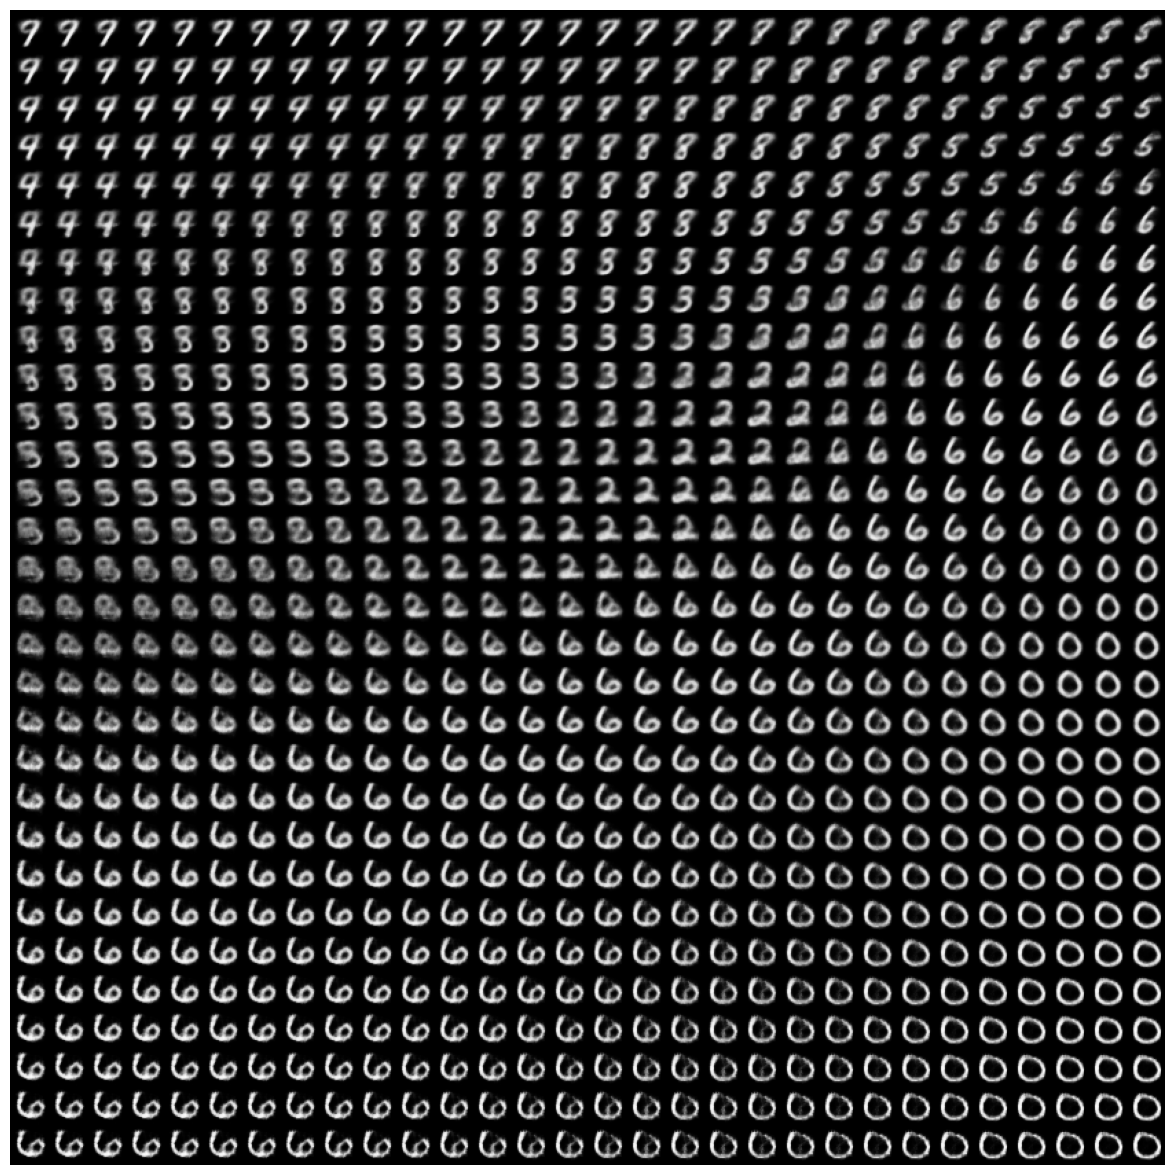

In [9]:
import matplotlib.pyplot as plt
 
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
 
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]
 
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size, ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")